In [370]:
import pandas as pd
import glob
import numpy as numpy
import matplotlib.pyplot as plt
from collections import defaultdict
from tqdm import tqdm
import time
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.decomposition import PCA
import seaborn as sns
import holidays
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Bidirectional, BatchNormalization

%pylab inline

Populating the interactive namespace from numpy and matplotlib


## Read in data
- Test checking for today's date

In [397]:
datetime.datetime.now().date() - datetime.timedelta(1)

datetime.date(2020, 4, 28)

In [410]:
datetime.datetime(2016,1,1).date()

datetime.date(2016, 1, 1)

In [412]:

def read_in_data():
    dict_of_stocks_and_dfs = {}
    for file_ in glob.glob('../data/updated_historical_stock_and_etf_data/*.csv'):
        stock_name = file_.rsplit("/")[-1].split('_')[0].lower() 
        print(f"Reading in {stock_name}")
        df_  = pd.read_csv(f"{file_}")
        # ensure we have the most recent data
        most_recent_date = pd.to_datetime(df_.date.max())
        oldest_date = pd.to_datetime(df_.date.min())
        if (most_recent_date == (datetime.datetime.now().date() - datetime.timedelta(1))) and (oldest_date < datetime.datetime(2016,1,1).date()):
            dict_of_stocks_and_dfs[stock_name] = df_.sort_values('date')
        else:
            print(f"Stock {stock_name} most recent date is {most_recent_date} oldest date is {oldest_date}. Skipping it")
    return dict_of_stocks_and_dfs

In [413]:
dict_of_stocks_and_dfs = read_in_data()

Reading in bjk
Reading in bac
Reading in ni
Reading in pnr
Reading in bke
Reading in dds
Reading in aeo
Reading in ph
Reading in urbn
Reading in vno
Reading in ual
Reading in efx
Reading in xrt
Reading in tjx
Reading in pg
Reading in dia
Reading in pvh
Reading in lb
Reading in m
Reading in gps
Reading in cato
Reading in pej
Reading in rop
Reading in scvl
Reading in spwh
Reading in are
Reading in jwn
Reading in tpr
Reading in fl
Reading in peg
Reading in adbe
Reading in ce
Reading in goos
Stock goos most recent date is 2020-04-28 00:00:00 oldest date is 2017-03-16 00:00:00. Skipping it
Reading in vfh
Reading in atvi
Reading in anf
Reading in gco
Reading in ctrn
Reading in boot
Reading in rost
Reading in so
Reading in spy
Reading in eqix
Reading in pbj
Reading in vti
Reading in kss
Reading in qqq


In [414]:
len(dict_of_stocks_and_dfs.keys())

46

In [415]:
dict_of_stocks_and_dfs['bac']

,date,open,high,low,close,volume
835,1986-05-29,3.6107,3.6389,3.6107,3.6295,16691365
836,1986-05-30,3.6107,3.6578,3.6107,3.6578,6895475
837,1986-06-02,3.6578,3.6768,3.6295,3.6485,333487
838,1986-06-03,3.6389,3.6768,3.6295,3.6768,163776
839,1986-06-04,3.6485,3.6768,3.6204,3.6204,203654
...,...,...,...,...,...,...
832,2020-04-22,22.1600,22.2300,21.7500,21.8000,49759122
833,2020-04-23,21.9600,22.3900,21.8500,21.8700,50614823
834,2020-04-24,22.1100,22.3000,21.6700,22.1800,47675736
1,2020-04-27,22.5200,23.6500,22.4500,23.4700,66916692


In [416]:
# key is company value is df of data
dict_of_stocks_and_dfs.keys()

dict_keys(['bjk', 'bac', 'ni', 'pnr', 'bke', 'dds', 'aeo', 'ph', 'urbn', 'vno', 'ual', 'efx', 'xrt', 'tjx', 'pg', 'dia', 'pvh', 'lb', 'm', 'gps', 'cato', 'pej', 'rop', 'scvl', 'spwh', 'are', 'jwn', 'tpr', 'fl', 'peg', 'adbe', 'ce', 'vfh', 'atvi', 'anf', 'gco', 'ctrn', 'boot', 'rost', 'so', 'spy', 'eqix', 'pbj', 'vti', 'kss', 'qqq'])

In [417]:
len(dict_of_stocks_and_dfs)

46

In [418]:
dict_of_stocks_and_dfs['peg']

,date,open,high,low,close,volume
835,1980-01-02,0.7046,0.7121,0.7046,0.7046,54382
836,1980-01-03,0.7046,0.7121,0.7046,0.7046,72600
837,1980-01-04,0.7046,0.7121,0.7046,0.7121,36171
838,1980-01-07,0.7121,0.7121,0.7046,0.7121,32207
839,1980-01-08,0.7121,0.7121,0.7046,0.7046,40656
...,...,...,...,...,...,...
832,2020-04-22,50.9900,51.6400,50.0400,51.1000,2211475
833,2020-04-23,51.1400,51.6200,50.0100,50.3700,2066896
834,2020-04-24,50.8200,51.6100,50.3100,51.3700,2594387
1,2020-04-27,51.6500,52.2300,51.2300,52.0100,2105067


In [419]:
dict_of_stocks_and_dfs['ni']

,date,open,high,low,close,volume
835,1984-10-19,0.9402,0.9468,0.9245,0.9310,6537424
836,1984-10-22,0.9310,0.9402,0.8992,0.9245,1402542
837,1984-10-23,0.9310,0.9310,0.9088,0.9152,1624556
838,1984-10-24,0.9152,0.9152,0.8992,0.9088,2320938
839,1984-10-25,0.8929,0.9025,0.8835,0.8835,2728976
...,...,...,...,...,...,...
832,2020-04-22,25.8400,26.1700,25.4100,26.0100,2917618
833,2020-04-23,25.9100,26.1500,25.4600,25.8500,3341663
834,2020-04-24,25.4800,26.1100,25.3100,26.0300,3993112
1,2020-04-27,26.1800,26.4200,25.9500,26.2500,2151280


In [420]:
dict_of_stocks_and_dfs['pnr'].date.max()

'2020-04-28'

In [421]:
dict_of_stocks_and_dfs['qqq'].date.min()

'1999-03-10'

In [422]:
dict_of_stocks_and_dfs['qqq'].date.max()

'2020-04-28'

# Create correlation & variance features
- Daily, weekly, 30-days, 90-days, 180-days, 365-daysreturn

In [423]:

# here the date is not the index, yet
first_stock_df = dict_of_stocks_and_dfs['ph'].loc[ dict_of_stocks_and_dfs['ph'].date.isin(dict_of_stocks_and_dfs['emr'].date), :]

KeyError: 'emr'

In [424]:
np.var(first_stock_df.close)

2632.50546526785

In [425]:
dict_of_stocks_and_dfs['ph'][dict_of_stocks_and_dfs['ph'].date == '2017-01-02']

,date,open,high,low,close,volume


## Set the date as the index and sort

In [426]:
first_stock_df = first_stock_df.sort_values('date')
second_stock_df = second_stock_df.sort_values('date')

first_stock_df = first_stock_df.set_index('date')
second_stock_df = second_stock_df.set_index('date')

NameError: name 'second_stock_df' is not defined

In [427]:
#pd.DataFrame(
first_stock_df.volume.rolling(7).std()[:10] # .fillna(method='backfill').astype(int))

834              NaN
835              NaN
836              NaN
837              NaN
838              NaN
839              NaN
840     95419.697574
841     93678.013509
842    217940.467100
843    232513.207094
Name: volume, dtype: float64

In [428]:
corr_df = pd.DataFrame(first_stock_df.close.rolling(7).corr(second_stock_df.close)).fillna(method='backfill').rename({'close': 'rolling_corr'},axis=1)

NameError: name 'second_stock_df' is not defined

In [429]:
corr_df

NameError: name 'corr_df' is not defined

In [ ]:
first_stock_df.index.max()

In [430]:
second_stock_df.index.max()

NameError: name 'second_stock_df' is not defined

In [431]:
np.corrcoef(first_stock_df.close, second_stock_df.close) # all time corrcoef

NameError: name 'second_stock_df' is not defined

NameError: name 'second_stock_df' is not defined

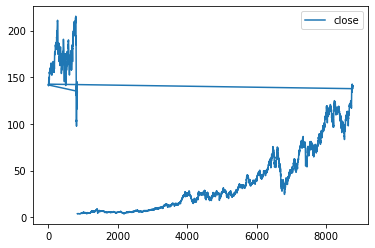

In [432]:

ax = first_stock_df.plot(y='close')
second_stock_df.plot(y='close', color='red', ax=ax)

In [ ]:
correlation_df.info()

In [433]:
correlation_df.set_index('date').plot(figsize=(30,5), title='Rolling 365-day correlation between ph and emr')

NameError: name 'correlation_df' is not defined

In [434]:
dict_of_stocks_and_dfs['cern'].groupby('date').count().sort_values(by='volume', ascending=True)

KeyError: 'cern'

## Build a function to create correlation features for all pairs of stocks

In [435]:
def build_correlation_dfs(dict_of_stocks_and_dfs, n_day_rolling_features_list=[ 3, 5, 7, 10, 30, 180, 365], verbose=False):
    """
    Create correlation + variance based  upon daily closing stock prices for given date ranges
    
    also include daily volume
    
    We are trying to  predict 7 day correaltion
    """

    stock_features_dict = defaultdict(pd.DataFrame)
    start_time = time.time()
    
    start = time.time()
    n_stocks = len(dict_of_stocks_and_dfs.keys())
    final_feature_df = create_date_dummy_df()
    pairs_of_stocks = []
    
    for idx, first_stock_name in enumerate(dict_of_stocks_and_dfs.keys()):
        print('')
        print(f"Finished {idx/n_stocks} pct of stocks")
        print('')
        for second_idx, second_stock_name in enumerate(dict_of_stocks_and_dfs.keys()):
            stock_pair = f"{first_stock_name}_{second_stock_name}"
            reverse_pair = f"{second_stock_name}_{first_stock_name}"
            
            if (first_stock_name == second_stock_name) or (stock_pair in pairs_of_stocks)  or (reverse_pair in pairs_of_stocks): # pnr -> ual same as ual -> pnr
                continue
            else:
                pairs_of_stocks.append(stock_pair)
            if verbose:
                print('-------')
                print(f"{first_stock_name} & {second_stock_name}")
                print('-------')
            
            # here the date is not the index, yet
            first_stock_df = dict_of_stocks_and_dfs[f"{first_stock_name}"].loc[ 
                dict_of_stocks_and_dfs[f"{first_stock_name}"].date.isin(dict_of_stocks_and_dfs[f"{second_stock_name}"].date), :]

            #  filter second df by the dates in first

            # here the date is not the index, yet
            second_stock_df = dict_of_stocks_and_dfs[f"{second_stock_name}"].loc[ 
                dict_of_stocks_and_dfs[f"{second_stock_name}"].date.isin(first_stock_df.date), :]
            
            # set the date as an index and sort by date
            first_stock_df = first_stock_df.sort_values('date')
            second_stock_df = second_stock_df.sort_values('date')

            first_stock_df = first_stock_df.set_index('date')
            second_stock_df = second_stock_df.set_index('date')
            
            all_features_df = pd.DataFrame()
            for rolling_idx, rolling_day in enumerate(n_day_rolling_features_list):
                if verbose:
                    print(f"Rolling calculations for {rolling_day}")
                features_df = create_correlation_and_variance_features(
                    first_stock_df, second_stock_df, rolling_day, final_feature_df, 
                    first_stock_name=first_stock_name, second_stock_name=second_stock_name)
                   
                current_feature_cols = set(features_df.columns)
                final_feature_cols = set(final_feature_df.columns)

                
                if (f"{first_stock_name}_volume" not in final_feature_df.columns) and (rolling_idx == 0):
                    features_df[f"{first_stock_name}_volume"] = list(first_stock_df.volume)
                
                if (f"{second_stock_name}_volume" not in final_feature_df.columns) and (rolling_idx == 0):
                    features_df[f"{second_stock_name}_volume"] = list(second_stock_df.volume)
                    
                if rolling_idx == 0: 
                    all_features_df = features_df
                else:
                    all_features_df = all_features_df.join(features_df, on='date', lsuffix='_left')
            

                    
            all_features_df.index = pd.to_datetime(all_features_df.index)
            final_feature_df = final_feature_df.join(all_features_df, on='date')

            if verbose:
                end = time.time()
                print(f"Building all features took {(end-start)/60} minutes")
                start = time.time()

    end_time = time.time()
    print(f"Total time {(end_time-start_time) / 60} minutes for {len(pairs_of_stocks)} pairs")
    final_feature_df = add_time_feature(final_feature_df)
    return final_feature_df, pairs_of_stocks
            
        

# Note: will eventuall need to add in 0s for stocks withour correlation data with other stocks due to date range

In [436]:
def create_date_dummy_df(start_date=datetime.datetime(1980,1,1), n_years=50):
    
    #  create dummy df with dates to join against
    list_of_dates  = []
    n_days = 365*n_years
    start_date = start_date

    for i in range(n_days):
        list_of_dates.append(start_date + datetime.timedelta(i))
    df_ = pd.DataFrame(list_of_dates, columns=['date'])
    
    df_.date_ =  pd.to_datetime(df_.date)
    return df_.set_index('date')
    

In [437]:
def add_time_feature(final_stock_df):
    
    days = [i.day for i in final_stock_df.index]
    months = [i.month for i in final_stock_df.index]
    quarters = [i.quarter for i in final_stock_df.index]
    years = [i.year for i in final_stock_df.index]
    
    us_holidays = holidays.UnitedStates()
    
    h_ = np.array([i in us_holidays for i in final_stock_df.index]).astype(int)


    final_stock_df['day'] = days
    final_stock_df['month'] = months
    final_stock_df['quarter'] = quarters
    final_stock_df['year'] = years
    final_stock_df['is_holiday'] = h_
    
    return final_stock_df

In [438]:
def create_correlation_and_variance_features(first_stock_df, second_stock_df, n_days_stride, final_stock_df, 
                                             first_stock_name=None, second_stock_name=None, verbose=False):
    """
    n_days_stride: the  number of rolling days to calculate correlation for
    """
    n_rows = len(first_stock_df)

    previous_row = 0

    features_per_time_period = defaultdict(list)
    if verbose:
        print(f"Creating correlations + variance on close for {n_days_stride} days")
    
    rolling_close_df = pd.DataFrame(first_stock_df.close.rolling(
        n_days_stride).corr(second_stock_df.close)).rename(
        {'close': f"{first_stock_name}_{second_stock_name}_close_corr_rolling_{n_days_stride}_days"},axis=1).fillna(method='backfill').round(6)

    
    # add cols
    
    current_feature_cols = list(final_stock_df.columns)
    

    # as we go through different pairs will have multiple var / corr for the first stock
    # pnc_bar calcualtes corr for pnr
    #pnr_bat calculates corr for pnr
    # don't want the same cols
    if f"{first_stock_name}_close_std_rolling_{n_days_stride}_days" not in current_feature_cols:
        
        rolling_close_std_first_stock =  first_stock_df.close.rolling(n_days_stride).std().fillna(method='backfill').round(6)
        rolling_close_df[f"{first_stock_name}_close_std_rolling_{n_days_stride}_days"] = rolling_close_std_first_stock
        
    if f"{second_stock_name}_close_std_rolling_{n_days_stride}_days" not in current_feature_cols:
        rolling_close_std_second_stock =  second_stock_df.close.rolling(n_days_stride).std().fillna(method='backfill').round( 6)
        rolling_close_df[f"{second_stock_name}_close_std_rolling_{n_days_stride}_days"] = rolling_close_std_second_stock
        
    if f"{first_stock_name}_volume_std_rolling_{n_days_stride}_days" not in current_feature_cols:
        rolling_volume_std_first_stock =  first_stock_df.volume.rolling(n_days_stride).std().fillna(method='backfill').round(6)
        rolling_close_df[f"{first_stock_name}_volume_std_rolling_{n_days_stride}_days"] = rolling_volume_std_first_stock
        
    if f"{second_stock_name}_volume_std_rolling_{n_days_stride}_days" not in current_feature_cols:
        rolling_volume_std_second_stock =  second_stock_df.volume.rolling(n_days_stride).std().fillna(method='backfill').round(6)
        rolling_close_df[f"{second_stock_name}_volume_std_rolling_{n_days_stride}_days"] = rolling_volume_std_second_stock
    
    return rolling_close_df



In [ ]:
# 2 minutes fo 210 pairs
final_stock_df, pairs_of_stocks = build_correlation_dfs(dict_of_stocks_and_dfs, verbose=False)

/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  if sys.path[0] == '':



Finished 0.0 pct of stocks


Finished 0.021739130434782608 pct of stocks



In [380]:
len(final_stock_df.columns)

8621

In [1423]:
final_stock_df[~pd.isna(final_stock_df.pnr_bac_close_corr_rolling_3_days)]

,eqix_rost_close_corr_rolling_3_days,eqix_close_std_rolling_3_days,rost_close_std_rolling_3_days,eqix_volume_std_rolling_3_days,rost_volume_std_rolling_3_days,eqix_volume,rost_volume,eqix_rost_close_corr_rolling_6_days,eqix_close_std_rolling_6_days,rost_close_std_rolling_6_days,...,bac_ni_close_corr_rolling_30_days,bac_ni_close_corr_rolling_60_days,bac_ni_close_corr_rolling_90_days,bac_ni_close_corr_rolling_180_days,bac_ni_close_corr_rolling_365_days,day,month,quarter,year,is_holiday
date,,,,,,,,,,,,,,,,,,,,,
2005-02-25,-0.674725,0.227786,0.034755,34417.241396,1.370540e+06,101044.0,4053375.0,0.815942,0.955232,0.247500,...,0.472253,0.208729,0.332521,0.713070,0.600343,25,2,1,2005,0
2005-02-28,-0.674725,0.227786,0.034755,34417.241396,1.370540e+06,157510.0,3504738.0,0.815942,0.955232,0.247500,...,0.468663,0.230703,0.317359,0.713723,0.601679,28,2,1,2005,0
2005-03-01,-0.674725,0.227786,0.034755,34417.241396,1.370540e+06,163370.0,6104866.0,0.815942,0.955232,0.247500,...,0.509679,0.251617,0.296525,0.714306,0.603787,1,3,1,2005,0
2005-03-02,0.155460,0.249492,0.092128,9822.208577,1.749734e+06,176678.0,6833154.0,0.815942,0.955232,0.247500,...,0.503664,0.264849,0.272528,0.713619,0.606069,2,3,1,2005,0
2005-03-03,0.944908,0.354056,0.210178,53985.128854,8.015813e+06,262816.0,20338472.0,0.815942,0.955232,0.247500,...,0.602648,0.287665,0.239791,0.712324,0.607683,3,3,1,2005,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-04-20,0.921834,12.100167,2.832178,10426.116454,1.245721e+06,519465.0,3565677.0,0.806622,13.560098,2.202212,...,0.785553,0.893178,0.782362,0.478982,0.468392,20,4,2,2020,0
2020-04-21,0.883428,13.572675,4.528072,52815.552637,7.638944e+05,420730.0,4154852.0,0.831760,9.717596,3.283860,...,0.813368,0.892376,0.786006,0.486588,0.472182,21,4,2,2020,0
2020-04-22,-0.308115,7.721531,1.951692,53591.032244,4.522756e+05,433979.0,3265862.0,0.586243,9.167159,3.253450,...,0.799865,0.889803,0.788002,0.490475,0.474366,22,4,2,2020,0


In [1424]:
# drop na
final_stock_df = final_stock_df.dropna()

In [1425]:
len(pairs_of_stocks)

210

In [1426]:
# last date of dtaa
last_date_of_data = '2020-04-17'

In [1427]:
final_stock_df[final_stock_df.index == last_date_of_data]

,eqix_rost_close_corr_rolling_3_days,eqix_close_std_rolling_3_days,rost_close_std_rolling_3_days,eqix_volume_std_rolling_3_days,rost_volume_std_rolling_3_days,eqix_volume,rost_volume,eqix_rost_close_corr_rolling_6_days,eqix_close_std_rolling_6_days,rost_close_std_rolling_6_days,...,bac_ni_close_corr_rolling_30_days,bac_ni_close_corr_rolling_60_days,bac_ni_close_corr_rolling_90_days,bac_ni_close_corr_rolling_180_days,bac_ni_close_corr_rolling_365_days,day,month,quarter,year,is_holiday
date,,,,,,,,,,,,,,,,,,,,,
2020-04-17,0.780499,9.816692,2.323195,87720.694094,1.496140e+06,502609.0,5081026.0,0.762826,13.356595,1.939649,...,0.822318,0.893446,0.777699,0.471441,0.465007,17,4,2,2020,0


In [1428]:
pairs_of_stocks[:10]

['eqix_rost',
 'eqix_so',
 'eqix_emr',
 'eqix_atvi',
 'eqix_ce',
 'eqix_cern',
 'eqix_peg',
 'eqix_adbe',
 'eqix_rop',
 'eqix_are']

In [1429]:
final_stock_df.loc[~pd.isna(final_stock_df.pnr_volume), :]

,eqix_rost_close_corr_rolling_3_days,eqix_close_std_rolling_3_days,rost_close_std_rolling_3_days,eqix_volume_std_rolling_3_days,rost_volume_std_rolling_3_days,eqix_volume,rost_volume,eqix_rost_close_corr_rolling_6_days,eqix_close_std_rolling_6_days,rost_close_std_rolling_6_days,...,bac_ni_close_corr_rolling_30_days,bac_ni_close_corr_rolling_60_days,bac_ni_close_corr_rolling_90_days,bac_ni_close_corr_rolling_180_days,bac_ni_close_corr_rolling_365_days,day,month,quarter,year,is_holiday
date,,,,,,,,,,,,,,,,,,,,,
2006-01-25,0.697482,0.282852,0.068850,20062.106769,3.307482e+06,235169.0,4918853.0,0.709943,0.385182,0.121731,...,0.368948,-0.512014,-0.799915,-0.225630,-0.135606,25,1,1,2006,0
2006-01-26,-0.712630,0.131936,0.025701,175816.922796,3.364882e+06,547429.0,5432737.0,0.801974,0.384777,0.111135,...,0.379214,-0.456781,-0.807436,-0.226264,-0.140600,26,1,1,2006,0
2006-01-27,0.931257,0.353271,0.048220,156472.651685,5.959368e+05,373373.0,6107119.0,0.635272,0.402604,0.058964,...,0.427250,-0.344494,-0.803128,-0.226564,-0.144211,27,1,1,2006,0
2006-01-30,0.560951,0.349257,0.057870,109960.000183,1.163736e+06,343988.0,3840744.0,0.657181,0.371951,0.060240,...,0.473339,-0.183239,-0.787769,-0.223135,-0.144993,30,1,1,2006,0
2006-01-31,0.999991,0.206297,0.094188,84712.417773,3.034216e+06,214178.0,9849079.0,0.167156,0.273997,0.064078,...,0.506812,-0.019687,-0.769228,-0.218527,-0.145200,31,1,1,2006,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-04-20,0.921834,12.100167,2.832178,10426.116454,1.245721e+06,519465.0,3565677.0,0.806622,13.560098,2.202212,...,0.785553,0.893178,0.782362,0.478982,0.468392,20,4,2,2020,0
2020-04-21,0.883428,13.572675,4.528072,52815.552637,7.638944e+05,420730.0,4154852.0,0.831760,9.717596,3.283860,...,0.813368,0.892376,0.786006,0.486588,0.472182,21,4,2,2020,0
2020-04-22,-0.308115,7.721531,1.951692,53591.032244,4.522756e+05,433979.0,3265862.0,0.586243,9.167159,3.253450,...,0.799865,0.889803,0.788002,0.490475,0.474366,22,4,2,2020,0


In [1430]:
final_stock_df.loc[~pd.isna(final_stock_df.pnr_volume), :]

,eqix_rost_close_corr_rolling_3_days,eqix_close_std_rolling_3_days,rost_close_std_rolling_3_days,eqix_volume_std_rolling_3_days,rost_volume_std_rolling_3_days,eqix_volume,rost_volume,eqix_rost_close_corr_rolling_6_days,eqix_close_std_rolling_6_days,rost_close_std_rolling_6_days,...,bac_ni_close_corr_rolling_30_days,bac_ni_close_corr_rolling_60_days,bac_ni_close_corr_rolling_90_days,bac_ni_close_corr_rolling_180_days,bac_ni_close_corr_rolling_365_days,day,month,quarter,year,is_holiday
date,,,,,,,,,,,,,,,,,,,,,
2006-01-25,0.697482,0.282852,0.068850,20062.106769,3.307482e+06,235169.0,4918853.0,0.709943,0.385182,0.121731,...,0.368948,-0.512014,-0.799915,-0.225630,-0.135606,25,1,1,2006,0
2006-01-26,-0.712630,0.131936,0.025701,175816.922796,3.364882e+06,547429.0,5432737.0,0.801974,0.384777,0.111135,...,0.379214,-0.456781,-0.807436,-0.226264,-0.140600,26,1,1,2006,0
2006-01-27,0.931257,0.353271,0.048220,156472.651685,5.959368e+05,373373.0,6107119.0,0.635272,0.402604,0.058964,...,0.427250,-0.344494,-0.803128,-0.226564,-0.144211,27,1,1,2006,0
2006-01-30,0.560951,0.349257,0.057870,109960.000183,1.163736e+06,343988.0,3840744.0,0.657181,0.371951,0.060240,...,0.473339,-0.183239,-0.787769,-0.223135,-0.144993,30,1,1,2006,0
2006-01-31,0.999991,0.206297,0.094188,84712.417773,3.034216e+06,214178.0,9849079.0,0.167156,0.273997,0.064078,...,0.506812,-0.019687,-0.769228,-0.218527,-0.145200,31,1,1,2006,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-04-20,0.921834,12.100167,2.832178,10426.116454,1.245721e+06,519465.0,3565677.0,0.806622,13.560098,2.202212,...,0.785553,0.893178,0.782362,0.478982,0.468392,20,4,2,2020,0
2020-04-21,0.883428,13.572675,4.528072,52815.552637,7.638944e+05,420730.0,4154852.0,0.831760,9.717596,3.283860,...,0.813368,0.892376,0.786006,0.486588,0.472182,21,4,2,2020,0
2020-04-22,-0.308115,7.721531,1.951692,53591.032244,4.522756e+05,433979.0,3265862.0,0.586243,9.167159,3.253450,...,0.799865,0.889803,0.788002,0.490475,0.474366,22,4,2,2020,0


In [67]:
final_stock_df.loc[((final_stock_df.index>'2020-01-01') & (final_stock_df.index<'2021-01-01')), :][['pnr_bac_close_corr_rolling_3_days','pnr_bac_close_corr_rolling_6_days', 
                                                'pnr_bac_close_corr_rolling_8_days']].plot(figsize=(15,5))

KeyError: "None of [Index(['pnr_bac_close_corr_rolling_3_days',\n       'pnr_bac_close_corr_rolling_6_days',\n       'pnr_bac_close_corr_rolling_8_days'],\n      dtype='object')] are in the [columns]"

## Train Test Split to predict correlation over the next 7 days
- rolling evey day make a predictions about what the correlation will be for the next 7 days stock price

In [1442]:
datetime.timedelta(7)

datetime.timedelta(days=7)

- Rolling Predictions

In [54]:
# drop na
final_stock_df = final_stock_df.dropna()

In [55]:
final_stock_df

,vti_pbj_close_corr_rolling_3_days,vti_close_std_rolling_3_days,pbj_close_std_rolling_3_days,vti_volume_std_rolling_3_days,pbj_volume_std_rolling_3_days,vti_volume,pbj_volume,vti_pbj_close_corr_rolling_5_days,vti_close_std_rolling_5_days,pbj_close_std_rolling_5_days,...,bjk_pnr_close_corr_rolling_7_days,bjk_pnr_close_corr_rolling_10_days,bjk_pnr_close_corr_rolling_30_days,bjk_pnr_close_corr_rolling_180_days,bjk_pnr_close_corr_rolling_365_days,day,month,quarter,year,is_holiday
date,,,,,,,,,,,,,,,,,,,,,
2008-01-24,0.999899,0.986110,0.180877,8.388648e+05,41807.466462,3222971.0,20113.0,0.868594,0.728083,0.132794,...,0.145234,0.085425,0.241353,-0.130591,0.815712,24,1,1,2008,0
2008-01-25,1.000000,0.428743,0.072707,4.237285e+05,43415.186709,2383496.0,35984.0,0.889604,0.727907,0.130325,...,0.145234,0.085425,0.241353,-0.130591,0.815712,25,1,1,2008,0
2008-01-28,0.997025,0.624921,0.115846,7.053708e+05,8604.482611,1821345.0,33810.0,0.999158,0.863593,0.161703,...,0.145234,0.085425,0.241353,-0.130591,0.815712,28,1,1,2008,0
2008-01-29,0.754605,0.784458,0.114561,6.584981e+05,352642.600930,1070990.0,645689.0,0.750112,0.583144,0.084016,...,0.145234,0.085425,0.241353,-0.130591,0.815712,29,1,1,2008,0
2008-01-30,0.741416,0.269760,0.239013,4.810668e+05,354593.069817,1967705.0,29247.0,0.310650,0.555282,0.177802,...,0.145234,0.085425,0.241353,-0.130591,0.815712,30,1,1,2008,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-04-20,0.999824,1.980337,0.191398,6.108858e+05,2285.927893,5413970.0,10832.0,0.927386,1.886218,0.297741,...,0.396721,0.306035,0.888707,0.949961,0.842969,20,4,2,2020,0
2020-04-21,0.997594,3.396945,0.417413,5.635615e+05,1807.817561,6367548.0,8868.0,0.942344,2.509974,0.348956,...,0.739182,0.173201,0.867307,0.950832,0.845414,21,4,2,2020,0
2020-04-22,0.925049,2.245269,0.356791,5.435611e+05,1091.420633,6342857.0,10675.0,0.928595,2.441694,0.308107,...,0.822660,0.257951,0.830176,0.951545,0.847824,22,4,2,2020,0


In [79]:
final_stock_df = final_stock_df.dropna()

In [124]:
# scaler=StandardScaler()
# final_stock_df = scaler.fit_transform(final_stock_df)

- Add Keras LSTM 

In [80]:
# prepare data for Keras
# (n_samples, n_timesteps (rows), n_features)
#The first dimension is the number of samples, in this case 7. 
# The second dimension is the number of time steps per sample, in this case 3, the value specified to the function. 
#Finally, the last dimension specifies the number of parallel time series or the number of variables, in this case 2 for the two parallel series.

# Let's say we use two years of data for n_timesteps (720 days)

In [43]:
N_DAY_TIMESTEPS = 720 #n days

In [316]:
# prepare the data for LSTM model
def split_sequences(sequences, n_steps, y_col='so_pg_close_corr_rolling_7_days', start_idx=2800, n_val=50): #2200
    """
    sequences = input_data
    n_steps = n_days of data to give at a time
    
    only works for the currently set y_col
    """
    X, y = list(), list()
    X_val, y_val = list(), list()
    
    n_sequences = len(sequences)
    print('n_sequences', n_sequences)

    for i in range(start_idx, n_sequences):
        if i == start_idx:
            print(f"Training idx start at {i}")
        if (i % 100 == 0) and i != 0:
            print(f"Pct finished = {i/n_sequences}")
            
        # find the end of this pattern
        end_ix = i + n_steps 
        total_end_ix = end_ix + n_val
        # check if we are beyond the dataset
        if (total_end_ix) > n_sequences:
            print(f"Training idx end at {end_ix}")
            print('Total idx checked', total_end_ix)
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = np.array(sequences.loc[:, sequences.columns != f"{y_col}"][i:end_ix]), np.array(
            sequences.loc[:, sequences.columns == f"{y_col}"].shift(-7).fillna(method='ffill').iloc[end_ix-1])

                                 
        X.append(seq_x)
        y.append(seq_y)
    
    val_start_idx = start_idx + n_sequences - (start_idx  + n_val -2)
    for i in range(val_start_idx, n_sequences):
        if i == val_start_idx:
            print(f"Val idx start at {val_start_idx}")
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the dataset
        if end_ix > len(sequences):
            print(f"Val idx end at {end_ix}")
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = np.array(sequences.loc[:, sequences.columns != f"{y_col}"][i:end_ix]), np.array(
            sequences.loc[:, sequences.columns == f"{y_col}"].shift(-7).fillna(method='ffill').iloc[end_ix-1])
        

        
        X_val.append(seq_x)
        y_val.append(seq_y)
    
    
            


    X, y, X_val, y_val = array(X), array(y), array(X_val), array(y_val)

       # inf
    X = np.nan_to_num(X.astype(np.float32)) # converting to float 32 throws some infinity errors
    X_val = np.nan_to_num(X_val.astype(np.float32)) # converting to float 32 throws some infinity errors  
    
    
    scalers = {}
    for i in range(X.shape[1]):
        scalers[i] = StandardScaler()
        X[:, i, :] = scalers[i].fit_transform(X[:, i, :]) 

    print(X_val.shape)
    print(scalers)
    for i in range(X_val.shape[1]):
        X_val[:, i, :] = scalers[i].transform(X_val[:, i, :]) 
    

    
    return X, y, X_val, y_val

    
    

In [317]:
len(final_stock_df[final_stock_df.index >='2020-01-1'])

79

In [318]:
79-10-50

19

In [319]:
784+50+30 > 833

True

In [337]:
X,y, X_val, y_val = split_sequences(final_stock_df[final_stock_df.index >='2010-01-1'], 30, start_idx=0, n_val=100) # 720 steps

n_sequences 2590
Training idx start at 0
Pct finished = 0.03861003861003861
Pct finished = 0.07722007722007722
Pct finished = 0.11583011583011583
Pct finished = 0.15444015444015444
Pct finished = 0.19305019305019305
Pct finished = 0.23166023166023167
Pct finished = 0.2702702702702703
Pct finished = 0.3088803088803089
Pct finished = 0.3474903474903475
Pct finished = 0.3861003861003861
Pct finished = 0.4247104247104247
Pct finished = 0.46332046332046334
Pct finished = 0.5019305019305019
Pct finished = 0.5405405405405406
Pct finished = 0.5791505791505791
Pct finished = 0.6177606177606177
Pct finished = 0.6563706563706564
Pct finished = 0.694980694980695
Pct finished = 0.7335907335907336
Pct finished = 0.7722007722007722
Pct finished = 0.8108108108108109
Pct finished = 0.8494208494208494
Pct finished = 0.888030888030888
Pct finished = 0.9266409266409267
Training idx end at 2491
Total idx checked 2591
Val idx start at 2492
Val idx end at 2591


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
/Users/jonathanhilgart/Library/Caches/pypoetry/virtualen

(69, 30, 3724)
{0: StandardScaler(copy=True, with_mean=True, with_std=True), 1: StandardScaler(copy=True, with_mean=True, with_std=True), 2: StandardScaler(copy=True, with_mean=True, with_std=True), 3: StandardScaler(copy=True, with_mean=True, with_std=True), 4: StandardScaler(copy=True, with_mean=True, with_std=True), 5: StandardScaler(copy=True, with_mean=True, with_std=True), 6: StandardScaler(copy=True, with_mean=True, with_std=True), 7: StandardScaler(copy=True, with_mean=True, with_std=True), 8: StandardScaler(copy=True, with_mean=True, with_std=True), 9: StandardScaler(copy=True, with_mean=True, with_std=True), 10: StandardScaler(copy=True, with_mean=True, with_std=True), 11: StandardScaler(copy=True, with_mean=True, with_std=True), 12: StandardScaler(copy=True, with_mean=True, with_std=True), 13: StandardScaler(copy=True, with_mean=True, with_std=True), 14: StandardScaler(copy=True, with_mean=True, with_std=True), 15: StandardScaler(copy=True, with_mean=True, with_std=True), 16

In [338]:
def build_keras_model(n_steps, n_features):
    model = Sequential()
    model.add(Bidirectional(LSTM(10, activation='relu', return_sequences=True, dropout=.05), input_shape=(n_steps, n_features)))
    model.add(BatchNormalization())    
    model.add(Bidirectional(LSTM(10, activation='relu', dropout=.05), input_shape=(n_steps, n_features)))
    model.add(Dense(50))
    model.add(Dense(1))
    model.compile(optimizer='nadam', loss='mse', metrics=['mse'])
    return model

In [339]:
smaller_model = build_keras_model(X.shape[1],X.shape[2])

In [345]:
smaller_model.summary()

Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_27 (Bidirectio (None, 30, 200)           3060000   
_________________________________________________________________
batch_normalization_8 (Batch (None, 30, 200)           800       
_________________________________________________________________
bidirectional_28 (Bidirectio (None, 200)               240800    
_________________________________________________________________
dense_36 (Dense)             (None, 50)                10050     
_________________________________________________________________
dense_37 (Dense)             (None, 1)                 51        
Total params: 3,311,701
Trainable params: 3,311,301
Non-trainable params: 400
_________________________________________________________________


In [346]:
model.save('../models/so_pg.h5')

In [359]:
history = model.fit(x=X, y=y, batch_size=32, epochs=200, verbose=1, 
          validation_data=(X_val, y_val), shuffle=False,  use_multiprocessing=False)


Train on 2461 samples, validate on 69 samples
Epoch 1/200
2461/2461 [==============================] - 18s 7ms/sample - loss: 0.0970 - mse: 0.0970 - val_loss: 1.4135 - val_mse: 1.4135
Epoch 2/200
2461/2461 [==============================] - 18s 7ms/sample - loss: 0.0867 - mse: 0.0867 - val_loss: 0.6887 - val_mse: 0.6887
Epoch 3/200
2461/2461 [==============================] - 18s 7ms/sample - loss: 0.0842 - mse: 0.0842 - val_loss: 0.6236 - val_mse: 0.6236
Epoch 4/200
2461/2461 [==============================] - 18s 7ms/sample - loss: 0.0783 - mse: 0.0783 - val_loss: 0.3217 - val_mse: 0.3217
Epoch 5/200
2461/2461 [==============================] - 18s 7ms/sample - loss: 0.0975 - mse: 0.0975 - val_loss: 0.3882 - val_mse: 0.3882
Epoch 6/200
2461/2461 [==============================] - 18s 7ms/sample - loss: 0.0861 - mse: 0.0861 - val_loss: 0.3453 - val_mse: 0.3453
Epoch 7/200
2461/2461 [==============================] - 18s 7ms/sample - loss: 0.0806 - mse: 0.0806 - val_loss: 0.3336 - val_

In [360]:
history_df  = pd.DataFrame(history.history)

In [361]:
history_df['val_rmse'] = np.sqrt(history_df.val_mse)
history_df['rmse'] = np.sqrt(history_df.mse)

In [362]:
np.mean(history_df.val_rmse)

0.5986335639990141

In [363]:
np.mean(history_df.val_rmse[-20:])

0.6483674395225486

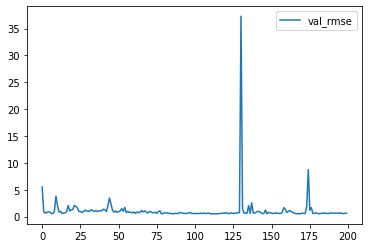

In [344]:
history_df[['val_rmse']].plot()

## Historical testing

In [1463]:
# final_stock_df[:, ['close_corr_rolling_7_days' in i  for i in final_stock_df.columns]]

In [366]:
def evaluate_predictions_on_rolling_historical_data(final_stock_df, rolling_window = 7, starting_date_index= 2950,
                                                   y_col='so_pg_close_corr_rolling_7_days'):
    """
    Backtesting
    
    For now, assumes the final_stock only has pairs the one start stock and all others, pnc_bac, pnc_bar ...etc
    """
    
    predicted_corr_7_days = []
    actual = []
    rmse_corr_7_days = []
    prediction_date = []

    print_idx = 5
     # otherwise, takes too long
    start = time.time()

    final_row = None
    print(len(final_stock_df))
    for date_idx, date in enumerate(list(final_stock_df.index)[starting_date_index:]):
#         print((date_id + starting_date_index+rolling_window+1))
#         print(len(final_stock_df))

        if final_row:
            break
        if (date_idx + starting_date_index +rolling_window +1) == len(final_stock_df): # last row
            final_row = True
            # need to use the dates from the DF due to weekends
            train_dates = final_stock_df.index[:starting_date_index+date_idx]
            # The test is the rolling 7-day corr looking back the past seven days
            # Therefore, the test_date should be seven dates ahead of the data we are training on

            test_date = final_stock_df.index[starting_date_index+rolling_window+date_idx]

        else:
            # need to use the dates from the DF due to weekends
            train_dates = final_stock_df.index[:starting_date_index+date_idx+1]
            # The test is the rolling 7-day corr looking back the past seven days
            # Therefore, the test_date should be seven dates ahead of the data we are training on

            test_date = final_stock_df.index[starting_date_index+rolling_window+date_idx+1]


        prediction_date.append(test_date)

        if date_idx % print_idx == 0:
            print(f"Train dates =  {train_dates}")
            print(F"Prediction date = {test_date}")

        train_df = final_stock_df[final_stock_df.index.isin(list(train_dates))]
        test_df = final_stock_df[final_stock_df.index == test_date]
        
        # put data in the past for prediction X
        test_X_df = final_stock_df.shift(-7).fillna(method='ffill') 
        test_X_df= test_X_df[test_X_df.index == test_date]


        # TODO - search for the rolling 7-days column, don't hardcode
        X_train, y_train = train_df.loc[:, train_df.columns != f"{y_col}"],  train_df[f"{y_col}"].shift(-7).fillna(method='ffill') 
        X_test, y_test = test_X_df.loc[:, test_X_df.columns != f"{y_col}"],  test_df[f"{y_col}"]
        
        # inf
        X_train = np.nan_to_num(X_train.astype(np.float32)) # converting to float 32 throws some infinity errors
        X_test = np.nan_to_num(X_test.astype(np.float32)) # converting to float 32 throws some infinity errors        
        
        
        # standard scaler for cols
        scaler=StandardScaler()
        scaler.fit(X_train)
        X_train = scaler.transform(X_train)
        X_test = scaler.transform(X_test)



        # Make an instance of the Model
        # only train on train_x and transform both train an test

        pca = PCA(.60, whiten=True)
        pca.fit(X_train)
        X_train = pca.transform(X_train)
        X_test = pca.transform(X_test)




        #estimator = GradientBoostingRegressor()
        estimator_two = RandomForestRegressor(n_jobs=-1)
        estimator_one = SVR(C=.5, kernel='rbf')

        estimator_one.fit(X_train, y_train)
        estimator_two.fit(X_train, y_train)

        prediction_one = estimator_one.predict(X_test)
        prediction_two = estimator_two.predict(X_test)
        prediction = np.mean([prediction_one[0], prediction_two[0] ])

        predicted_corr_7_days.append(prediction)
        actual.append(y_test.values[0])

        rmse_corr_7_days.append(np.sqrt(mean_squared_error(y_test, [prediction])))
        if date_idx % print_idx == 0:
            print('prediction = ', prediction)
            print('actual =', y_test.values)
            print('')


    end = time.time()

    print(f"Predictions took {(end-start)/60} minutes")
    
    prediction_df = pd.DataFrame( {'actual_corr_7_days':actual, 'predicted_corr_7_days': predicted_corr_7_days, 
                                   'prediction_date':prediction_date, 'rmse_corr_7_days':rmse_corr_7_days})
    print('here')
    return prediction_df

In [367]:
hist_predictions_df = evaluate_predictions_on_rolling_historical_data(final_stock_df)

3063
Train dates =  DatetimeIndex(['2008-01-24', '2008-01-25', '2008-01-28', '2008-01-29',
               '2008-01-30', '2008-01-31', '2008-02-01', '2008-02-04',
               '2008-02-05', '2008-02-06',
               ...
               '2019-10-30', '2019-10-31', '2019-11-01', '2019-11-04',
               '2019-11-05', '2019-11-06', '2019-11-07', '2019-11-08',
               '2019-11-11', '2019-11-12'],
              dtype='datetime64[ns]', name='date', length=2951, freq=None)
Prediction date = 2019-11-22 00:00:00


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


prediction =  0.42242025204303
actual = [0.010353]



/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


Train dates =  DatetimeIndex(['2008-01-24', '2008-01-25', '2008-01-28', '2008-01-29',
               '2008-01-30', '2008-01-31', '2008-02-01', '2008-02-04',
               '2008-02-05', '2008-02-06',
               ...
               '2019-11-06', '2019-11-07', '2019-11-08', '2019-11-11',
               '2019-11-12', '2019-11-13', '2019-11-14', '2019-11-15',
               '2019-11-18', '2019-11-19'],
              dtype='datetime64[ns]', name='date', length=2956, freq=None)
Prediction date = 2019-12-02 00:00:00


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


prediction =  0.6620319169251877
actual = [-0.814098]



/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


Train dates =  DatetimeIndex(['2008-01-24', '2008-01-25', '2008-01-28', '2008-01-29',
               '2008-01-30', '2008-01-31', '2008-02-01', '2008-02-04',
               '2008-02-05', '2008-02-06',
               ...
               '2019-11-13', '2019-11-14', '2019-11-15', '2019-11-18',
               '2019-11-19', '2019-11-20', '2019-11-21', '2019-11-22',
               '2019-11-25', '2019-11-26'],
              dtype='datetime64[ns]', name='date', length=2961, freq=None)
Prediction date = 2019-12-09 00:00:00


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


prediction =  0.30679428803280573
actual = [0.240509]



/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


Train dates =  DatetimeIndex(['2008-01-24', '2008-01-25', '2008-01-28', '2008-01-29',
               '2008-01-30', '2008-01-31', '2008-02-01', '2008-02-04',
               '2008-02-05', '2008-02-06',
               ...
               '2019-11-20', '2019-11-21', '2019-11-22', '2019-11-25',
               '2019-11-26', '2019-11-27', '2019-11-29', '2019-12-02',
               '2019-12-03', '2019-12-04'],
              dtype='datetime64[ns]', name='date', length=2966, freq=None)
Prediction date = 2019-12-16 00:00:00


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


prediction =  0.48448423263227514
actual = [0.24349]



/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


Train dates =  DatetimeIndex(['2008-01-24', '2008-01-25', '2008-01-28', '2008-01-29',
               '2008-01-30', '2008-01-31', '2008-02-01', '2008-02-04',
               '2008-02-05', '2008-02-06',
               ...
               '2019-11-27', '2019-11-29', '2019-12-02', '2019-12-03',
               '2019-12-04', '2019-12-05', '2019-12-06', '2019-12-09',
               '2019-12-10', '2019-12-11'],
              dtype='datetime64[ns]', name='date', length=2971, freq=None)
Prediction date = 2019-12-23 00:00:00


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


prediction =  0.43784233817909946
actual = [-0.442035]



/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


Train dates =  DatetimeIndex(['2008-01-24', '2008-01-25', '2008-01-28', '2008-01-29',
               '2008-01-30', '2008-01-31', '2008-02-01', '2008-02-04',
               '2008-02-05', '2008-02-06',
               ...
               '2019-12-05', '2019-12-06', '2019-12-09', '2019-12-10',
               '2019-12-11', '2019-12-12', '2019-12-13', '2019-12-16',
               '2019-12-17', '2019-12-18'],
              dtype='datetime64[ns]', name='date', length=2976, freq=None)
Prediction date = 2019-12-31 00:00:00


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


prediction =  0.42024280186187435
actual = [0.140882]



/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


Train dates =  DatetimeIndex(['2008-01-24', '2008-01-25', '2008-01-28', '2008-01-29',
               '2008-01-30', '2008-01-31', '2008-02-01', '2008-02-04',
               '2008-02-05', '2008-02-06',
               ...
               '2019-12-12', '2019-12-13', '2019-12-16', '2019-12-17',
               '2019-12-18', '2019-12-19', '2019-12-20', '2019-12-23',
               '2019-12-24', '2019-12-26'],
              dtype='datetime64[ns]', name='date', length=2981, freq=None)
Prediction date = 2020-01-08 00:00:00


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


prediction =  0.31696466390672573
actual = [0.911473]



/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


Train dates =  DatetimeIndex(['2008-01-24', '2008-01-25', '2008-01-28', '2008-01-29',
               '2008-01-30', '2008-01-31', '2008-02-01', '2008-02-04',
               '2008-02-05', '2008-02-06',
               ...
               '2019-12-19', '2019-12-20', '2019-12-23', '2019-12-24',
               '2019-12-26', '2019-12-27', '2019-12-30', '2019-12-31',
               '2020-01-02', '2020-01-03'],
              dtype='datetime64[ns]', name='date', length=2986, freq=None)
Prediction date = 2020-01-15 00:00:00


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


prediction =  0.49475219720377434
actual = [0.957469]



/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


Train dates =  DatetimeIndex(['2008-01-24', '2008-01-25', '2008-01-28', '2008-01-29',
               '2008-01-30', '2008-01-31', '2008-02-01', '2008-02-04',
               '2008-02-05', '2008-02-06',
               ...
               '2019-12-27', '2019-12-30', '2019-12-31', '2020-01-02',
               '2020-01-03', '2020-01-06', '2020-01-07', '2020-01-08',
               '2020-01-09', '2020-01-10'],
              dtype='datetime64[ns]', name='date', length=2991, freq=None)
Prediction date = 2020-01-23 00:00:00


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


prediction =  0.4959824533328473
actual = [0.230702]



/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


Train dates =  DatetimeIndex(['2008-01-24', '2008-01-25', '2008-01-28', '2008-01-29',
               '2008-01-30', '2008-01-31', '2008-02-01', '2008-02-04',
               '2008-02-05', '2008-02-06',
               ...
               '2020-01-06', '2020-01-07', '2020-01-08', '2020-01-09',
               '2020-01-10', '2020-01-13', '2020-01-14', '2020-01-15',
               '2020-01-16', '2020-01-17'],
              dtype='datetime64[ns]', name='date', length=2996, freq=None)
Prediction date = 2020-01-30 00:00:00


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


prediction =  0.3881695671710472
actual = [-0.031808]



/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


Train dates =  DatetimeIndex(['2008-01-24', '2008-01-25', '2008-01-28', '2008-01-29',
               '2008-01-30', '2008-01-31', '2008-02-01', '2008-02-04',
               '2008-02-05', '2008-02-06',
               ...
               '2020-01-13', '2020-01-14', '2020-01-15', '2020-01-16',
               '2020-01-17', '2020-01-21', '2020-01-22', '2020-01-23',
               '2020-01-24', '2020-01-27'],
              dtype='datetime64[ns]', name='date', length=3001, freq=None)
Prediction date = 2020-02-06 00:00:00


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


prediction =  0.44266656379847
actual = [-0.754151]



/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


Train dates =  DatetimeIndex(['2008-01-24', '2008-01-25', '2008-01-28', '2008-01-29',
               '2008-01-30', '2008-01-31', '2008-02-01', '2008-02-04',
               '2008-02-05', '2008-02-06',
               ...
               '2020-01-21', '2020-01-22', '2020-01-23', '2020-01-24',
               '2020-01-27', '2020-01-28', '2020-01-29', '2020-01-30',
               '2020-01-31', '2020-02-03'],
              dtype='datetime64[ns]', name='date', length=3006, freq=None)
Prediction date = 2020-02-13 00:00:00


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


prediction =  0.361682202942157
actual = [0.04146]



/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


Train dates =  DatetimeIndex(['2008-01-24', '2008-01-25', '2008-01-28', '2008-01-29',
               '2008-01-30', '2008-01-31', '2008-02-01', '2008-02-04',
               '2008-02-05', '2008-02-06',
               ...
               '2020-01-28', '2020-01-29', '2020-01-30', '2020-01-31',
               '2020-02-03', '2020-02-04', '2020-02-05', '2020-02-06',
               '2020-02-07', '2020-02-10'],
              dtype='datetime64[ns]', name='date', length=3011, freq=None)
Prediction date = 2020-02-21 00:00:00


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


prediction =  0.24301209810436475
actual = [0.375186]



/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


Train dates =  DatetimeIndex(['2008-01-24', '2008-01-25', '2008-01-28', '2008-01-29',
               '2008-01-30', '2008-01-31', '2008-02-01', '2008-02-04',
               '2008-02-05', '2008-02-06',
               ...
               '2020-02-04', '2020-02-05', '2020-02-06', '2020-02-07',
               '2020-02-10', '2020-02-11', '2020-02-12', '2020-02-13',
               '2020-02-14', '2020-02-18'],
              dtype='datetime64[ns]', name='date', length=3016, freq=None)
Prediction date = 2020-02-28 00:00:00


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


prediction =  0.2668029223771095
actual = [0.973454]



/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


Train dates =  DatetimeIndex(['2008-01-24', '2008-01-25', '2008-01-28', '2008-01-29',
               '2008-01-30', '2008-01-31', '2008-02-01', '2008-02-04',
               '2008-02-05', '2008-02-06',
               ...
               '2020-02-11', '2020-02-12', '2020-02-13', '2020-02-14',
               '2020-02-18', '2020-02-19', '2020-02-20', '2020-02-21',
               '2020-02-24', '2020-02-25'],
              dtype='datetime64[ns]', name='date', length=3021, freq=None)
Prediction date = 2020-03-06 00:00:00


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


prediction =  0.2478408228351639
actual = [0.929954]



/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


Train dates =  DatetimeIndex(['2008-01-24', '2008-01-25', '2008-01-28', '2008-01-29',
               '2008-01-30', '2008-01-31', '2008-02-01', '2008-02-04',
               '2008-02-05', '2008-02-06',
               ...
               '2020-02-19', '2020-02-20', '2020-02-21', '2020-02-24',
               '2020-02-25', '2020-02-26', '2020-02-27', '2020-02-28',
               '2020-03-02', '2020-03-03'],
              dtype='datetime64[ns]', name='date', length=3026, freq=None)
Prediction date = 2020-03-13 00:00:00


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


prediction =  0.39472089808626126
actual = [0.875555]



/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


Train dates =  DatetimeIndex(['2008-01-24', '2008-01-25', '2008-01-28', '2008-01-29',
               '2008-01-30', '2008-01-31', '2008-02-01', '2008-02-04',
               '2008-02-05', '2008-02-06',
               ...
               '2020-02-26', '2020-02-27', '2020-02-28', '2020-03-02',
               '2020-03-03', '2020-03-04', '2020-03-05', '2020-03-06',
               '2020-03-09', '2020-03-10'],
              dtype='datetime64[ns]', name='date', length=3031, freq=None)
Prediction date = 2020-03-20 00:00:00


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


prediction =  0.4268150590808398
actual = [0.778928]



/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


Train dates =  DatetimeIndex(['2008-01-24', '2008-01-25', '2008-01-28', '2008-01-29',
               '2008-01-30', '2008-01-31', '2008-02-01', '2008-02-04',
               '2008-02-05', '2008-02-06',
               ...
               '2020-03-04', '2020-03-05', '2020-03-06', '2020-03-09',
               '2020-03-10', '2020-03-11', '2020-03-12', '2020-03-13',
               '2020-03-16', '2020-03-17'],
              dtype='datetime64[ns]', name='date', length=3036, freq=None)
Prediction date = 2020-03-27 00:00:00


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


prediction =  0.480877286728421
actual = [0.812476]



/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


Train dates =  DatetimeIndex(['2008-01-24', '2008-01-25', '2008-01-28', '2008-01-29',
               '2008-01-30', '2008-01-31', '2008-02-01', '2008-02-04',
               '2008-02-05', '2008-02-06',
               ...
               '2020-03-11', '2020-03-12', '2020-03-13', '2020-03-16',
               '2020-03-17', '2020-03-18', '2020-03-19', '2020-03-20',
               '2020-03-23', '2020-03-24'],
              dtype='datetime64[ns]', name='date', length=3041, freq=None)
Prediction date = 2020-04-03 00:00:00


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


prediction =  0.6114389965313813
actual = [-0.054018]



/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


Train dates =  DatetimeIndex(['2008-01-24', '2008-01-25', '2008-01-28', '2008-01-29',
               '2008-01-30', '2008-01-31', '2008-02-01', '2008-02-04',
               '2008-02-05', '2008-02-06',
               ...
               '2020-03-18', '2020-03-19', '2020-03-20', '2020-03-23',
               '2020-03-24', '2020-03-25', '2020-03-26', '2020-03-27',
               '2020-03-30', '2020-03-31'],
              dtype='datetime64[ns]', name='date', length=3046, freq=None)
Prediction date = 2020-04-13 00:00:00


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


prediction =  0.4448224746995184
actual = [0.082427]



/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


Train dates =  DatetimeIndex(['2008-01-24', '2008-01-25', '2008-01-28', '2008-01-29',
               '2008-01-30', '2008-01-31', '2008-02-01', '2008-02-04',
               '2008-02-05', '2008-02-06',
               ...
               '2020-03-25', '2020-03-26', '2020-03-27', '2020-03-30',
               '2020-03-31', '2020-04-01', '2020-04-02', '2020-04-03',
               '2020-04-06', '2020-04-07'],
              dtype='datetime64[ns]', name='date', length=3051, freq=None)
Prediction date = 2020-04-20 00:00:00


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


prediction =  0.38444889962852385
actual = [-0.541377]



/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


Train dates =  DatetimeIndex(['2008-01-24', '2008-01-25', '2008-01-28', '2008-01-29',
               '2008-01-30', '2008-01-31', '2008-02-01', '2008-02-04',
               '2008-02-05', '2008-02-06',
               ...
               '2020-03-31', '2020-04-01', '2020-04-02', '2020-04-03',
               '2020-04-06', '2020-04-07', '2020-04-08', '2020-04-09',
               '2020-04-13', '2020-04-14'],
              dtype='datetime64[ns]', name='date', length=3055, freq=None)
Prediction date = 2020-04-24 00:00:00


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


prediction =  0.4236884858114972
actual = [0.045819]

Predictions took 14.451752332846324 minutes
here


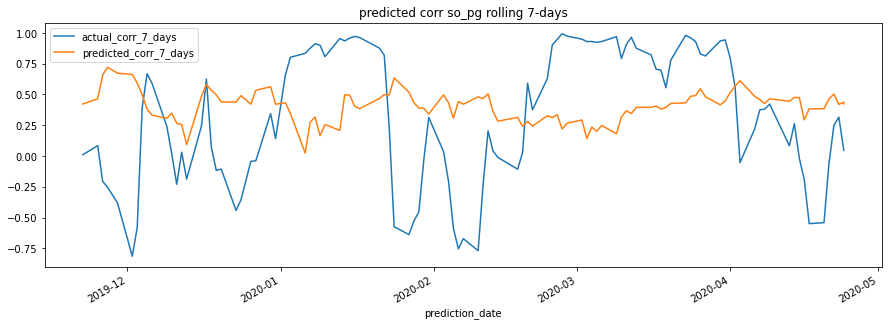

In [368]:
hist_predictions_df.set_index('prediction_date')[['actual_corr_7_days', 'predicted_corr_7_days']].plot(title='predicted corr so_pg rolling 7-days', figsize=(15,5))

In [369]:
np.sqrt(mean_squared_error(hist_predictions_df.actual_corr_7_days, hist_predictions_df.predicted_corr_7_days)) # rf

0.5983480796043728

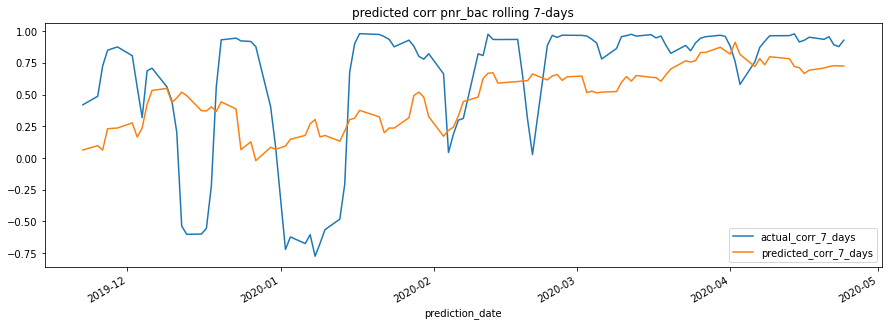

In [325]:
hist_predictions_df.set_index('prediction_date')[['actual_corr_7_days', 'predicted_corr_7_days']].plot(title='predicted corr pnr_bac rolling 7-days', figsize=(15,5))

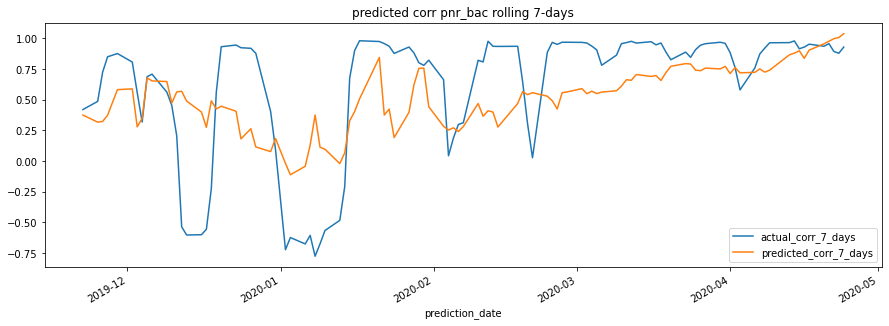

In [312]:
# svm rfb kernel
hist_predictions_df.set_index('prediction_date')[['actual_corr_7_days', 'predicted_corr_7_days']].plot(title='predicted corr pnr_bac rolling 7-days', figsize=(15,5))

In [510]:
prediction_df.index

DatetimeIndex(['2019-11-20', '2019-11-21', '2019-11-22', '2019-11-25',
               '2019-11-26', '2019-11-27', '2019-11-29', '2019-12-02',
               '2019-12-03', '2019-12-04',
               ...
               '2020-04-03', '2020-04-06', '2020-04-07', '2020-04-08',
               '2020-04-09', '2020-04-13', '2020-04-14', '2020-04-15',
               '2020-04-16', '2020-04-16'],
              dtype='datetime64[ns]', name='prediction_date', length=102, freq=None)

## Feature Importances
- nit: only based on last tree fit

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14]),
 <a list of 15 Text major ticklabel objects>)

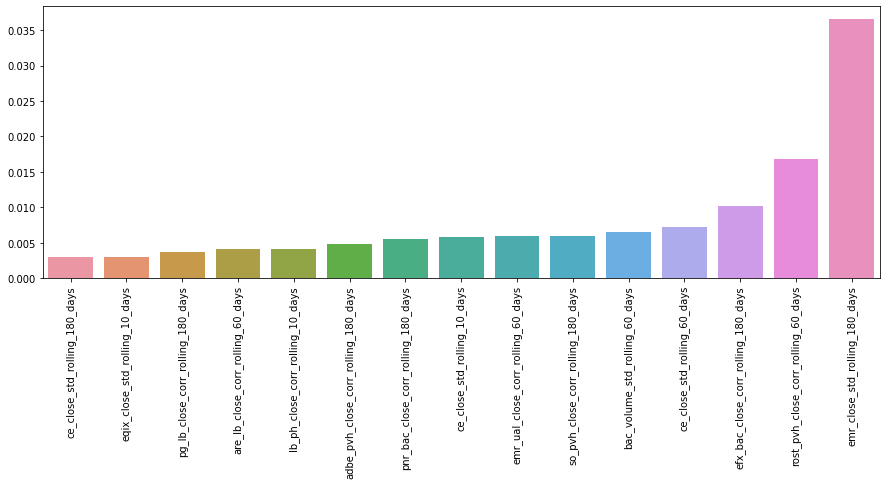

In [1301]:
cols = list(final_stock_df.columns)
cols.remove('pnr_bac_close_corr_rolling_7_days')

plt.figure(figsize=(15,5))
sns.barplot(x=np.array(cols)[np.argsort(rf.feature_importances_)][-15:], y=rf.feature_importances_[np.argsort(rf.feature_importances_)][-15:])
plt.xticks(rotation=90)

# given all feature, predict next 7-days for each stock pair

In [1182]:
final_stock_df.pnr_bac_close_corr_rolling_3_days.shift(-1).fillna(method='ffill')

date
2006-01-25    0.151438
2006-01-26    0.263368
2006-01-27   -0.675648
2006-01-30   -0.245173
2006-01-31    0.848353
                ...   
2020-04-20    0.928298
2020-04-21    0.979311
2020-04-22    0.992304
2020-04-23    0.985425
2020-04-24    0.985425
Name: pnr_bac_close_corr_rolling_3_days, Length: 3586, dtype: float64

In [1013]:
np.nan_to_num(final_stock_df.astype(np.float32)

array([[1.609430e-01, 8.503500e-02, 3.168980e-01, ..., 1.000000e+00,
        1.000000e+00, 2.006000e+03],
       [1.514380e-01, 8.503500e-02, 3.126760e-01, ..., 1.000000e+00,
        1.000000e+00, 2.006000e+03],
       [2.633680e-01, 6.827510e-01, 1.288730e-01, ..., 1.000000e+00,
        1.000000e+00, 2.006000e+03],
       ...,
       [6.691380e-01, 5.577040e-01, 9.487360e-01, ..., 4.000000e+00,
        2.000000e+00, 2.020000e+03],
       [9.991570e-01, 8.747000e-01, 1.176194e+00, ..., 4.000000e+00,
        2.000000e+00, 2.020000e+03],
       [9.890840e-01, 5.907060e-01, 9.345770e-01, ..., 4.000000e+00,
        2.000000e+00, 2.020000e+03]], dtype=float32)

- build predicted 7 day corr for each pair

In [1170]:
# remove all 7_days_corr columns ex: so_rost_close_corr_rolling_7_days
### format: f"{first_stock_name}_{second_stock_name}_close_corr_rolling_{n_days_stride}_days"
# using all data up until the last day, predict 7-day corr for each stock pair

In [ ]:
# undefined
find_pct_change_pred_vs_last_corr

In [392]:
final_stock_df.index.max() # what is the max date?

Timestamp('2020-04-27 00:00:00')

In [393]:
final_stock_df.index.min()

Timestamp('2017-03-16 00:00:00')

In [1193]:
def most_recent_week_historical_prediction(final_stock_df):
    """
    Take the most recent week of data and use that to predict against 
    """

    test_date = final_stock_df.index.max() - datetime.timedelta(7)
    train_dates = final_stock_df.index[final_stock_df.index < test_date - datetime.timedelta(14)] # 14 days before

    train_df = final_stock_df[final_stock_df.index.isin(train_dates)]
    test_df = final_stock_df[final_stock_df.index == test_date]


    final_stock_df = final_stock_df.dropna()

    n_days_corr_predictions = 7


    pct_change_corr = []
    actual_corr = []
    predicted_corr = []
    last_corr_for_prediction_day = []
    pred_dates = []
    start = time.time()

    for stock_pairing in pairs_of_stocks:
        pred_col_name = f"{stock_pairing}_close_corr_rolling_{n_days_corr_predictions}_days"

        # remove the current 7-day corr for this stock
        # we can't use  test_X data because we will not have access to it
        train_X, train_y = train_df.loc[:, train_df.columns != f"{pred_col_name}"],  train_df[f"{pred_col_name}"].shift(-7).fillna(method='ffill')# shift back 7 days to get rolling corr
        
        test_X, test_y = test_df.loc[:, test_df.columns != f"{pred_col_name}"],  test_df[f"{pred_col_name}"].shift(-7).fillna(method='ffill') # test has the date we want to predict against


        train_X = np.nan_to_num(train_X.astype(np.float32)) 

        # standard scaler for cols
        scaler=StandardScaler()
        scaler.fit(train_X)
        train_X = scaler.transform(train_X)
        test_X = scaler.transform(test_X)


        # Make an instance of the Model
        # only train on train_x

        pca = PCA(.60, whiten=True)
        pca.fit(train_X)

        train_X = pca.transform(train_X)
        test_X = pca.transform(test_X)
        # standaard scaler
        
        estimator_two = RandomForestRegressor(n_jobs=-1)
        estimator_one = SVR(C=.5, kernel='rbf')

        estimator_one.fit(X_train, y_train)
        estimator_two.fit(X_train, y_train)

        prediction_one = estimator_one.predict(X_test)
        prediction_two = estimator_two.predict(X_test)
        prediction = np.mean([prediction_one[0], prediction_two[0] ])


        print(f"Stocks {stock_pairing}")
        print(f"Prediction = {prediction}")
        print(f"Actual = {test_y.values[0]}")

        pred_corr_pct_change, last_date = find_pct_change_pred_vs_last_corr(train_y, prediction)

        last_corr_date = train_y.index.max()
        last_corr = train_y[train_y.index.max()]    

        pct_change_corr.append(pred_corr_pct_change)
        pred_dates.append(last_date)
        actual_corr.append(test_y.values[0])
        predicted_corr.append(prediction)
        last_corr_for_prediction_day.append(last_corr)

        print(f"{stock_pairing} pct change 7-day corr of close from {last_date} to {test_date} is =  {pred_corr_pct_change}")


    end = time.time()

    print(f"Predictions took {(end-start)/60} mins")
    
    pd.DataFrame({ 'pred_date_start':pred_dates,'stock_pair':pairs_of_stocks,   'pct_change_for_7_daycorr': pct_change_corr,
    'actual_corr': actual_corr,
    'predicted_corr': predicted_corr, 'last_7_day_corr_for_pred_date_start': last_corr_for_prediction_day}).to_csv(
    '../data/predictions/test_predictions_2020_04_17.csv', index=False)
    


In [1194]:
most_recent_week_historical_prediction(final_stock_df)

/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


ValueError: Number of labels=3586 does not match number of samples=3580

most_recent_week_historical_prediction

# Final Predictions

In [382]:
# add this to predictions
stock_to_industry = pd.read_csv('../data/Industries stock list - all.csv')
stock_to_industry.symbol = [i.lower() for i in stock_to_industry.symbol]

In [ ]:
final_stock_df.date.max() # what is the max date?

In [390]:
# train on all data
# predict for the upcoming week
most_recent_date = final_stock_df.index.max()
prediction_end = most_recent_date + datetime.timedelta(7)
                                                       
                                                       
# train_dates = final_stock_df.index[final_stock_df.index < test_date - datetime.timedelta(7)] # seven days before

# train_df = final_stock_df[final_stock_df.index.isin(train_dates)]
test_df = final_stock_df[final_stock_df.index == most_recent_date]

final_stock_df = final_stock_df.dropna()

n_days_corr_predictions = 7


pct_change_corr = []
predicted_corr = []
last_corr_for_prediction_day = []
pred_dates = []
first_stock_industries = []
second_stock_industries = []

start = time.time()

for stock_pairing in tqdm(pairs_of_stocks, miniters=100):
    first_stock_name, second_stock_name = stock_pairing.split('_')
    
    first_stock_industries.append(stock_to_industry[stock_to_industry.symbol == first_stock_name].industry)
    second_stock_industries.append(stock_to_industry[stock_to_industry.symbol == first_stock_name].industry)
    

    
    pred_col_name = f"{stock_pairing}_close_corr_rolling_{n_days_corr_predictions}_days"

    # remove the current 7-day corr for this stock
    # for 7 take rolling 7 days corr to the present day to predict off of
    train_X, train_y = final_stock_df.loc[:, final_stock_df.columns != f"{pred_col_name}"],  final_stock_df[f"{pred_col_name}"].shift(-7).fillna(method='ffill') 
                                                       # get corr from 7 days in the future
                                                       
    test_X, test_y = test_df.loc[:, test_df.columns != f"{pred_col_name}"],  test_df[f"{pred_col_name}"]

    train_X = np.nan_to_num(train_X.astype(np.float32)) 
    test_X = np.nan_to_num(test_X.astype(np.float32)) 

    # standard scaler for cols
    scaler=StandardScaler()
    scaler.fit(train_X)
    train_X = scaler.transform(train_X)
    test_X = scaler.transform(test_X)


    # Make an instance of the Model
    # only train on train_x

    pca = PCA(.60, whiten=True)
    pca.fit(train_X)

    train_X = pca.transform(train_X)
    test_X = pca.transform(test_X)

    # standaard scaler
        
    estimator_two = RandomForestRegressor(n_jobs=-1)
    estimator_one = SVR(C=.5, kernel='rbf')

    estimator_one.fit(train_X, train_y)
    estimator_two.fit(train_X, train_y)

    prediction_one = estimator_one.predict(test_X)
    prediction_two = estimator_two.predict(test_X)
    prediction = np.mean([prediction_one[0], prediction_two[0] ])


    print(f"Stocks {stock_pairing}")
    print(f"Prediction = {prediction}")


    last_corr_date = train_y.index.max()
    last_corr = train_y[train_y.index.max()]  
    print(f"Last corr = {last_corr}")

    pred_dates.append(most_recent_date)
    predicted_corr.append(prediction)
    last_corr_for_prediction_day.append(last_corr)

    print(f"{stock_pairing} corr7-day corr of close from {most_recent_date} to {prediction_end} is {prediction} ")


end = time.time()

print(f"Predictions took {(end-start)/60} mins")
          
squarred_difference = (np.array(last_corr_for_prediction_day)-np.array(predicted_corr))**2

pd.DataFrame({ 'pred_date_start':pred_dates,'stock_pair':pairs_of_stocks,   'first_stock_industry': first_stock_industries, 
               'second_stock_industry': second_stock_industries,
               'predicted_corr': predicted_corr, 'last_7_day_corr_for_pred_date_start': last_corr_for_prediction_day, 
        'squarred_diff_7_day_cor': (np.array(last_corr_for_prediction_day)-np.array(predicted_corr))**2
             }).to_csv(
f'../data/predictions/test_predictions_{most_recent_date}-{prediction_end}.csv', index=False)


  0%|          | 0/1128 [00:00<?, ?it/s]/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
  0%|          | 1/1128 [00:01<29:03,  1.55s/it]

Stocks bjk_bke
Prediction = 0.6404028635965338
Last corr = 0.693839
bjk_bke corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.6404028635965338 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
  0%|          | 2/1128 [00:03<29:30,  1.57s/it]

Stocks bjk_dds
Prediction = 0.6331387895375566
Last corr = 0.767591
bjk_dds corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.6331387895375566 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
  0%|          | 3/1128 [00:04<29:54,  1.59s/it]

Stocks bjk_aeo
Prediction = 0.22905382070447627
Last corr = 0.224082
bjk_aeo corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.22905382070447627 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
  0%|          | 4/1128 [00:06<30:49,  1.65s/it]

Stocks bjk_so
Prediction = 0.6760872116967336
Last corr = 0.747975
bjk_so corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.6760872116967336 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
  0%|          | 5/1128 [00:08<31:40,  1.69s/it]

Stocks bjk_urbn
Prediction = 0.32121311957894194
Last corr = 0.276244
bjk_urbn corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.32121311957894194 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
  1%|          | 6/1128 [00:10<31:32,  1.69s/it]

Stocks bjk_xrt
Prediction = 0.878188730014569
Last corr = 0.920421
bjk_xrt corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.878188730014569 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
  1%|          | 7/1128 [00:12<33:06,  1.77s/it]

Stocks bjk_eqix
Prediction = 0.7446929091628689
Last corr = 0.807072
bjk_eqix corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.7446929091628689 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
  1%|          | 8/1128 [00:13<33:21,  1.79s/it]

Stocks bjk_tjx
Prediction = 0.5743328982598429
Last corr = 0.612044
bjk_tjx corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.5743328982598429 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
  1%|          | 9/1128 [00:15<33:33,  1.80s/it]

Stocks bjk_dia
Prediction = 0.8872861714545995
Last corr = 0.91471
bjk_dia corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.8872861714545995 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
  1%|          | 10/1128 [00:17<32:22,  1.74s/it]

Stocks bjk_lb
Prediction = 0.279310786008233
Last corr = 0.268355
bjk_lb corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.279310786008233 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
  1%|          | 11/1128 [00:19<33:11,  1.78s/it]

Stocks bjk_m
Prediction = 0.5376134146853133
Last corr = 0.596653
bjk_m corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.5376134146853133 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
  1%|          | 12/1128 [00:20<32:03,  1.72s/it]

Stocks bjk_gps
Prediction = 0.4537764944923134
Last corr = 0.442124
bjk_gps corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.4537764944923134 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
  1%|          | 13/1128 [00:22<31:13,  1.68s/it]

Stocks bjk_cato
Prediction = 0.5138317038294653
Last corr = 0.571252
bjk_cato corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.5138317038294653 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
  1%|          | 14/1128 [00:23<30:36,  1.65s/it]

Stocks bjk_pej
Prediction = 0.9152326176982941
Last corr = 0.974787
bjk_pej corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.9152326176982941 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
  1%|▏         | 15/1128 [00:25<30:18,  1.63s/it]

Stocks bjk_scvl
Prediction = 0.6002774380989141
Last corr = 0.623113
bjk_scvl corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.6002774380989141 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
  1%|▏         | 16/1128 [00:27<30:02,  1.62s/it]

Stocks bjk_spwh
Prediction = 0.6671478441008798
Last corr = 0.748663
bjk_spwh corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.6671478441008798 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
  2%|▏         | 17/1128 [00:29<35:10,  1.90s/it]

Stocks bjk_jwn
Prediction = 0.8202700601620603
Last corr = 0.966315
bjk_jwn corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.8202700601620603 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
  2%|▏         | 18/1128 [00:31<33:36,  1.82s/it]

Stocks bjk_tpr
Prediction = 0.7082336739005082
Last corr = 0.81976
bjk_tpr corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.7082336739005082 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
  2%|▏         | 19/1128 [00:33<37:21,  2.02s/it]

Stocks bjk_fl
Prediction = 0.6509615018138821
Last corr = 0.750508
bjk_fl corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.6509615018138821 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
  2%|▏         | 20/1128 [00:35<35:03,  1.90s/it]

Stocks bjk_ce
Prediction = 0.7007299159988201
Last corr = 0.766725
bjk_ce corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.7007299159988201 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
  2%|▏         | 21/1128 [00:37<34:27,  1.87s/it]

Stocks bjk_atvi
Prediction = 0.5228854929762979
Last corr = 0.582298
bjk_atvi corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.5228854929762979 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
  2%|▏         | 22/1128 [00:38<33:31,  1.82s/it]

Stocks bjk_goos
Prediction = 0.8062287977453928
Last corr = 0.88953
bjk_goos corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.8062287977453928 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
  2%|▏         | 23/1128 [00:40<32:40,  1.77s/it]

Stocks bjk_peg
Prediction = 0.6333776691169257
Last corr = 0.629107
bjk_peg corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.6333776691169257 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
  2%|▏         | 24/1128 [00:42<33:07,  1.80s/it]

Stocks bjk_vfh
Prediction = 0.8214825881591015
Last corr = 0.913988
bjk_vfh corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.8214825881591015 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
  2%|▏         | 25/1128 [00:44<32:54,  1.79s/it]

Stocks bjk_adbe
Prediction = 0.7751426778753037
Last corr = 0.854028
bjk_adbe corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.7751426778753037 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
  2%|▏         | 26/1128 [00:45<32:09,  1.75s/it]

Stocks bjk_anf
Prediction = 0.5527582672882022
Last corr = 0.597029
bjk_anf corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.5527582672882022 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
  2%|▏         | 27/1128 [00:47<31:16,  1.70s/it]

Stocks bjk_gco
Prediction = 0.651465917041881
Last corr = 0.709664
bjk_gco corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.651465917041881 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
  2%|▏         | 28/1128 [00:48<30:27,  1.66s/it]

Stocks bjk_ctrn
Prediction = 0.5004546198057194
Last corr = 0.455398
bjk_ctrn corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.5004546198057194 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
  3%|▎         | 29/1128 [00:50<31:08,  1.70s/it]

Stocks bjk_pg
Prediction = 0.11232245348544267
Last corr = 0.031896
bjk_pg corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.11232245348544267 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
  3%|▎         | 30/1128 [00:52<31:38,  1.73s/it]

Stocks bjk_pvh
Prediction = 0.7811733926318299
Last corr = 0.927924
bjk_pvh corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.7811733926318299 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
  3%|▎         | 31/1128 [00:54<31:35,  1.73s/it]

Stocks bjk_iwm
Prediction = 0.9041873329817045
Last corr = 0.945487
bjk_iwm corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.9041873329817045 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
  3%|▎         | 32/1128 [00:55<30:51,  1.69s/it]

Stocks bjk_rop
Prediction = 0.40762063962304784
Last corr = 0.339464
bjk_rop corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.40762063962304784 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
  3%|▎         | 33/1128 [00:57<31:42,  1.74s/it]

Stocks bjk_boot
Prediction = 0.8321243410926693
Last corr = 0.915903
bjk_boot corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.8321243410926693 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
  3%|▎         | 34/1128 [00:59<31:04,  1.70s/it]

Stocks bjk_are
Prediction = 0.5313219378480486
Last corr = 0.515432
bjk_are corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.5313219378480486 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
  3%|▎         | 35/1128 [01:00<30:30,  1.67s/it]

Stocks bjk_ph
Prediction = 0.8334359583132427
Last corr = 0.955444
bjk_ph corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.8334359583132427 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
  3%|▎         | 36/1128 [01:02<30:50,  1.69s/it]

Stocks bjk_rost
Prediction = 0.7897892706155236
Last corr = 0.84843
bjk_rost corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.7897892706155236 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
  3%|▎         | 37/1128 [01:04<30:13,  1.66s/it]

Stocks bjk_vno
Prediction = 0.7613919803809344
Last corr = 0.821511
bjk_vno corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.7613919803809344 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
  3%|▎         | 38/1128 [01:06<30:22,  1.67s/it]

Stocks bjk_spy
Prediction = 0.9129754946278021
Last corr = 0.925117
bjk_spy corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.9129754946278021 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
  3%|▎         | 39/1128 [01:07<30:10,  1.66s/it]

Stocks bjk_ual
Prediction = -0.11054499200676904
Last corr = -0.201254
bjk_ual corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is -0.11054499200676904 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
  4%|▎         | 40/1128 [01:09<30:00,  1.66s/it]

Stocks bjk_efx
Prediction = 0.4250457924123173
Last corr = 0.410458
bjk_efx corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.4250457924123173 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
  4%|▎         | 41/1128 [01:10<29:50,  1.65s/it]

Stocks bjk_pbj
Prediction = 0.7976397680419083
Last corr = 0.851845
bjk_pbj corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.7976397680419083 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
  4%|▎         | 42/1128 [01:12<30:05,  1.66s/it]

Stocks bjk_vti
Prediction = 0.927441259683583
Last corr = 0.942894
bjk_vti corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.927441259683583 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
  4%|▍         | 43/1128 [01:14<29:46,  1.65s/it]

Stocks bjk_bac
Prediction = 0.8243718279635065
Last corr = 0.920196
bjk_bac corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.8243718279635065 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
  4%|▍         | 44/1128 [01:15<30:08,  1.67s/it]

Stocks bjk_ni
Prediction = 0.6529943681227962
Last corr = 0.717255
bjk_ni corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.6529943681227962 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
  4%|▍         | 45/1128 [01:17<29:42,  1.65s/it]

Stocks bjk_kss
Prediction = 0.7081652809725059
Last corr = 0.779907
bjk_kss corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.7081652809725059 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
  4%|▍         | 46/1128 [01:19<29:21,  1.63s/it]

Stocks bjk_qqq
Prediction = 0.8004619295785081
Last corr = 0.867077
bjk_qqq corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.8004619295785081 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
  4%|▍         | 47/1128 [01:20<28:59,  1.61s/it]

Stocks bjk_pnr
Prediction = 0.8385100349351082
Last corr = 0.960269
bjk_pnr corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.8385100349351082 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
  4%|▍         | 48/1128 [01:22<28:49,  1.60s/it]

Stocks bke_dds
Prediction = 0.683852163504731
Last corr = 0.726366
bke_dds corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.683852163504731 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
  4%|▍         | 49/1128 [01:23<29:00,  1.61s/it]

Stocks bke_aeo
Prediction = 0.8287613288107983
Last corr = 0.817786
bke_aeo corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.8287613288107983 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
  4%|▍         | 50/1128 [01:25<28:47,  1.60s/it]

Stocks bke_so
Prediction = 0.33906156788392955
Last corr = 0.313243
bke_so corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.33906156788392955 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
  5%|▍         | 51/1128 [01:27<28:41,  1.60s/it]

Stocks bke_urbn
Prediction = 0.8677672514159225
Last corr = 0.864237
bke_urbn corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.8677672514159225 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
  5%|▍         | 52/1128 [01:28<29:05,  1.62s/it]

Stocks bke_xrt
Prediction = 0.5836039601893332
Last corr = 0.590253
bke_xrt corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.5836039601893332 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
  5%|▍         | 53/1128 [01:30<29:28,  1.65s/it]

Stocks bke_eqix
Prediction = 0.45016197684683956
Last corr = 0.496342
bke_eqix corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.45016197684683956 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
  5%|▍         | 54/1128 [01:32<30:12,  1.69s/it]

Stocks bke_tjx
Prediction = 0.8885492560654494
Last corr = 0.937621
bke_tjx corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.8885492560654494 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
  5%|▍         | 55/1128 [01:33<30:26,  1.70s/it]

Stocks bke_dia
Prediction = 0.6888294468372667
Last corr = 0.747498
bke_dia corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.6888294468372667 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
  5%|▍         | 56/1128 [01:35<31:03,  1.74s/it]

Stocks bke_lb
Prediction = 0.805810607143261
Last corr = 0.836151
bke_lb corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.805810607143261 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
  5%|▌         | 57/1128 [01:37<30:17,  1.70s/it]

Stocks bke_m
Prediction = 0.014160674255304814
Last corr = -0.038709
bke_m corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.014160674255304814 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
  5%|▌         | 58/1128 [01:39<30:50,  1.73s/it]

Stocks bke_gps
Prediction = 0.8748638190748359
Last corr = 0.918442
bke_gps corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.8748638190748359 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
  5%|▌         | 59/1128 [01:40<30:59,  1.74s/it]

Stocks bke_cato
Prediction = 0.9063566680981126
Last corr = 0.957771
bke_cato corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.9063566680981126 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
  5%|▌         | 60/1128 [01:42<31:19,  1.76s/it]

Stocks bke_pej
Prediction = 0.7192719348076324
Last corr = 0.797255
bke_pej corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.7192719348076324 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
  5%|▌         | 61/1128 [01:44<31:26,  1.77s/it]

Stocks bke_scvl
Prediction = 0.8909081414870511
Last corr = 0.954685
bke_scvl corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.8909081414870511 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
  5%|▌         | 62/1128 [01:46<31:39,  1.78s/it]

Stocks bke_spwh
Prediction = 0.8473472116986888
Last corr = 0.91615
bke_spwh corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.8473472116986888 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
  6%|▌         | 63/1128 [01:48<31:42,  1.79s/it]

Stocks bke_jwn
Prediction = 0.7067771985975131
Last corr = 0.738753
bke_jwn corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.7067771985975131 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
  6%|▌         | 64/1128 [01:49<30:41,  1.73s/it]

Stocks bke_tpr
Prediction = 0.9001596264317386
Last corr = 0.964649
bke_tpr corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.9001596264317386 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
  6%|▌         | 65/1128 [01:51<30:35,  1.73s/it]

Stocks bke_fl
Prediction = 0.654285509265595
Last corr = 0.615483
bke_fl corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.654285509265595 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
  6%|▌         | 66/1128 [01:53<30:09,  1.70s/it]

Stocks bke_ce
Prediction = 0.271926849452095
Last corr = 0.318275
bke_ce corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.271926849452095 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
  6%|▌         | 67/1128 [01:55<31:48,  1.80s/it]

Stocks bke_atvi
Prediction = 0.34459272627595805
Last corr = 0.449463
bke_atvi corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.34459272627595805 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
  6%|▌         | 68/1128 [01:56<31:04,  1.76s/it]

Stocks bke_goos
Prediction = 0.5159431357946169
Last corr = 0.582245
bke_goos corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.5159431357946169 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
  6%|▌         | 69/1128 [01:58<32:26,  1.84s/it]

Stocks bke_peg
Prediction = 0.8222854660683658
Last corr = 0.853399
bke_peg corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.8222854660683658 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
  6%|▌         | 70/1128 [02:00<31:53,  1.81s/it]

Stocks bke_vfh
Prediction = 0.8254994457413585
Last corr = 0.886961
bke_vfh corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.8254994457413585 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
  6%|▋         | 71/1128 [02:02<31:19,  1.78s/it]

Stocks bke_adbe
Prediction = 0.5050926074024049
Last corr = 0.592713
bke_adbe corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.5050926074024049 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
  6%|▋         | 72/1128 [02:04<31:35,  1.80s/it]

Stocks bke_anf
Prediction = 0.9376709907284696
Last corr = 0.971714
bke_anf corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.9376709907284696 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
  6%|▋         | 73/1128 [02:06<32:01,  1.82s/it]

Stocks bke_gco
Prediction = 0.9287471660990732
Last corr = 0.940831
bke_gco corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.9287471660990732 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
  7%|▋         | 74/1128 [02:07<32:03,  1.82s/it]

Stocks bke_ctrn
Prediction = 0.8645366950947007
Last corr = 0.929811
bke_ctrn corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.8645366950947007 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
  7%|▋         | 75/1128 [02:09<30:47,  1.75s/it]

Stocks bke_pg
Prediction = 0.4743136296674618
Last corr = 0.544787
bke_pg corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.4743136296674618 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
  7%|▋         | 76/1128 [02:11<29:52,  1.70s/it]

Stocks bke_pvh
Prediction = 0.7461669691632283
Last corr = 0.832364
bke_pvh corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.7461669691632283 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
  7%|▋         | 77/1128 [02:12<29:38,  1.69s/it]

Stocks bke_iwm
Prediction = 0.5575742513568384
Last corr = 0.558044
bke_iwm corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.5575742513568384 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
  7%|▋         | 78/1128 [02:14<29:01,  1.66s/it]

Stocks bke_rop
Prediction = 0.5792659428127788
Last corr = 0.640875
bke_rop corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.5792659428127788 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
  7%|▋         | 79/1128 [02:15<28:58,  1.66s/it]

Stocks bke_boot
Prediction = 0.7023330672369658
Last corr = 0.701108
bke_boot corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.7023330672369658 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
  7%|▋         | 80/1128 [02:17<28:49,  1.65s/it]

Stocks bke_are
Prediction = 0.7040846162989588
Last corr = 0.759116
bke_are corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.7040846162989588 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
  7%|▋         | 81/1128 [02:19<28:45,  1.65s/it]

Stocks bke_ph
Prediction = 0.720261916667289
Last corr = 0.785623
bke_ph corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.720261916667289 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
  7%|▋         | 82/1128 [02:20<28:25,  1.63s/it]

Stocks bke_rost
Prediction = 0.8785499787384379
Last corr = 0.932123
bke_rost corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.8785499787384379 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
  7%|▋         | 83/1128 [02:22<28:11,  1.62s/it]

Stocks bke_vno
Prediction = 0.8132286716284413
Last corr = 0.887272
bke_vno corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.8132286716284413 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
  7%|▋         | 84/1128 [02:24<28:13,  1.62s/it]

Stocks bke_spy
Prediction = 0.6077333915973594
Last corr = 0.690037
bke_spy corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.6077333915973594 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
  8%|▊         | 85/1128 [02:25<27:57,  1.61s/it]

Stocks bke_ual
Prediction = 0.4404751736627362
Last corr = 0.50093
bke_ual corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.4404751736627362 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
  8%|▊         | 86/1128 [02:27<27:42,  1.60s/it]

Stocks bke_efx
Prediction = -0.02811061199810221
Last corr = -0.044242
bke_efx corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is -0.02811061199810221 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
  8%|▊         | 87/1128 [02:28<27:35,  1.59s/it]

Stocks bke_pbj
Prediction = 0.5036714161381655
Last corr = 0.52198
bke_pbj corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.5036714161381655 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
  8%|▊         | 88/1128 [02:30<27:27,  1.58s/it]

Stocks bke_vti
Prediction = 0.6159204190660508
Last corr = 0.671364
bke_vti corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.6159204190660508 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
  8%|▊         | 89/1128 [02:31<27:22,  1.58s/it]

Stocks bke_bac
Prediction = 0.8361257288451984
Last corr = 0.900523
bke_bac corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.8361257288451984 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
  8%|▊         | 90/1128 [02:33<27:34,  1.59s/it]

Stocks bke_ni
Prediction = 0.5081227092602008
Last corr = 0.480064
bke_ni corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.5081227092602008 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
  8%|▊         | 91/1128 [02:35<27:24,  1.59s/it]

Stocks bke_kss
Prediction = 0.9159873862513187
Last corr = 0.951173
bke_kss corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.9159873862513187 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
  8%|▊         | 92/1128 [02:36<27:29,  1.59s/it]

Stocks bke_qqq
Prediction = 0.4780992318142941
Last corr = 0.565055
bke_qqq corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.4780992318142941 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
  8%|▊         | 93/1128 [02:38<27:25,  1.59s/it]

Stocks bke_pnr
Prediction = 0.5877034182860402
Last corr = 0.611466
bke_pnr corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.5877034182860402 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
  8%|▊         | 94/1128 [02:39<27:27,  1.59s/it]

Stocks dds_aeo
Prediction = 0.46819296706718116
Last corr = 0.457041
dds_aeo corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.46819296706718116 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
  8%|▊         | 95/1128 [02:41<27:24,  1.59s/it]

Stocks dds_so
Prediction = 0.45622039512337964
Last corr = 0.499188
dds_so corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.45622039512337964 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
  9%|▊         | 96/1128 [02:43<27:30,  1.60s/it]

Stocks dds_urbn
Prediction = 0.35690834300386354
Last corr = 0.384262
dds_urbn corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.35690834300386354 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
  9%|▊         | 97/1128 [02:44<27:22,  1.59s/it]

Stocks dds_xrt
Prediction = 0.6449089188096556
Last corr = 0.730152
dds_xrt corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.6449089188096556 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
  9%|▊         | 98/1128 [02:46<27:12,  1.58s/it]

Stocks dds_eqix
Prediction = 0.5229028333537749
Last corr = 0.603085
dds_eqix corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.5229028333537749 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
  9%|▉         | 99/1128 [02:47<27:09,  1.58s/it]

Stocks dds_tjx
Prediction = 0.4680679337673176
Last corr = 0.481077
dds_tjx corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.4680679337673176 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
  9%|▉         | 100/1128 [02:49<27:06,  1.58s/it]

Stocks dds_dia
Prediction = 0.5029969778220722
Last corr = 0.605863
dds_dia corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.5029969778220722 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
  9%|▉         | 101/1128 [02:50<27:04,  1.58s/it]

Stocks dds_lb
Prediction = 0.5123032028349935
Last corr = 0.456352
dds_lb corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.5123032028349935 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
  9%|▉         | 102/1128 [02:52<27:07,  1.59s/it]

Stocks dds_m
Prediction = 0.421315418130767
Last corr = 0.39474
dds_m corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.421315418130767 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
  9%|▉         | 103/1128 [02:54<27:16,  1.60s/it]

Stocks dds_gps
Prediction = 0.5176445750260968
Last corr = 0.50882
dds_gps corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.5176445750260968 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
  9%|▉         | 104/1128 [02:55<27:10,  1.59s/it]

Stocks dds_cato
Prediction = 0.5026875883894918
Last corr = 0.536601
dds_cato corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.5026875883894918 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
  9%|▉         | 105/1128 [02:57<27:06,  1.59s/it]

Stocks dds_pej
Prediction = 0.6632277623308902
Last corr = 0.745704
dds_pej corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.6632277623308902 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
  9%|▉         | 106/1128 [02:58<27:06,  1.59s/it]

Stocks dds_scvl
Prediction = 0.558376399422676
Last corr = 0.632216
dds_scvl corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.558376399422676 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
  9%|▉         | 107/1128 [03:00<27:03,  1.59s/it]

Stocks dds_spwh
Prediction = 0.6112001558212039
Last corr = 0.744498
dds_spwh corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.6112001558212039 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 10%|▉         | 108/1128 [03:02<27:04,  1.59s/it]

Stocks dds_jwn
Prediction = 0.7920034413876118
Last corr = 0.876526
dds_jwn corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.7920034413876118 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 10%|▉         | 109/1128 [03:03<27:11,  1.60s/it]

Stocks dds_tpr
Prediction = 0.7178815664095097
Last corr = 0.786656
dds_tpr corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.7178815664095097 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 10%|▉         | 110/1128 [03:05<27:02,  1.59s/it]

Stocks dds_fl
Prediction = 0.7719362652019695
Last corr = 0.848751
dds_fl corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.7719362652019695 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 10%|▉         | 111/1128 [03:06<26:56,  1.59s/it]

Stocks dds_ce
Prediction = 0.4783845410146232
Last corr = 0.555062
dds_ce corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.4783845410146232 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 10%|▉         | 112/1128 [03:08<26:57,  1.59s/it]

Stocks dds_atvi
Prediction = 0.0097160735129589
Last corr = 0.104101
dds_atvi corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.0097160735129589 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 10%|█         | 113/1128 [03:10<26:54,  1.59s/it]

Stocks dds_goos
Prediction = 0.4718009492616259
Last corr = 0.563083
dds_goos corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.4718009492616259 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 10%|█         | 114/1128 [03:11<26:50,  1.59s/it]

Stocks dds_peg
Prediction = 0.39757193686271264
Last corr = 0.450885
dds_peg corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.39757193686271264 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 10%|█         | 115/1128 [03:13<26:46,  1.59s/it]

Stocks dds_vfh
Prediction = 0.6408634378386044
Last corr = 0.702954
dds_vfh corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.6408634378386044 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 10%|█         | 116/1128 [03:15<27:47,  1.65s/it]

Stocks dds_adbe
Prediction = 0.3503028456064824
Last corr = 0.458247
dds_adbe corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.3503028456064824 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 10%|█         | 117/1128 [03:16<27:43,  1.65s/it]

Stocks dds_anf
Prediction = 0.5878327569578848
Last corr = 0.617334
dds_anf corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.5878327569578848 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 10%|█         | 118/1128 [03:18<28:18,  1.68s/it]

Stocks dds_gco
Prediction = 0.6879204319136578
Last corr = 0.733962
dds_gco corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.6879204319136578 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 11%|█         | 119/1128 [03:20<27:54,  1.66s/it]

Stocks dds_ctrn
Prediction = 0.3684805121219362
Last corr = 0.439105
dds_ctrn corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.3684805121219362 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 11%|█         | 120/1128 [03:21<27:28,  1.64s/it]

Stocks dds_pg
Prediction = 0.047946451724912534
Last corr = 0.103314
dds_pg corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.047946451724912534 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 11%|█         | 121/1128 [03:23<27:14,  1.62s/it]

Stocks dds_pvh
Prediction = 0.7981546768628713
Last corr = 0.81814
dds_pvh corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.7981546768628713 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 11%|█         | 122/1128 [03:24<27:08,  1.62s/it]

Stocks dds_iwm
Prediction = 0.6329587570387267
Last corr = 0.710309
dds_iwm corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.6329587570387267 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 11%|█         | 123/1128 [03:26<26:51,  1.60s/it]

Stocks dds_rop
Prediction = 0.09348405814684431
Last corr = 0.117109
dds_rop corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.09348405814684431 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 11%|█         | 124/1128 [03:27<26:43,  1.60s/it]

Stocks dds_boot
Prediction = 0.7653937314052923
Last corr = 0.844404
dds_boot corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.7653937314052923 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 11%|█         | 125/1128 [03:29<26:35,  1.59s/it]

Stocks dds_are
Prediction = 0.18325846739361207
Last corr = 0.239845
dds_are corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.18325846739361207 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 11%|█         | 126/1128 [03:31<26:26,  1.58s/it]

Stocks dds_ph
Prediction = 0.6822658843838816
Last corr = 0.723993
dds_ph corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.6822658843838816 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 11%|█▏        | 127/1128 [03:32<26:24,  1.58s/it]

Stocks dds_rost
Prediction = 0.5793140918568144
Last corr = 0.683081
dds_rost corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.5793140918568144 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 11%|█▏        | 128/1128 [03:34<26:34,  1.59s/it]

Stocks dds_vno
Prediction = 0.5747320695507259
Last corr = 0.643716
dds_vno corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.5747320695507259 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 11%|█▏        | 129/1128 [03:35<26:36,  1.60s/it]

Stocks dds_spy
Prediction = 0.5012232328825522
Last corr = 0.569657
dds_spy corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.5012232328825522 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 12%|█▏        | 130/1128 [03:37<26:29,  1.59s/it]

Stocks dds_ual
Prediction = 0.06495751425906882
Last corr = 0.061538
dds_ual corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.06495751425906882 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 12%|█▏        | 131/1128 [03:39<26:23,  1.59s/it]

Stocks dds_efx
Prediction = 0.24637469109304472
Last corr = 0.311468
dds_efx corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.24637469109304472 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 12%|█▏        | 132/1128 [03:40<26:23,  1.59s/it]

Stocks dds_pbj
Prediction = 0.34124679967750615
Last corr = 0.414555
dds_pbj corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.34124679967750615 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 12%|█▏        | 133/1128 [03:42<26:19,  1.59s/it]

Stocks dds_vti
Prediction = 0.5196045658655541
Last corr = 0.587006
dds_vti corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.5196045658655541 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 12%|█▏        | 134/1128 [03:43<26:22,  1.59s/it]

Stocks dds_bac
Prediction = 0.6615983261085812
Last corr = 0.735584
dds_bac corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.6615983261085812 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 12%|█▏        | 135/1128 [03:45<26:40,  1.61s/it]

Stocks dds_ni
Prediction = 0.33261673231825684
Last corr = 0.442735
dds_ni corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.33261673231825684 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 12%|█▏        | 136/1128 [03:47<26:29,  1.60s/it]

Stocks dds_kss
Prediction = 0.6577869430978569
Last corr = 0.804154
dds_kss corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.6577869430978569 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 12%|█▏        | 137/1128 [03:48<26:22,  1.60s/it]

Stocks dds_qqq
Prediction = 0.32781486874918253
Last corr = 0.431763
dds_qqq corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.32781486874918253 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 12%|█▏        | 138/1128 [03:50<26:16,  1.59s/it]

Stocks dds_pnr
Prediction = 0.6062508035751402
Last corr = 0.665115
dds_pnr corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.6062508035751402 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 12%|█▏        | 139/1128 [03:51<26:12,  1.59s/it]

Stocks aeo_so
Prediction = -0.1983086810623148
Last corr = -0.27849
aeo_so corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is -0.1983086810623148 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 12%|█▏        | 140/1128 [03:53<26:41,  1.62s/it]

Stocks aeo_urbn
Prediction = 0.8558092167329365
Last corr = 0.963612
aeo_urbn corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.8558092167329365 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 12%|█▎        | 141/1128 [03:55<26:42,  1.62s/it]

Stocks aeo_xrt
Prediction = 0.14267486331878815
Last corr = 0.093094
aeo_xrt corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.14267486331878815 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 13%|█▎        | 142/1128 [03:56<26:31,  1.61s/it]

Stocks aeo_eqix
Prediction = 0.010978239344172212
Last corr = -0.046024
aeo_eqix corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.010978239344172212 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 13%|█▎        | 143/1128 [03:58<26:20,  1.60s/it]

Stocks aeo_tjx
Prediction = 0.7430299813942833
Last corr = 0.787004
aeo_tjx corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.7430299813942833 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 13%|█▎        | 144/1128 [03:59<26:12,  1.60s/it]

Stocks aeo_dia
Prediction = 0.32750546571074873
Last corr = 0.290397
aeo_dia corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.32750546571074873 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 13%|█▎        | 145/1128 [04:01<26:06,  1.59s/it]

Stocks aeo_lb
Prediction = 0.9178494023073656
Last corr = 0.99271
aeo_lb corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.9178494023073656 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 13%|█▎        | 146/1128 [04:03<25:57,  1.59s/it]

Stocks aeo_m
Prediction = -0.44055964882969345
Last corr = -0.528675
aeo_m corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is -0.44055964882969345 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 13%|█▎        | 147/1128 [04:04<26:12,  1.60s/it]

Stocks aeo_gps
Prediction = 0.8726915015109675
Last corr = 0.943841
aeo_gps corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.8726915015109675 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 13%|█▎        | 148/1128 [04:06<26:02,  1.59s/it]

Stocks aeo_cato
Prediction = 0.8115055963215476
Last corr = 0.885939
aeo_cato corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.8115055963215476 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 13%|█▎        | 149/1128 [04:07<25:58,  1.59s/it]

Stocks aeo_pej
Prediction = 0.35151331850677936
Last corr = 0.344825
aeo_pej corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.35151331850677936 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 13%|█▎        | 150/1128 [04:09<25:56,  1.59s/it]

Stocks aeo_scvl
Prediction = 0.7105656263874132
Last corr = 0.768146
aeo_scvl corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.7105656263874132 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 13%|█▎        | 151/1128 [04:11<26:34,  1.63s/it]

Stocks aeo_spwh
Prediction = 0.6206261480071478
Last corr = 0.682493
aeo_spwh corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.6206261480071478 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 13%|█▎        | 152/1128 [04:13<27:19,  1.68s/it]

Stocks aeo_jwn
Prediction = 0.3162393439012095
Last corr = 0.295423
aeo_jwn corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.3162393439012095 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 14%|█▎        | 153/1128 [04:14<27:13,  1.68s/it]

Stocks aeo_tpr
Prediction = 0.6963377284031304
Last corr = 0.712383
aeo_tpr corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.6963377284031304 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 14%|█▎        | 154/1128 [04:16<28:29,  1.75s/it]

Stocks aeo_fl
Prediction = 0.3060023743813369
Last corr = 0.252319
aeo_fl corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.3060023743813369 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 14%|█▎        | 155/1128 [04:18<28:22,  1.75s/it]

Stocks aeo_ce
Prediction = -0.12096600035328067
Last corr = -0.172722
aeo_ce corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is -0.12096600035328067 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 14%|█▍        | 156/1128 [04:19<27:33,  1.70s/it]

Stocks aeo_atvi
Prediction = -0.05893469111552523
Last corr = -0.010421
aeo_atvi corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is -0.05893469111552523 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 14%|█▍        | 157/1128 [04:21<27:10,  1.68s/it]

Stocks aeo_goos
Prediction = 0.08660286695327805
Last corr = 0.110162
aeo_goos corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.08660286695327805 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 14%|█▍        | 158/1128 [04:23<26:43,  1.65s/it]

Stocks aeo_peg
Prediction = 0.5975012862244067
Last corr = 0.618514
aeo_peg corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.5975012862244067 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 14%|█▍        | 159/1128 [04:24<26:22,  1.63s/it]

Stocks aeo_vfh
Prediction = 0.4833524433343481
Last corr = 0.499563
aeo_vfh corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.4833524433343481 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 14%|█▍        | 160/1128 [04:26<26:24,  1.64s/it]

Stocks aeo_adbe
Prediction = 0.1350128441297692
Last corr = 0.166337
aeo_adbe corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.1350128441297692 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 14%|█▍        | 161/1128 [04:27<26:06,  1.62s/it]

Stocks aeo_anf
Prediction = 0.8156442071474739
Last corr = 0.879213
aeo_anf corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.8156442071474739 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 14%|█▍        | 162/1128 [04:29<25:50,  1.61s/it]

Stocks aeo_gco
Prediction = 0.7310851974840262
Last corr = 0.737501
aeo_gco corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.7310851974840262 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 14%|█▍        | 163/1128 [04:31<25:40,  1.60s/it]

Stocks aeo_ctrn
Prediction = 0.8067532001578939
Last corr = 0.893985
aeo_ctrn corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.8067532001578939 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 15%|█▍        | 164/1128 [04:32<25:33,  1.59s/it]

Stocks aeo_pg
Prediction = 0.6335022355924504
Last corr = 0.707245
aeo_pg corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.6335022355924504 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 15%|█▍        | 165/1128 [04:34<25:31,  1.59s/it]

Stocks aeo_pvh
Prediction = 0.4376951964655151
Last corr = 0.393812
aeo_pvh corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.4376951964655151 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 15%|█▍        | 166/1128 [04:35<25:36,  1.60s/it]

Stocks aeo_iwm
Prediction = 0.08260471229079491
Last corr = 0.035592
aeo_iwm corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.08260471229079491 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 15%|█▍        | 167/1128 [04:37<25:26,  1.59s/it]

Stocks aeo_rop
Prediction = 0.5963213990880865
Last corr = 0.706473
aeo_rop corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.5963213990880865 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 15%|█▍        | 168/1128 [04:39<25:21,  1.59s/it]

Stocks aeo_boot
Prediction = 0.25612023572262677
Last corr = 0.203721
aeo_boot corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.25612023572262677 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 15%|█▍        | 169/1128 [04:40<25:20,  1.59s/it]

Stocks aeo_are
Prediction = 0.496242586951767
Last corr = 0.539894
aeo_are corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.496242586951767 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 15%|█▌        | 170/1128 [04:42<25:21,  1.59s/it]

Stocks aeo_ph
Prediction = 0.33870546953828284
Last corr = 0.304475
aeo_ph corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.33870546953828284 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 15%|█▌        | 171/1128 [04:43<25:16,  1.58s/it]

Stocks aeo_rost
Prediction = 0.5672786202022733
Last corr = 0.571754
aeo_rost corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.5672786202022733 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 15%|█▌        | 172/1128 [04:45<25:27,  1.60s/it]

Stocks aeo_vno
Prediction = 0.5082332732505496
Last corr = 0.551755
aeo_vno corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.5082332732505496 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 15%|█▌        | 173/1128 [04:47<25:19,  1.59s/it]

Stocks aeo_spy
Prediction = 0.22268892039170066
Last corr = 0.209635
aeo_spy corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.22268892039170066 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 15%|█▌        | 174/1128 [04:48<25:14,  1.59s/it]

Stocks aeo_ual
Prediction = 0.7689356125141718
Last corr = 0.859287
aeo_ual corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.7689356125141718 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 16%|█▌        | 175/1128 [04:50<25:08,  1.58s/it]

Stocks aeo_efx
Prediction = -0.4109475518216307
Last corr = -0.483828
aeo_efx corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is -0.4109475518216307 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 16%|█▌        | 176/1128 [04:51<25:06,  1.58s/it]

Stocks aeo_pbj
Prediction = 0.03873816410770009
Last corr = -0.024753
aeo_pbj corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.03873816410770009 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 16%|█▌        | 177/1128 [04:53<25:08,  1.59s/it]

Stocks aeo_vti
Prediction = 0.20144283334053528
Last corr = 0.172371
aeo_vti corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.20144283334053528 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 16%|█▌        | 178/1128 [04:54<25:05,  1.58s/it]

Stocks aeo_bac
Prediction = 0.46477788597501013
Last corr = 0.520221
aeo_bac corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.46477788597501013 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 16%|█▌        | 179/1128 [04:56<25:14,  1.60s/it]

Stocks aeo_ni
Prediction = 0.03188609958242042
Last corr = -0.040997
aeo_ni corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.03188609958242042 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 16%|█▌        | 180/1128 [04:58<25:18,  1.60s/it]

Stocks aeo_kss
Prediction = 0.6863259087514281
Last corr = 0.740983
aeo_kss corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.6863259087514281 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 16%|█▌        | 181/1128 [04:59<25:22,  1.61s/it]

Stocks aeo_qqq
Prediction = 0.08299898933329355
Last corr = 0.08876
aeo_qqq corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.08299898933329355 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 16%|█▌        | 182/1128 [05:01<25:31,  1.62s/it]

Stocks aeo_pnr
Prediction = 0.1936579837733704
Last corr = 0.129009
aeo_pnr corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.1936579837733704 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 16%|█▌        | 183/1128 [05:02<25:14,  1.60s/it]

Stocks so_urbn
Prediction = -0.0921737718156339
Last corr = -0.14958
so_urbn corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is -0.0921737718156339 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 16%|█▋        | 184/1128 [05:04<25:07,  1.60s/it]

Stocks so_xrt
Prediction = 0.6898337352366951
Last corr = 0.76273
so_xrt corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.6898337352366951 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 16%|█▋        | 185/1128 [05:06<25:32,  1.63s/it]

Stocks so_eqix
Prediction = 0.8583916941639484
Last corr = 0.937839
so_eqix corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.8583916941639484 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 16%|█▋        | 186/1128 [05:07<25:15,  1.61s/it]

Stocks so_tjx
Prediction = 0.30289813513141584
Last corr = 0.245138
so_tjx corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.30289813513141584 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 17%|█▋        | 187/1128 [05:09<25:02,  1.60s/it]

Stocks so_dia
Prediction = 0.6635749643397512
Last corr = 0.741322
so_dia corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.6635749643397512 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 17%|█▋        | 188/1128 [05:10<24:55,  1.59s/it]

Stocks so_lb
Prediction = -0.1610795460231254
Last corr = -0.230835
so_lb corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is -0.1610795460231254 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 17%|█▋        | 189/1128 [05:12<24:56,  1.59s/it]

Stocks so_m
Prediction = 0.7250467193579146
Last corr = 0.758915
so_m corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.7250467193579146 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 17%|█▋        | 190/1128 [05:14<24:47,  1.59s/it]

Stocks so_gps
Prediction = 0.0047032829887371265
Last corr = -0.037679
so_gps corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.0047032829887371265 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 17%|█▋        | 191/1128 [05:15<24:42,  1.58s/it]

Stocks so_cato
Prediction = 0.14043597451071047
Last corr = 0.109162
so_cato corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.14043597451071047 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 17%|█▋        | 192/1128 [05:17<24:53,  1.60s/it]

Stocks so_pej
Prediction = 0.66637885130711
Last corr = 0.714055
so_pej corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.66637885130711 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 17%|█▋        | 193/1128 [05:18<24:45,  1.59s/it]

Stocks so_scvl
Prediction = 0.30514339256966105
Last corr = 0.295957
so_scvl corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.30514339256966105 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 17%|█▋        | 194/1128 [05:20<24:40,  1.59s/it]

Stocks so_spwh
Prediction = 0.2854297579383332
Last corr = 0.347967
so_spwh corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.2854297579383332 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 17%|█▋        | 195/1128 [05:22<24:37,  1.58s/it]

Stocks so_jwn
Prediction = 0.6928217851192615
Last corr = 0.720345
so_jwn corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.6928217851192615 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 17%|█▋        | 196/1128 [05:23<24:38,  1.59s/it]

Stocks so_tpr
Prediction = 0.44073407953046445
Last corr = 0.42324
so_tpr corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.44073407953046445 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 17%|█▋        | 197/1128 [05:25<24:32,  1.58s/it]

Stocks so_fl
Prediction = 0.5504468889272199
Last corr = 0.576372
so_fl corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.5504468889272199 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 18%|█▊        | 198/1128 [05:26<24:43,  1.59s/it]

Stocks so_ce
Prediction = 0.6550456022332578
Last corr = 0.741537
so_ce corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.6550456022332578 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 18%|█▊        | 199/1128 [05:28<24:42,  1.60s/it]

Stocks so_atvi
Prediction = 0.5568909203316192
Last corr = 0.691005
so_atvi corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.5568909203316192 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 18%|█▊        | 200/1128 [05:30<24:35,  1.59s/it]

Stocks so_goos
Prediction = 0.6475582449750847
Last corr = 0.704288
so_goos corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.6475582449750847 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 18%|█▊        | 201/1128 [05:31<24:30,  1.59s/it]

Stocks so_peg
Prediction = 0.45666502106104273
Last corr = 0.410105
so_peg corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.45666502106104273 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 18%|█▊        | 202/1128 [05:33<24:24,  1.58s/it]

Stocks so_vfh
Prediction = 0.572600766698944
Last corr = 0.599318
so_vfh corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.572600766698944 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 18%|█▊        | 203/1128 [05:34<24:17,  1.58s/it]

Stocks so_adbe
Prediction = 0.5052915880091355
Last corr = 0.609614
so_adbe corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.5052915880091355 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 18%|█▊        | 204/1128 [05:36<24:27,  1.59s/it]

Stocks so_anf
Prediction = 0.1873819864199068
Last corr = 0.139555
so_anf corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.1873819864199068 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 18%|█▊        | 205/1128 [05:37<24:23,  1.59s/it]

Stocks so_gco
Prediction = 0.36144947089447366
Last corr = 0.317278
so_gco corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.36144947089447366 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 18%|█▊        | 206/1128 [05:39<24:24,  1.59s/it]

Stocks so_ctrn
Prediction = 0.06679490784824593
Last corr = 0.058943
so_ctrn corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.06679490784824593 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 18%|█▊        | 207/1128 [05:41<24:40,  1.61s/it]

Stocks so_pg
Prediction = -0.1927966410629559
Last corr = -0.182913
so_pg corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is -0.1927966410629559 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 18%|█▊        | 208/1128 [05:42<24:31,  1.60s/it]

Stocks so_pvh
Prediction = 0.6841350486338414
Last corr = 0.708662
so_pvh corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.6841350486338414 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 19%|█▊        | 209/1128 [05:44<24:27,  1.60s/it]

Stocks so_iwm
Prediction = 0.7598406508514564
Last corr = 0.81027
so_iwm corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.7598406508514564 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 19%|█▊        | 210/1128 [05:45<24:23,  1.59s/it]

Stocks so_rop
Prediction = -0.08685107370757855
Last corr = -0.139033
so_rop corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is -0.08685107370757855 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 19%|█▊        | 211/1128 [05:47<24:25,  1.60s/it]

Stocks so_boot
Prediction = 0.8000396946785606
Last corr = 0.828056
so_boot corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.8000396946785606 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 19%|█▉        | 212/1128 [05:49<24:19,  1.59s/it]

Stocks so_are
Prediction = 0.317271965099151
Last corr = 0.367221
so_are corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.317271965099151 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 19%|█▉        | 213/1128 [05:50<24:12,  1.59s/it]

Stocks so_ph
Prediction = 0.712012978709516
Last corr = 0.761108
so_ph corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.712012978709516 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 19%|█▉        | 214/1128 [05:52<24:12,  1.59s/it]

Stocks so_rost
Prediction = 0.5287849483023492
Last corr = 0.580194
so_rost corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.5287849483023492 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 19%|█▉        | 215/1128 [05:53<24:13,  1.59s/it]

Stocks so_vno
Prediction = 0.5214470954653969
Last corr = 0.578399
so_vno corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.5214470954653969 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 19%|█▉        | 216/1128 [05:55<24:16,  1.60s/it]

Stocks so_spy
Prediction = 0.6601610829168179
Last corr = 0.758048
so_spy corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.6601610829168179 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 19%|█▉        | 217/1128 [05:57<24:57,  1.64s/it]

Stocks so_ual
Prediction = -0.4095149743230233
Last corr = -0.534887
so_ual corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is -0.4095149743230233 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 19%|█▉        | 218/1128 [05:58<24:44,  1.63s/it]

Stocks so_efx
Prediction = 0.6608194059748063
Last corr = 0.717721
so_efx corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.6608194059748063 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 19%|█▉        | 219/1128 [06:00<24:26,  1.61s/it]

Stocks so_pbj
Prediction = 0.7675222254350293
Last corr = 0.835832
so_pbj corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.7675222254350293 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 20%|█▉        | 220/1128 [06:02<24:16,  1.60s/it]

Stocks so_vti
Prediction = 0.683602209550016
Last corr = 0.781044
so_vti corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.683602209550016 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 20%|█▉        | 221/1128 [06:03<24:07,  1.60s/it]

Stocks so_bac
Prediction = 0.5778332085148776
Last corr = 0.59794
so_bac corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.5778332085148776 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 20%|█▉        | 222/1128 [06:05<23:59,  1.59s/it]

Stocks so_ni
Prediction = 0.8417872571791731
Last corr = 0.91217
so_ni corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.8417872571791731 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 20%|█▉        | 223/1128 [06:06<24:05,  1.60s/it]

Stocks so_kss
Prediction = 0.37219022363268434
Last corr = 0.344473
so_kss corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.37219022363268434 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 20%|█▉        | 224/1128 [06:08<24:09,  1.60s/it]

Stocks so_qqq
Prediction = 0.5905436273184679
Last corr = 0.734367
so_qqq corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.5905436273184679 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 20%|█▉        | 225/1128 [06:10<24:07,  1.60s/it]

Stocks so_pnr
Prediction = 0.6755835679546474
Last corr = 0.728642
so_pnr corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.6755835679546474 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 20%|██        | 226/1128 [06:11<23:57,  1.59s/it]

Stocks urbn_xrt
Prediction = 0.19506025738048044
Last corr = 0.13656
urbn_xrt corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.19506025738048044 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 20%|██        | 227/1128 [06:13<23:53,  1.59s/it]

Stocks urbn_eqix
Prediction = 0.11556699231949655
Last corr = 0.058411
urbn_eqix corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.11556699231949655 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 20%|██        | 228/1128 [06:14<23:50,  1.59s/it]

Stocks urbn_tjx
Prediction = 0.8582132066077005
Last corr = 0.892872
urbn_tjx corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.8582132066077005 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 20%|██        | 229/1128 [06:16<23:51,  1.59s/it]

Stocks urbn_dia
Prediction = 0.4645717184071484
Last corr = 0.428795
urbn_dia corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.4645717184071484 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 20%|██        | 230/1128 [06:17<24:01,  1.61s/it]

Stocks urbn_lb
Prediction = 0.9051955424501102
Last corr = 0.973937
urbn_lb corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.9051955424501102 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 20%|██        | 231/1128 [06:19<23:53,  1.60s/it]

Stocks urbn_m
Prediction = -0.4559765857435573
Last corr = -0.520952
urbn_m corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is -0.4559765857435573 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 21%|██        | 232/1128 [06:21<23:54,  1.60s/it]

Stocks urbn_gps
Prediction = 0.8994175590920721
Last corr = 0.956161
urbn_gps corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.8994175590920721 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 21%|██        | 233/1128 [06:22<23:50,  1.60s/it]

Stocks urbn_cato
Prediction = 0.8850167827562181
Last corr = 0.940725
urbn_cato corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.8850167827562181 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 21%|██        | 234/1128 [06:24<24:11,  1.62s/it]

Stocks urbn_pej
Prediction = 0.46290961275195064
Last corr = 0.41773
urbn_pej corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.46290961275195064 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 21%|██        | 235/1128 [06:26<24:03,  1.62s/it]

Stocks urbn_scvl
Prediction = 0.8836064885979766
Last corr = 0.84813
urbn_scvl corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.8836064885979766 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 21%|██        | 236/1128 [06:27<24:12,  1.63s/it]

Stocks urbn_spwh
Prediction = 0.6516649254524108
Last corr = 0.69293
urbn_spwh corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.6516649254524108 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 21%|██        | 237/1128 [06:29<23:57,  1.61s/it]

Stocks urbn_jwn
Prediction = 0.38194834938607414
Last corr = 0.309116
urbn_jwn corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.38194834938607414 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 21%|██        | 238/1128 [06:30<23:49,  1.61s/it]

Stocks urbn_tpr
Prediction = 0.7098575077206712
Last corr = 0.742011
urbn_tpr corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.7098575077206712 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 21%|██        | 239/1128 [06:32<23:45,  1.60s/it]

Stocks urbn_fl
Prediction = 0.28937744414139155
Last corr = 0.216241
urbn_fl corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.28937744414139155 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 21%|██▏       | 240/1128 [06:34<23:39,  1.60s/it]

Stocks urbn_ce
Prediction = -0.10954510558451032
Last corr = -0.153487
urbn_ce corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is -0.10954510558451032 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 21%|██▏       | 241/1128 [06:35<23:36,  1.60s/it]

Stocks urbn_atvi
Prediction = 0.1500022936248417
Last corr = 0.222807
urbn_atvi corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.1500022936248417 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 21%|██▏       | 242/1128 [06:37<23:38,  1.60s/it]

Stocks urbn_goos
Prediction = 0.21122272490999358
Last corr = 0.176599
urbn_goos corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.21122272490999358 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 22%|██▏       | 243/1128 [06:38<23:44,  1.61s/it]

Stocks urbn_peg
Prediction = 0.738911082914818
Last corr = 0.770193
urbn_peg corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.738911082914818 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 22%|██▏       | 244/1128 [06:40<23:38,  1.60s/it]

Stocks urbn_vfh
Prediction = 0.591596935972728
Last corr = 0.589333
urbn_vfh corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.591596935972728 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 22%|██▏       | 245/1128 [06:42<23:32,  1.60s/it]

Stocks urbn_adbe
Prediction = 0.29203176938029224
Last corr = 0.292733
urbn_adbe corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.29203176938029224 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 22%|██▏       | 246/1128 [06:43<23:51,  1.62s/it]

Stocks urbn_anf
Prediction = 0.8750059737698904
Last corr = 0.907942
urbn_anf corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.8750059737698904 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 22%|██▏       | 247/1128 [06:45<23:52,  1.63s/it]

Stocks urbn_gco
Prediction = 0.8238870136429983
Last corr = 0.78363
urbn_gco corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.8238870136429983 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 22%|██▏       | 248/1128 [06:46<23:42,  1.62s/it]

Stocks urbn_ctrn
Prediction = 0.888712694021188
Last corr = 0.97061
urbn_ctrn corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.888712694021188 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 22%|██▏       | 249/1128 [06:48<24:08,  1.65s/it]

Stocks urbn_pg
Prediction = 0.6872472413375763
Last corr = 0.779074
urbn_pg corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.6872472413375763 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 22%|██▏       | 250/1128 [06:50<24:01,  1.64s/it]

Stocks urbn_pvh
Prediction = 0.4360769042478758
Last corr = 0.44855
urbn_pvh corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.4360769042478758 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 22%|██▏       | 251/1128 [06:51<23:47,  1.63s/it]

Stocks urbn_iwm
Prediction = 0.14511060644087218
Last corr = 0.089192
urbn_iwm corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.14511060644087218 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 22%|██▏       | 252/1128 [06:53<23:37,  1.62s/it]

Stocks urbn_rop
Prediction = 0.6775457864329024
Last corr = 0.761357
urbn_rop corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.6775457864329024 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 22%|██▏       | 253/1128 [06:55<23:30,  1.61s/it]

Stocks urbn_boot
Prediction = 0.3198792543796406
Last corr = 0.262778
urbn_boot corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.3198792543796406 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 23%|██▎       | 254/1128 [06:56<23:20,  1.60s/it]

Stocks urbn_are
Prediction = 0.6784365665508771
Last corr = 0.730482
urbn_are corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.6784365665508771 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 23%|██▎       | 255/1128 [06:58<23:37,  1.62s/it]

Stocks urbn_ph
Prediction = 0.45643274194084094
Last corr = 0.397845
urbn_ph corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.45643274194084094 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 23%|██▎       | 256/1128 [06:59<23:27,  1.61s/it]

Stocks urbn_rost
Prediction = 0.7252005983831353
Last corr = 0.681636
urbn_rost corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.7252005983831353 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 23%|██▎       | 257/1128 [07:01<23:18,  1.61s/it]

Stocks urbn_vno
Prediction = 0.620619345198393
Last corr = 0.666266
urbn_vno corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.620619345198393 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 23%|██▎       | 258/1128 [07:03<23:12,  1.60s/it]

Stocks urbn_spy
Prediction = 0.39414080455710643
Last corr = 0.350562
urbn_spy corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.39414080455710643 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 23%|██▎       | 259/1128 [07:04<23:09,  1.60s/it]

Stocks urbn_ual
Prediction = 0.7903868583937698
Last corr = 0.848551
urbn_ual corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.7903868583937698 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 23%|██▎       | 260/1128 [07:06<23:03,  1.59s/it]

Stocks urbn_efx
Prediction = -0.42714163956642437
Last corr = -0.471263
urbn_efx corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is -0.42714163956642437 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 23%|██▎       | 261/1128 [07:07<23:08,  1.60s/it]

Stocks urbn_pbj
Prediction = 0.23019347781872876
Last corr = 0.142507
urbn_pbj corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.23019347781872876 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 23%|██▎       | 262/1128 [07:09<23:29,  1.63s/it]

Stocks urbn_vti
Prediction = 0.3371911062184782
Last corr = 0.30494
urbn_vti corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.3371911062184782 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 23%|██▎       | 263/1128 [07:11<23:19,  1.62s/it]

Stocks urbn_bac
Prediction = 0.6190227829125499
Last corr = 0.599141
urbn_bac corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.6190227829125499 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 23%|██▎       | 264/1128 [07:12<23:15,  1.62s/it]

Stocks urbn_ni
Prediction = 0.1963852335541545
Last corr = 0.130712
urbn_ni corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.1963852335541545 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 23%|██▎       | 265/1128 [07:14<23:37,  1.64s/it]

Stocks urbn_kss
Prediction = 0.7573815828654407
Last corr = 0.737459
urbn_kss corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.7573815828654407 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 24%|██▎       | 266/1128 [07:16<23:26,  1.63s/it]

Stocks urbn_qqq
Prediction = 0.24513775851565806
Last corr = 0.248491
urbn_qqq corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.24513775851565806 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 24%|██▎       | 267/1128 [07:17<23:13,  1.62s/it]

Stocks urbn_pnr
Prediction = 0.287534706697795
Last corr = 0.202008
urbn_pnr corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.287534706697795 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 24%|██▍       | 268/1128 [07:19<23:16,  1.62s/it]

Stocks xrt_eqix
Prediction = 0.7047286268638353
Last corr = 0.751543
xrt_eqix corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.7047286268638353 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 24%|██▍       | 269/1128 [07:20<23:08,  1.62s/it]

Stocks xrt_tjx
Prediction = 0.4913948145489119
Last corr = 0.439476
xrt_tjx corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.4913948145489119 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 24%|██▍       | 270/1128 [07:22<24:00,  1.68s/it]

Stocks xrt_dia
Prediction = 0.7339754986844444
Last corr = 0.777969
xrt_dia corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.7339754986844444 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 24%|██▍       | 271/1128 [07:24<24:17,  1.70s/it]

Stocks xrt_lb
Prediction = 0.16170890500299157
Last corr = 0.098384
xrt_lb corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.16170890500299157 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 24%|██▍       | 272/1128 [07:26<23:54,  1.68s/it]

Stocks xrt_m
Prediction = 0.6932457036873132
Last corr = 0.766507
xrt_m corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.6932457036873132 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 24%|██▍       | 273/1128 [07:27<24:10,  1.70s/it]

Stocks xrt_gps
Prediction = 0.35382730546033453
Last corr = 0.301244
xrt_gps corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.35382730546033453 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 24%|██▍       | 274/1128 [07:29<23:58,  1.68s/it]

Stocks xrt_cato
Prediction = 0.4335899896969602
Last corr = 0.421944
xrt_cato corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.4335899896969602 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 24%|██▍       | 275/1128 [07:31<23:35,  1.66s/it]

Stocks xrt_pej
Prediction = 0.8606996303081953
Last corr = 0.91586
xrt_pej corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.8606996303081953 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 24%|██▍       | 276/1128 [07:32<23:13,  1.64s/it]

Stocks xrt_scvl
Prediction = 0.6083558180834505
Last corr = 0.588046
xrt_scvl corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.6083558180834505 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 25%|██▍       | 277/1128 [07:34<23:02,  1.62s/it]

Stocks xrt_spwh
Prediction = 0.6854344726081069
Last corr = 0.761147
xrt_spwh corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.6854344726081069 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 25%|██▍       | 278/1128 [07:35<23:13,  1.64s/it]

Stocks xrt_jwn
Prediction = 0.8607176278865791
Last corr = 0.94301
xrt_jwn corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.8607176278865791 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 25%|██▍       | 279/1128 [07:37<23:02,  1.63s/it]

Stocks xrt_tpr
Prediction = 0.629343929898208
Last corr = 0.694567
xrt_tpr corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.629343929898208 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 25%|██▍       | 280/1128 [07:39<23:06,  1.64s/it]

Stocks xrt_fl
Prediction = 0.8019046692714327
Last corr = 0.899798
xrt_fl corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.8019046692714327 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 25%|██▍       | 281/1128 [07:40<23:12,  1.64s/it]

Stocks xrt_ce
Prediction = 0.8753430458089007
Last corr = 0.920449
xrt_ce corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.8753430458089007 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 25%|██▌       | 282/1128 [07:42<23:00,  1.63s/it]

Stocks xrt_atvi
Prediction = 0.5185627645593325
Last corr = 0.611951
xrt_atvi corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.5185627645593325 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 25%|██▌       | 283/1128 [07:44<22:51,  1.62s/it]

Stocks xrt_goos
Prediction = 0.8475374772416269
Last corr = 0.919597
xrt_goos corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.8475374772416269 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 25%|██▌       | 284/1128 [07:45<22:38,  1.61s/it]

Stocks xrt_peg
Prediction = 0.4915133883841857
Last corr = 0.42657
xrt_peg corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.4915133883841857 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 25%|██▌       | 285/1128 [07:47<22:33,  1.61s/it]

Stocks xrt_vfh
Prediction = 0.7832591263665023
Last corr = 0.852595
xrt_vfh corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.7832591263665023 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 25%|██▌       | 286/1128 [07:48<22:39,  1.61s/it]

Stocks xrt_adbe
Prediction = 0.7570606882515983
Last corr = 0.828038
xrt_adbe corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.7570606882515983 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 25%|██▌       | 287/1128 [07:50<22:32,  1.61s/it]

Stocks xrt_anf
Prediction = 0.5127749265247542
Last corr = 0.506162
xrt_anf corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.5127749265247542 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 26%|██▌       | 288/1128 [07:52<22:38,  1.62s/it]

Stocks xrt_gco
Prediction = 0.6926679552907141
Last corr = 0.668777
xrt_gco corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.6926679552907141 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 26%|██▌       | 289/1128 [07:53<22:36,  1.62s/it]

Stocks xrt_ctrn
Prediction = 0.3705134817699809
Last corr = 0.316696
xrt_ctrn corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.3705134817699809 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 26%|██▌       | 290/1128 [07:55<22:56,  1.64s/it]

Stocks xrt_pg
Prediction = -0.14143149421757023
Last corr = -0.264282
xrt_pg corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is -0.14143149421757023 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 26%|██▌       | 291/1128 [07:57<22:53,  1.64s/it]

Stocks xrt_pvh
Prediction = 0.7764403578554315
Last corr = 0.922519
xrt_pvh corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.7764403578554315 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 26%|██▌       | 292/1128 [07:58<23:11,  1.66s/it]

Stocks xrt_iwm
Prediction = 0.9300447886208205
Last corr = 0.992122
xrt_iwm corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.9300447886208205 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 26%|██▌       | 293/1128 [08:00<23:27,  1.69s/it]

Stocks xrt_rop
Prediction = 0.14894774846120595
Last corr = 0.079541
xrt_rop corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.14894774846120595 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 26%|██▌       | 294/1128 [08:02<23:15,  1.67s/it]

Stocks xrt_boot
Prediction = 0.8635441200727486
Last corr = 0.931164
xrt_boot corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.8635441200727486 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 26%|██▌       | 295/1128 [08:03<22:52,  1.65s/it]

Stocks xrt_are
Prediction = 0.3648075400788836
Last corr = 0.325234
xrt_are corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.3648075400788836 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 26%|██▌       | 296/1128 [08:05<22:54,  1.65s/it]

Stocks xrt_ph
Prediction = 0.8104319257028421
Last corr = 0.931594
xrt_ph corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.8104319257028421 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 26%|██▋       | 297/1128 [08:07<22:52,  1.65s/it]

Stocks xrt_rost
Prediction = 0.7253399644546283
Last corr = 0.76687
xrt_rost corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.7253399644546283 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 26%|██▋       | 298/1128 [08:08<22:37,  1.64s/it]

Stocks xrt_vno
Prediction = 0.5739266753381506
Last corr = 0.627458
xrt_vno corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.5739266753381506 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 27%|██▋       | 299/1128 [08:10<22:41,  1.64s/it]

Stocks xrt_spy
Prediction = 0.7879640416544995
Last corr = 0.820152
xrt_spy corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.7879640416544995 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 27%|██▋       | 300/1128 [08:11<22:23,  1.62s/it]

Stocks xrt_ual
Prediction = -0.294692382620633
Last corr = -0.381891
xrt_ual corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is -0.294692382620633 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 27%|██▋       | 301/1128 [08:13<22:13,  1.61s/it]

Stocks xrt_efx
Prediction = 0.5444795398601212
Last corr = 0.61011
xrt_efx corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.5444795398601212 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 27%|██▋       | 302/1128 [08:15<22:15,  1.62s/it]

Stocks xrt_pbj
Prediction = 0.8182429894615233
Last corr = 0.860953
xrt_pbj corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.8182429894615233 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 27%|██▋       | 303/1128 [08:16<22:09,  1.61s/it]

Stocks xrt_vti
Prediction = 0.8228293562298383
Last corr = 0.864907
xrt_vti corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.8228293562298383 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 27%|██▋       | 304/1128 [08:18<22:06,  1.61s/it]

Stocks xrt_bac
Prediction = 0.7614690853902195
Last corr = 0.845053
xrt_bac corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.7614690853902195 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 27%|██▋       | 305/1128 [08:20<22:15,  1.62s/it]

Stocks xrt_ni
Prediction = 0.5966766011055328
Last corr = 0.605441
xrt_ni corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.5966766011055328 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 27%|██▋       | 306/1128 [08:21<22:06,  1.61s/it]

Stocks xrt_kss
Prediction = 0.638384041351907
Last corr = 0.694407
xrt_kss corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.638384041351907 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 27%|██▋       | 307/1128 [08:23<22:10,  1.62s/it]

Stocks xrt_qqq
Prediction = 0.6995709157934284
Last corr = 0.760199
xrt_qqq corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.6995709157934284 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 27%|██▋       | 308/1128 [08:24<22:04,  1.62s/it]

Stocks xrt_pnr
Prediction = 0.8241374241067877
Last corr = 0.95169
xrt_pnr corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.8241374241067877 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 27%|██▋       | 309/1128 [08:26<22:07,  1.62s/it]

Stocks eqix_tjx
Prediction = 0.36778019731099426
Last corr = 0.429414
eqix_tjx corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.36778019731099426 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 27%|██▋       | 310/1128 [08:28<22:22,  1.64s/it]

Stocks eqix_dia
Prediction = 0.7306534273704239
Last corr = 0.783174
eqix_dia corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.7306534273704239 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 28%|██▊       | 311/1128 [08:29<22:37,  1.66s/it]

Stocks eqix_lb
Prediction = 0.04790487506079331
Last corr = 0.004587
eqix_lb corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.04790487506079331 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 28%|██▊       | 312/1128 [08:31<22:27,  1.65s/it]

Stocks eqix_m
Prediction = 0.5561863128070431
Last corr = 0.638056
eqix_m corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.5561863128070431 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 28%|██▊       | 313/1128 [08:33<22:30,  1.66s/it]

Stocks eqix_gps
Prediction = 0.24283824585248226
Last corr = 0.218841
eqix_gps corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.24283824585248226 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 28%|██▊       | 314/1128 [08:34<22:27,  1.66s/it]

Stocks eqix_cato
Prediction = 0.28108664674622486
Last corr = 0.316926
eqix_cato corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.28108664674622486 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 28%|██▊       | 315/1128 [08:36<22:05,  1.63s/it]

Stocks eqix_pej
Prediction = 0.7183615187411745
Last corr = 0.805963
eqix_pej corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.7183615187411745 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 28%|██▊       | 316/1128 [08:38<21:59,  1.63s/it]

Stocks eqix_scvl
Prediction = 0.37639842898947257
Last corr = 0.395721
eqix_scvl corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.37639842898947257 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 28%|██▊       | 317/1128 [08:39<22:21,  1.65s/it]

Stocks eqix_spwh
Prediction = 0.44925183986621825
Last corr = 0.511538
eqix_spwh corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.44925183986621825 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 28%|██▊       | 318/1128 [08:41<22:12,  1.65s/it]

Stocks eqix_jwn
Prediction = 0.7052123616129842
Last corr = 0.800208
eqix_jwn corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.7052123616129842 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 28%|██▊       | 319/1128 [08:42<22:02,  1.63s/it]

Stocks eqix_tpr
Prediction = 0.5200841682210288
Last corr = 0.625685
eqix_tpr corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.5200841682210288 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 28%|██▊       | 320/1128 [08:44<21:48,  1.62s/it]

Stocks eqix_fl
Prediction = 0.5210457862607977
Last corr = 0.59659
eqix_fl corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.5210457862607977 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 28%|██▊       | 321/1128 [08:46<21:44,  1.62s/it]

Stocks eqix_ce
Prediction = 0.6311817341912516
Last corr = 0.721596
eqix_ce corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.6311817341912516 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 29%|██▊       | 322/1128 [08:47<21:47,  1.62s/it]

Stocks eqix_atvi
Prediction = 0.5790113042381543
Last corr = 0.638884
eqix_atvi corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.5790113042381543 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 29%|██▊       | 323/1128 [08:49<21:52,  1.63s/it]

Stocks eqix_goos
Prediction = 0.7070722494245325
Last corr = 0.777739
eqix_goos corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.7070722494245325 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 29%|██▊       | 324/1128 [08:51<22:07,  1.65s/it]

Stocks eqix_peg
Prediction = 0.5288694527148369
Last corr = 0.525475
eqix_peg corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.5288694527148369 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 29%|██▉       | 325/1128 [08:52<21:59,  1.64s/it]

Stocks eqix_vfh
Prediction = 0.62791147301291
Last corr = 0.697371
eqix_vfh corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.62791147301291 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 29%|██▉       | 326/1128 [08:54<21:43,  1.63s/it]

Stocks eqix_adbe
Prediction = 0.4912831167476518
Last corr = 0.553837
eqix_adbe corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.4912831167476518 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 29%|██▉       | 327/1128 [08:55<21:32,  1.61s/it]

Stocks eqix_anf
Prediction = 0.32527179490915603
Last corr = 0.354954
eqix_anf corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.32527179490915603 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 29%|██▉       | 328/1128 [08:57<21:22,  1.60s/it]

Stocks eqix_gco
Prediction = 0.3645672281791519
Last corr = 0.399542
eqix_gco corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.3645672281791519 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 29%|██▉       | 329/1128 [08:59<21:21,  1.60s/it]

Stocks eqix_ctrn
Prediction = 0.30019827863309995
Last corr = 0.258116
eqix_ctrn corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.30019827863309995 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 29%|██▉       | 330/1128 [09:00<21:32,  1.62s/it]

Stocks eqix_pg
Prediction = 0.0001444517271146327
Last corr = -0.009311
eqix_pg corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.0001444517271146327 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 29%|██▉       | 331/1128 [09:02<21:24,  1.61s/it]

Stocks eqix_pvh
Prediction = 0.6653409736665229
Last corr = 0.805073
eqix_pvh corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.6653409736665229 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 29%|██▉       | 332/1128 [09:03<21:17,  1.61s/it]

Stocks eqix_iwm
Prediction = 0.7128360378242868
Last corr = 0.79928
eqix_iwm corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.7128360378242868 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 30%|██▉       | 333/1128 [09:05<21:15,  1.60s/it]

Stocks eqix_rop
Prediction = 0.09794887594306657
Last corr = 0.115464
eqix_rop corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.09794887594306657 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 30%|██▉       | 334/1128 [09:07<21:12,  1.60s/it]

Stocks eqix_boot
Prediction = 0.7756558537259581
Last corr = 0.833888
eqix_boot corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.7756558537259581 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 30%|██▉       | 335/1128 [09:08<21:27,  1.62s/it]

Stocks eqix_are
Prediction = 0.5306597363616978
Last corr = 0.478743
eqix_are corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.5306597363616978 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 30%|██▉       | 336/1128 [09:10<22:21,  1.69s/it]

Stocks eqix_ph
Prediction = 0.7302974591028626
Last corr = 0.823921
eqix_ph corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.7302974591028626 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 30%|██▉       | 337/1128 [09:12<22:29,  1.71s/it]

Stocks eqix_rost
Prediction = 0.6246910125037801
Last corr = 0.690049
eqix_rost corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.6246910125037801 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 30%|██▉       | 338/1128 [09:14<22:37,  1.72s/it]

Stocks eqix_vno
Prediction = 0.6742481622953072
Last corr = 0.724241
eqix_vno corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.6742481622953072 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 30%|███       | 339/1128 [09:15<22:22,  1.70s/it]

Stocks eqix_spy
Prediction = 0.7115962703460829
Last corr = 0.768395
eqix_spy corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.7115962703460829 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 30%|███       | 340/1128 [09:17<22:44,  1.73s/it]

Stocks eqix_ual
Prediction = -0.23835301644497575
Last corr = -0.351973
eqix_ual corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is -0.23835301644497575 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 30%|███       | 341/1128 [09:19<23:51,  1.82s/it]

Stocks eqix_efx
Prediction = 0.6029572040577037
Last corr = 0.677782
eqix_efx corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.6029572040577037 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 30%|███       | 342/1128 [09:21<23:30,  1.79s/it]

Stocks eqix_pbj
Prediction = 0.7411073008755598
Last corr = 0.790759
eqix_pbj corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.7411073008755598 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 30%|███       | 343/1128 [09:23<23:15,  1.78s/it]

Stocks eqix_vti
Prediction = 0.7312024292684551
Last corr = 0.783825
eqix_vti corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.7312024292684551 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 30%|███       | 344/1128 [09:24<23:08,  1.77s/it]

Stocks eqix_bac
Prediction = 0.6448187903058118
Last corr = 0.714405
eqix_bac corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.6448187903058118 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 31%|███       | 345/1128 [09:26<23:51,  1.83s/it]

Stocks eqix_ni
Prediction = 0.8614575964547656
Last corr = 0.931662
eqix_ni corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.8614575964547656 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 31%|███       | 346/1128 [09:28<23:31,  1.80s/it]

Stocks eqix_kss
Prediction = 0.5267297541936
Last corr = 0.556584
eqix_kss corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.5267297541936 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 31%|███       | 347/1128 [09:30<23:26,  1.80s/it]

Stocks eqix_qqq
Prediction = 0.6445290479737168
Last corr = 0.700114
eqix_qqq corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.6445290479737168 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 31%|███       | 348/1128 [09:32<23:07,  1.78s/it]

Stocks eqix_pnr
Prediction = 0.6127551794365727
Last corr = 0.707351
eqix_pnr corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.6127551794365727 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 31%|███       | 349/1128 [09:33<22:37,  1.74s/it]

Stocks tjx_dia
Prediction = 0.7127582395301014
Last corr = 0.7694
tjx_dia corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.7127582395301014 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 31%|███       | 350/1128 [09:35<22:12,  1.71s/it]

Stocks tjx_lb
Prediction = 0.788488114964786
Last corr = 0.831934
tjx_lb corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.788488114964786 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 31%|███       | 351/1128 [09:37<22:30,  1.74s/it]

Stocks tjx_m
Prediction = -0.1437094382884292
Last corr = -0.201879
tjx_m corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is -0.1437094382884292 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 31%|███       | 352/1128 [09:39<23:07,  1.79s/it]

Stocks tjx_gps
Prediction = 0.8464101586246388
Last corr = 0.913205
tjx_gps corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.8464101586246388 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 31%|███▏      | 353/1128 [09:40<22:35,  1.75s/it]

Stocks tjx_cato
Prediction = 0.8956843229377847
Last corr = 0.975558
tjx_cato corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.8956843229377847 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 31%|███▏      | 354/1128 [09:42<22:33,  1.75s/it]

Stocks tjx_pej
Prediction = 0.6980374643011977
Last corr = 0.726546
tjx_pej corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.6980374643011977 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 31%|███▏      | 355/1128 [09:44<22:24,  1.74s/it]

Stocks tjx_scvl
Prediction = 0.8521677754217994
Last corr = 0.902268
tjx_scvl corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.8521677754217994 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 32%|███▏      | 356/1128 [09:46<22:25,  1.74s/it]

Stocks tjx_spwh
Prediction = 0.7094858185478692
Last corr = 0.789816
tjx_spwh corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.7094858185478692 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 32%|███▏      | 357/1128 [09:47<22:02,  1.72s/it]

Stocks tjx_jwn
Prediction = 0.5949626581061405
Last corr = 0.580673
tjx_jwn corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.5949626581061405 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 32%|███▏      | 358/1128 [09:49<21:25,  1.67s/it]

Stocks tjx_tpr
Prediction = 0.8368220844051828
Last corr = 0.891643
tjx_tpr corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.8368220844051828 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 32%|███▏      | 359/1128 [09:50<21:03,  1.64s/it]

Stocks tjx_fl
Prediction = 0.38087252100540875
Last corr = 0.352993
tjx_fl corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.38087252100540875 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 32%|███▏      | 360/1128 [09:52<21:07,  1.65s/it]

Stocks tjx_ce
Prediction = 0.18088501001617244
Last corr = 0.153612
tjx_ce corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.18088501001617244 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 32%|███▏      | 361/1128 [09:54<20:46,  1.62s/it]

Stocks tjx_atvi
Prediction = 0.47508135376653776
Last corr = 0.558585
tjx_atvi corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.47508135376653776 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 32%|███▏      | 362/1128 [09:55<20:38,  1.62s/it]

Stocks tjx_goos
Prediction = 0.5092197466504882
Last corr = 0.514452
tjx_goos corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.5092197466504882 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 32%|███▏      | 363/1128 [09:57<20:26,  1.60s/it]

Stocks tjx_peg
Prediction = 0.9085429332499557
Last corr = 0.944288
tjx_peg corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.9085429332499557 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 32%|███▏      | 364/1128 [09:58<20:26,  1.60s/it]

Stocks tjx_vfh
Prediction = 0.7839768032793051
Last corr = 0.842543
tjx_vfh corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.7839768032793051 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 32%|███▏      | 365/1128 [10:00<20:29,  1.61s/it]

Stocks tjx_adbe
Prediction = 0.5192455719737763
Last corr = 0.612871
tjx_adbe corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.5192455719737763 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 32%|███▏      | 366/1128 [10:02<20:18,  1.60s/it]

Stocks tjx_anf
Prediction = 0.8695912001359623
Last corr = 0.930606
tjx_anf corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.8695912001359623 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 33%|███▎      | 367/1128 [10:03<20:10,  1.59s/it]

Stocks tjx_gco
Prediction = 0.8271846135064972
Last corr = 0.853204
tjx_gco corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.8271846135064972 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 33%|███▎      | 368/1128 [10:05<20:04,  1.58s/it]

Stocks tjx_ctrn
Prediction = 0.895292719358777
Last corr = 0.970863
tjx_ctrn corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.895292719358777 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 33%|███▎      | 369/1128 [10:06<20:04,  1.59s/it]

Stocks tjx_pg
Prediction = 0.630901464580611
Last corr = 0.695099
tjx_pg corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.630901464580611 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 33%|███▎      | 370/1128 [10:08<20:13,  1.60s/it]

Stocks tjx_pvh
Prediction = 0.6688212636231203
Last corr = 0.703541
tjx_pvh corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.6688212636231203 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 33%|███▎      | 371/1128 [10:09<20:00,  1.59s/it]

Stocks tjx_iwm
Prediction = 0.4468128439366546
Last corr = 0.429602
tjx_iwm corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.4468128439366546 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 33%|███▎      | 372/1128 [10:11<20:03,  1.59s/it]

Stocks tjx_rop
Prediction = 0.7678251376908254
Last corr = 0.811665
tjx_rop corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.7678251376908254 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 33%|███▎      | 373/1128 [10:13<20:11,  1.61s/it]

Stocks tjx_boot
Prediction = 0.5493577509137332
Last corr = 0.541992
tjx_boot corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.5493577509137332 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 33%|███▎      | 374/1128 [10:14<20:10,  1.61s/it]

Stocks tjx_are
Prediction = 0.8226927065679813
Last corr = 0.914863
tjx_are corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.8226927065679813 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 33%|███▎      | 375/1128 [10:16<20:49,  1.66s/it]

Stocks tjx_ph
Prediction = 0.6819833132044026
Last corr = 0.710863
tjx_ph corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.6819833132044026 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 33%|███▎      | 376/1128 [10:18<21:39,  1.73s/it]

Stocks tjx_rost
Prediction = 0.8664467091640304
Last corr = 0.904019
tjx_rost corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.8664467091640304 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 33%|███▎      | 377/1128 [10:20<21:58,  1.76s/it]

Stocks tjx_vno
Prediction = 0.8461906220779287
Last corr = 0.910985
tjx_vno corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.8461906220779287 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 34%|███▎      | 378/1128 [10:22<21:49,  1.75s/it]

Stocks tjx_spy
Prediction = 0.6500550367936766
Last corr = 0.711343
tjx_spy corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.6500550367936766 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 34%|███▎      | 379/1128 [10:23<21:30,  1.72s/it]

Stocks tjx_ual
Prediction = 0.5238224629470166
Last corr = 0.575494
tjx_ual corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.5238224629470166 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 34%|███▎      | 380/1128 [10:25<21:21,  1.71s/it]

Stocks tjx_efx
Prediction = -0.16769546808528152
Last corr = -0.216052
tjx_efx corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is -0.16769546808528152 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 34%|███▍      | 381/1128 [10:27<21:26,  1.72s/it]

Stocks tjx_pbj
Prediction = 0.5207515827512634
Last corr = 0.539078
tjx_pbj corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.5207515827512634 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 34%|███▍      | 382/1128 [10:29<22:08,  1.78s/it]

Stocks tjx_vti
Prediction = 0.6108109873639824
Last corr = 0.673066
tjx_vti corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.6108109873639824 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 34%|███▍      | 383/1128 [10:30<22:15,  1.79s/it]

Stocks tjx_bac
Prediction = 0.787546318334501
Last corr = 0.847034
tjx_bac corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.787546318334501 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 34%|███▍      | 384/1128 [10:32<22:03,  1.78s/it]

Stocks tjx_ni
Prediction = 0.4854050484031774
Last corr = 0.506124
tjx_ni corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.4854050484031774 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 34%|███▍      | 385/1128 [10:34<22:03,  1.78s/it]

Stocks tjx_kss
Prediction = 0.7734293488822204
Last corr = 0.842113
tjx_kss corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.7734293488822204 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 34%|███▍      | 386/1128 [10:36<21:34,  1.74s/it]

Stocks tjx_qqq
Prediction = 0.5709016856670879
Last corr = 0.629946
tjx_qqq corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.5709016856670879 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 34%|███▍      | 387/1128 [10:37<21:44,  1.76s/it]

Stocks tjx_pnr
Prediction = 0.5586362683306197
Last corr = 0.539243
tjx_pnr corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.5586362683306197 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 34%|███▍      | 388/1128 [10:39<22:32,  1.83s/it]

Stocks dia_lb
Prediction = 0.35377873175574237
Last corr = 0.361038
dia_lb corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.35377873175574237 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 34%|███▍      | 389/1128 [10:41<22:17,  1.81s/it]

Stocks dia_m
Prediction = 0.34512028287460905
Last corr = 0.363092
dia_m corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.34512028287460905 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 35%|███▍      | 390/1128 [10:43<21:46,  1.77s/it]

Stocks dia_gps
Prediction = 0.4887311694084537
Last corr = 0.505668
dia_gps corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.4887311694084537 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 35%|███▍      | 391/1128 [10:44<21:14,  1.73s/it]

Stocks dia_cato
Prediction = 0.60611738601615
Last corr = 0.671525
dia_cato corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.60611738601615 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 35%|███▍      | 392/1128 [10:46<20:35,  1.68s/it]

Stocks dia_pej
Prediction = 0.8570609032508054
Last corr = 0.922584
dia_pej corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.8570609032508054 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 35%|███▍      | 393/1128 [10:48<20:24,  1.67s/it]

Stocks dia_scvl
Prediction = 0.6739779133389654
Last corr = 0.726417
dia_scvl corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.6739779133389654 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 35%|███▍      | 394/1128 [10:50<21:36,  1.77s/it]

Stocks dia_spwh
Prediction = 0.6048342006923882
Last corr = 0.671751
dia_spwh corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.6048342006923882 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 35%|███▌      | 395/1128 [10:52<22:09,  1.81s/it]

Stocks dia_jwn
Prediction = 0.7491915392455779
Last corr = 0.82956
dia_jwn corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.7491915392455779 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 35%|███▌      | 396/1128 [10:53<21:28,  1.76s/it]

Stocks dia_tpr
Prediction = 0.7336241653402926
Last corr = 0.80466
dia_tpr corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.7336241653402926 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 35%|███▌      | 397/1128 [10:55<21:15,  1.75s/it]

Stocks dia_fl
Prediction = 0.48304034976673793
Last corr = 0.544506
dia_fl corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.48304034976673793 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 35%|███▌      | 398/1128 [10:57<21:06,  1.74s/it]

Stocks dia_ce
Prediction = 0.5271504571503396
Last corr = 0.54449
dia_ce corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.5271504571503396 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 35%|███▌      | 399/1128 [10:58<20:29,  1.69s/it]

Stocks dia_atvi
Prediction = 0.681124307973777
Last corr = 0.756723
dia_atvi corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.681124307973777 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 35%|███▌      | 400/1128 [11:00<20:15,  1.67s/it]

Stocks dia_goos
Prediction = 0.6840923077813135
Last corr = 0.762716
dia_goos corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.6840923077813135 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 36%|███▌      | 401/1128 [11:02<20:45,  1.71s/it]

Stocks dia_peg
Prediction = 0.838595317755732
Last corr = 0.854562
dia_peg corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.838595317755732 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 36%|███▌      | 402/1128 [11:03<21:09,  1.75s/it]

Stocks dia_vfh
Prediction = 0.8562000941849153
Last corr = 0.921829
dia_vfh corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.8562000941849153 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 36%|███▌      | 403/1128 [11:05<20:42,  1.71s/it]

Stocks dia_adbe
Prediction = 0.8046330068503466
Last corr = 0.888314
dia_adbe corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.8046330068503466 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 36%|███▌      | 404/1128 [11:07<20:12,  1.67s/it]

Stocks dia_anf
Prediction = 0.5956208478923569
Last corr = 0.633399
dia_anf corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.5956208478923569 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 36%|███▌      | 405/1128 [11:08<19:45,  1.64s/it]

Stocks dia_gco
Prediction = 0.6966974384922697
Last corr = 0.754423
dia_gco corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.6966974384922697 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 36%|███▌      | 406/1128 [11:10<19:30,  1.62s/it]

Stocks dia_ctrn
Prediction = 0.5930274136513729
Last corr = 0.609945
dia_ctrn corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.5930274136513729 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 36%|███▌      | 407/1128 [11:11<19:19,  1.61s/it]

Stocks dia_pg
Prediction = 0.37522965846921097
Last corr = 0.314846
dia_pg corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.37522965846921097 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 36%|███▌      | 408/1128 [11:13<19:10,  1.60s/it]

Stocks dia_pvh
Prediction = 0.7428542764571442
Last corr = 0.856305
dia_pvh corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.7428542764571442 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 36%|███▋      | 409/1128 [11:15<19:04,  1.59s/it]

Stocks dia_iwm
Prediction = 0.7570821846915705
Last corr = 0.812732
dia_iwm corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.7570821846915705 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 36%|███▋      | 410/1128 [11:16<19:20,  1.62s/it]

Stocks dia_rop
Prediction = 0.5143287971709495
Last corr = 0.460823
dia_rop corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.5143287971709495 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 36%|███▋      | 411/1128 [11:18<19:10,  1.60s/it]

Stocks dia_boot
Prediction = 0.7852809100742049
Last corr = 0.851128
dia_boot corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.7852809100742049 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 37%|███▋      | 412/1128 [11:19<19:18,  1.62s/it]

Stocks dia_are
Prediction = 0.7418486036222971
Last corr = 0.78871
dia_are corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.7418486036222971 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 37%|███▋      | 413/1128 [11:21<20:21,  1.71s/it]

Stocks dia_ph
Prediction = 0.8504140315164417
Last corr = 0.924764
dia_ph corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.8504140315164417 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 37%|███▋      | 414/1128 [11:23<21:13,  1.78s/it]

Stocks dia_rost
Prediction = 0.8573865178561828
Last corr = 0.918668
dia_rost corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.8573865178561828 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 37%|███▋      | 415/1128 [11:26<25:13,  2.12s/it]

Stocks dia_vno
Prediction = 0.8720210032674145
Last corr = 0.934686
dia_vno corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.8720210032674145 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 37%|███▋      | 416/1128 [11:29<28:02,  2.36s/it]

Stocks dia_spy
Prediction = 0.9392410777940359
Last corr = 0.990958
dia_spy corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.9392410777940359 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 37%|███▋      | 417/1128 [11:33<32:18,  2.73s/it]

Stocks dia_ual
Prediction = 0.0591173959092605
Last corr = -0.001011
dia_ual corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.0591173959092605 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 37%|███▋      | 418/1128 [11:36<34:50,  2.94s/it]

Stocks dia_efx
Prediction = 0.23641290573712248
Last corr = 0.196772
dia_efx corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.23641290573712248 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 37%|███▋      | 419/1128 [11:39<33:21,  2.82s/it]

Stocks dia_pbj
Prediction = 0.8321536172738069
Last corr = 0.892409
dia_pbj corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.8321536172738069 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 37%|███▋      | 420/1128 [11:41<31:28,  2.67s/it]

Stocks dia_vti
Prediction = 0.9219142966558307
Last corr = 0.978733
dia_vti corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.9219142966558307 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 37%|███▋      | 421/1128 [11:43<28:04,  2.38s/it]

Stocks dia_bac
Prediction = 0.8446133861400287
Last corr = 0.917435
dia_bac corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.8446133861400287 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 37%|███▋      | 422/1128 [11:44<25:20,  2.15s/it]

Stocks dia_ni
Prediction = 0.7806157766928066
Last corr = 0.837139
dia_ni corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.7806157766928066 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 38%|███▊      | 423/1128 [11:46<23:52,  2.03s/it]

Stocks dia_kss
Prediction = 0.6442192896130035
Last corr = 0.715379
dia_kss corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.6442192896130035 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 38%|███▊      | 424/1128 [11:48<23:00,  1.96s/it]

Stocks dia_qqq
Prediction = 0.8870390552168073
Last corr = 0.95778
dia_qqq corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.8870390552168073 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 38%|███▊      | 425/1128 [11:50<22:28,  1.92s/it]

Stocks dia_pnr
Prediction = 0.7956488999978175
Last corr = 0.886569
dia_pnr corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.7956488999978175 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 38%|███▊      | 426/1128 [11:52<22:08,  1.89s/it]

Stocks lb_m
Prediction = -0.41594821505172075
Last corr = -0.536726
lb_m corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is -0.41594821505172075 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 38%|███▊      | 427/1128 [11:53<22:04,  1.89s/it]

Stocks lb_gps
Prediction = 0.8829264493935736
Last corr = 0.952425
lb_gps corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.8829264493935736 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 38%|███▊      | 428/1128 [11:55<21:28,  1.84s/it]

Stocks lb_cato
Prediction = 0.85006369473749
Last corr = 0.911021
lb_cato corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.85006369473749 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 38%|███▊      | 429/1128 [11:57<20:40,  1.77s/it]

Stocks lb_pej
Prediction = 0.4116724043344545
Last corr = 0.380697
lb_pej corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.4116724043344545 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 38%|███▊      | 430/1128 [11:58<20:04,  1.73s/it]

Stocks lb_scvl
Prediction = 0.7527252381901204
Last corr = 0.777355
lb_scvl corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.7527252381901204 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 38%|███▊      | 431/1128 [12:00<19:34,  1.69s/it]

Stocks lb_spwh
Prediction = 0.5980302935100574
Last corr = 0.669319
lb_spwh corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.5980302935100574 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 38%|███▊      | 432/1128 [12:02<19:13,  1.66s/it]

Stocks lb_jwn
Prediction = 0.3844240145474079
Last corr = 0.314581
lb_jwn corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.3844240145474079 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 38%|███▊      | 433/1128 [12:03<19:10,  1.65s/it]

Stocks lb_tpr
Prediction = 0.7145758606818341
Last corr = 0.738938
lb_tpr corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.7145758606818341 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 38%|███▊      | 434/1128 [12:05<19:26,  1.68s/it]

Stocks lb_fl
Prediction = 0.292531514820502
Last corr = 0.216057
lb_fl corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.292531514820502 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 39%|███▊      | 435/1128 [12:07<19:27,  1.69s/it]

Stocks lb_ce
Prediction = -0.19392094552955413
Last corr = -0.186961
lb_ce corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is -0.19392094552955413 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 39%|███▊      | 436/1128 [12:08<19:29,  1.69s/it]

Stocks lb_atvi
Prediction = -0.035492595017558214
Last corr = 0.035438
lb_atvi corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is -0.035492595017558214 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 39%|███▊      | 437/1128 [12:10<19:57,  1.73s/it]

Stocks lb_goos
Prediction = 0.13558042270416398
Last corr = 0.126062
lb_goos corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.13558042270416398 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 39%|███▉      | 438/1128 [12:12<19:42,  1.71s/it]

Stocks lb_peg
Prediction = 0.5944362472041111
Last corr = 0.688686
lb_peg corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.5944362472041111 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 39%|███▉      | 439/1128 [12:14<22:41,  1.98s/it]

Stocks lb_vfh
Prediction = 0.5459230741746772
Last corr = 0.532196
lb_vfh corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.5459230741746772 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 39%|███▉      | 440/1128 [12:17<23:48,  2.08s/it]

Stocks lb_adbe
Prediction = 0.14711430303876558
Last corr = 0.211275
lb_adbe corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.14711430303876558 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 39%|███▉      | 441/1128 [12:19<22:46,  1.99s/it]

Stocks lb_anf
Prediction = 0.8130443009208517
Last corr = 0.88473
lb_anf corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.8130443009208517 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 39%|███▉      | 442/1128 [12:20<21:26,  1.88s/it]

Stocks lb_gco
Prediction = 0.7981621235484326
Last corr = 0.74678
lb_gco corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.7981621235484326 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 39%|███▉      | 443/1128 [12:22<20:23,  1.79s/it]

Stocks lb_ctrn
Prediction = 0.8530897771048778
Last corr = 0.917246
lb_ctrn corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.8530897771048778 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 39%|███▉      | 444/1128 [12:23<19:55,  1.75s/it]

Stocks lb_pg
Prediction = 0.6904155666095775
Last corr = 0.770223
lb_pg corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.6904155666095775 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 39%|███▉      | 445/1128 [12:25<19:36,  1.72s/it]

Stocks lb_pvh
Prediction = 0.46260703442945506
Last corr = 0.409846
lb_pvh corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.46260703442945506 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 40%|███▉      | 446/1128 [12:27<19:15,  1.69s/it]

Stocks lb_iwm
Prediction = 0.1274808122901165
Last corr = 0.053811
lb_iwm corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.1274808122901165 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 40%|███▉      | 447/1128 [12:28<19:06,  1.68s/it]

Stocks lb_rop
Prediction = 0.6983734863422196
Last corr = 0.757789
lb_rop corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.6983734863422196 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 40%|███▉      | 448/1128 [12:30<19:01,  1.68s/it]

Stocks lb_boot
Prediction = 0.2807981095374379
Last corr = 0.22578
lb_boot corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.2807981095374379 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 40%|███▉      | 449/1128 [12:32<19:04,  1.69s/it]

Stocks lb_are
Prediction = 0.5470688249714893
Last corr = 0.612343
lb_are corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.5470688249714893 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 40%|███▉      | 450/1128 [12:33<18:58,  1.68s/it]

Stocks lb_ph
Prediction = 0.3796581484590169
Last corr = 0.336536
lb_ph corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.3796581484590169 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 40%|███▉      | 451/1128 [12:35<18:51,  1.67s/it]

Stocks lb_rost
Prediction = 0.6222298693933537
Last corr = 0.609109
lb_rost corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.6222298693933537 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 40%|████      | 452/1128 [12:37<18:43,  1.66s/it]

Stocks lb_vno
Prediction = 0.5321561003725617
Last corr = 0.618807
lb_vno corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.5321561003725617 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 40%|████      | 453/1128 [12:38<18:27,  1.64s/it]

Stocks lb_spy
Prediction = 0.2524125981538552
Last corr = 0.276122
lb_spy corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.2524125981538552 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 40%|████      | 454/1128 [12:40<18:22,  1.64s/it]

Stocks lb_ual
Prediction = 0.7871531903783237
Last corr = 0.866487
lb_ual corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.7871531903783237 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 40%|████      | 455/1128 [12:41<18:17,  1.63s/it]

Stocks lb_efx
Prediction = -0.4358093158648141
Last corr = -0.508822
lb_efx corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is -0.4358093158648141 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 40%|████      | 456/1128 [12:43<18:06,  1.62s/it]

Stocks lb_pbj
Prediction = 0.05598017343815541
Last corr = 0.022861
lb_pbj corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.05598017343815541 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 41%|████      | 457/1128 [12:45<18:08,  1.62s/it]

Stocks lb_vti
Prediction = 0.21758334601155913
Last corr = 0.23208
lb_vti corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.21758334601155913 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 41%|████      | 458/1128 [12:46<18:11,  1.63s/it]

Stocks lb_bac
Prediction = 0.5599096023070245
Last corr = 0.553529
lb_bac corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.5599096023070245 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 41%|████      | 459/1128 [12:48<18:05,  1.62s/it]

Stocks lb_ni
Prediction = 0.09080049087572872
Last corr = 0.035746
lb_ni corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.09080049087572872 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 41%|████      | 460/1128 [12:50<18:08,  1.63s/it]

Stocks lb_kss
Prediction = 0.7200067755940277
Last corr = 0.748962
lb_kss corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.7200067755940277 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 41%|████      | 461/1128 [12:51<18:13,  1.64s/it]

Stocks lb_qqq
Prediction = 0.10435532423478414
Last corr = 0.163081
lb_qqq corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.10435532423478414 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 41%|████      | 462/1128 [12:53<19:22,  1.75s/it]

Stocks lb_pnr
Prediction = 0.22044597769487329
Last corr = 0.163059
lb_pnr corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.22044597769487329 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 41%|████      | 463/1128 [12:55<20:54,  1.89s/it]

Stocks m_gps
Prediction = -0.26556098232902015
Last corr = -0.337181
m_gps corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is -0.26556098232902015 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 41%|████      | 464/1128 [12:57<20:07,  1.82s/it]

Stocks m_cato
Prediction = -0.15751197044678938
Last corr = -0.243087
m_cato corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is -0.15751197044678938 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 41%|████      | 465/1128 [12:59<19:50,  1.80s/it]

Stocks m_pej
Prediction = 0.5193872563637719
Last corr = 0.514902
m_pej corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.5193872563637719 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 41%|████▏     | 466/1128 [13:01<19:16,  1.75s/it]

Stocks m_scvl
Prediction = 0.006448707578670401
Last corr = -0.04639
m_scvl corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.006448707578670401 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 41%|████▏     | 467/1128 [13:03<20:10,  1.83s/it]

Stocks m_spwh
Prediction = 0.15105566456408653
Last corr = 0.230146
m_spwh corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.15105566456408653 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 41%|████▏     | 468/1128 [13:05<21:18,  1.94s/it]

Stocks m_jwn
Prediction = 0.5520934543293152
Last corr = 0.615964
m_jwn corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.5520934543293152 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 42%|████▏     | 469/1128 [13:07<21:18,  1.94s/it]

Stocks m_tpr
Prediction = 0.17120760819461625
Last corr = 0.132868
m_tpr corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.17120760819461625 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 42%|████▏     | 470/1128 [13:08<20:31,  1.87s/it]

Stocks m_fl
Prediction = 0.5745747597066466
Last corr = 0.656087
m_fl corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.5745747597066466 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 42%|████▏     | 471/1128 [13:10<19:36,  1.79s/it]

Stocks m_ce
Prediction = 0.8102036321063425
Last corr = 0.909282
m_ce corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.8102036321063425 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 42%|████▏     | 472/1128 [13:12<19:03,  1.74s/it]

Stocks m_atvi
Prediction = 0.26473205868082184
Last corr = 0.368892
m_atvi corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.26473205868082184 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 42%|████▏     | 473/1128 [13:13<18:46,  1.72s/it]

Stocks m_goos
Prediction = 0.6311165351512386
Last corr = 0.688711
m_goos corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.6311165351512386 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 42%|████▏     | 474/1128 [13:15<19:12,  1.76s/it]

Stocks m_peg
Prediction = -0.11921137638659987
Last corr = -0.149849
m_peg corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is -0.11921137638659987 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 42%|████▏     | 475/1128 [13:17<18:32,  1.70s/it]

Stocks m_vfh
Prediction = 0.3907641429348417
Last corr = 0.344147
m_vfh corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.3907641429348417 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 42%|████▏     | 476/1128 [13:19<20:13,  1.86s/it]

Stocks m_adbe
Prediction = 0.3616432354218674
Last corr = 0.466325
m_adbe corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.3616432354218674 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 42%|████▏     | 477/1128 [13:21<21:08,  1.95s/it]

Stocks m_anf
Prediction = -0.06615027019392974
Last corr = -0.134256
m_anf corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is -0.06615027019392974 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 42%|████▏     | 478/1128 [13:23<21:17,  1.96s/it]

Stocks m_gco
Prediction = 0.11241254912638673
Last corr = 0.052132
m_gco corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.11241254912638673 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 42%|████▏     | 479/1128 [13:25<20:08,  1.86s/it]

Stocks m_ctrn
Prediction = -0.2798337533866799
Last corr = -0.348563
m_ctrn corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is -0.2798337533866799 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 43%|████▎     | 480/1128 [13:26<19:25,  1.80s/it]

Stocks m_pg
Prediction = -0.6404539524984718
Last corr = -0.741551
m_pg corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is -0.6404539524984718 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 43%|████▎     | 481/1128 [13:28<18:37,  1.73s/it]

Stocks m_pvh
Prediction = 0.49593410064747745
Last corr = 0.518054
m_pvh corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.49593410064747745 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 43%|████▎     | 482/1128 [13:30<18:06,  1.68s/it]

Stocks m_iwm
Prediction = 0.7557502550086863
Last corr = 0.786754
m_iwm corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.7557502550086863 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 43%|████▎     | 483/1128 [13:31<17:49,  1.66s/it]

Stocks m_rop
Prediction = -0.2814122368758869
Last corr = -0.429006
m_rop corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is -0.2814122368758869 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 43%|████▎     | 484/1128 [13:33<18:41,  1.74s/it]

Stocks m_boot
Prediction = 0.5811184889775074
Last corr = 0.63045
m_boot corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.5811184889775074 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 43%|████▎     | 485/1128 [13:35<19:26,  1.81s/it]

Stocks m_are
Prediction = -0.18788868161578176
Last corr = -0.206612
m_are corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is -0.18788868161578176 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 43%|████▎     | 486/1128 [13:37<19:56,  1.86s/it]

Stocks m_ph
Prediction = 0.6180978273256167
Last corr = 0.542762
m_ph corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.6180978273256167 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 43%|████▎     | 487/1128 [13:39<19:06,  1.79s/it]

Stocks m_rost
Prediction = 0.15085392479163207
Last corr = 0.216362
m_rost corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.15085392479163207 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 43%|████▎     | 488/1128 [13:40<18:43,  1.75s/it]

Stocks m_vno
Prediction = 0.051259076475819725
Last corr = 0.103577
m_vno corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.051259076475819725 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 43%|████▎     | 489/1128 [13:42<18:39,  1.75s/it]

Stocks m_spy
Prediction = 0.4081868200322738
Last corr = 0.443458
m_spy corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.4081868200322738 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 43%|████▎     | 490/1128 [13:44<18:20,  1.73s/it]

Stocks m_ual
Prediction = -0.7420344166512896
Last corr = -0.874707
m_ual corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is -0.7420344166512896 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 44%|████▎     | 491/1128 [13:45<17:51,  1.68s/it]

Stocks m_efx
Prediction = 0.8081717177228552
Last corr = 0.884966
m_efx corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.8081717177228552 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 44%|████▎     | 492/1128 [13:47<17:35,  1.66s/it]

Stocks m_pbj
Prediction = 0.5411479097360117
Last corr = 0.625687
m_pbj corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.5411479097360117 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 44%|████▎     | 493/1128 [13:49<17:42,  1.67s/it]

Stocks m_vti
Prediction = 0.4557484931676734
Last corr = 0.514197
m_vti corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.4557484931676734 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 44%|████▍     | 494/1128 [13:50<17:35,  1.67s/it]

Stocks m_bac
Prediction = 0.3797760794018069
Last corr = 0.335971
m_bac corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.3797760794018069 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 44%|████▍     | 495/1128 [13:52<17:38,  1.67s/it]

Stocks m_ni
Prediction = 0.40682541180960524
Last corr = 0.443021
m_ni corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.40682541180960524 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 44%|████▍     | 496/1128 [13:54<17:42,  1.68s/it]

Stocks m_kss
Prediction = 0.16714780750109737
Last corr = 0.143226
m_kss corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.16714780750109737 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 44%|████▍     | 497/1128 [13:55<17:20,  1.65s/it]

Stocks m_qqq
Prediction = 0.3378398696372411
Last corr = 0.442347
m_qqq corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.3378398696372411 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 44%|████▍     | 498/1128 [13:57<17:34,  1.67s/it]

Stocks m_pnr
Prediction = 0.6509758608741569
Last corr = 0.653332
m_pnr corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.6509758608741569 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 44%|████▍     | 499/1128 [13:59<17:52,  1.70s/it]

Stocks gps_cato
Prediction = 0.9120136504103962
Last corr = 0.971811
gps_cato corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.9120136504103962 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 44%|████▍     | 500/1128 [14:00<17:37,  1.68s/it]

Stocks gps_pej
Prediction = 0.596836959826497
Last corr = 0.576285
gps_pej corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.596836959826497 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 44%|████▍     | 501/1128 [14:02<17:18,  1.66s/it]

Stocks gps_scvl
Prediction = 0.8172936725453879
Last corr = 0.840784
gps_scvl corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.8172936725453879 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 45%|████▍     | 502/1128 [14:04<17:10,  1.65s/it]

Stocks gps_spwh
Prediction = 0.7504445346399059
Last corr = 0.822246
gps_spwh corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.7504445346399059 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 45%|████▍     | 503/1128 [14:05<17:18,  1.66s/it]

Stocks gps_jwn
Prediction = 0.5109518673034696
Last corr = 0.486294
gps_jwn corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.5109518673034696 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 45%|████▍     | 504/1128 [14:07<17:01,  1.64s/it]

Stocks gps_tpr
Prediction = 0.8148856663106505
Last corr = 0.864728
gps_tpr corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.8148856663106505 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 45%|████▍     | 505/1128 [14:08<16:54,  1.63s/it]

Stocks gps_fl
Prediction = 0.4161537175239187
Last corr = 0.363616
gps_fl corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.4161537175239187 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 45%|████▍     | 506/1128 [14:10<17:06,  1.65s/it]

Stocks gps_ce
Prediction = 0.11775742500839895
Last corr = 0.062113
gps_ce corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.11775742500839895 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 45%|████▍     | 507/1128 [14:12<17:23,  1.68s/it]

Stocks gps_atvi
Prediction = 0.1307608158601543
Last corr = 0.246467
gps_atvi corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.1307608158601543 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 45%|████▌     | 508/1128 [14:15<20:17,  1.96s/it]

Stocks gps_goos
Prediction = 0.36772948155384605
Last corr = 0.390823
gps_goos corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.36772948155384605 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 45%|████▌     | 509/1128 [14:17<21:42,  2.10s/it]

Stocks gps_peg
Prediction = 0.7643103530030295
Last corr = 0.747966
gps_peg corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.7643103530030295 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 45%|████▌     | 510/1128 [14:19<21:35,  2.10s/it]

Stocks gps_vfh
Prediction = 0.6724491020345715
Last corr = 0.701207
gps_vfh corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.6724491020345715 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 45%|████▌     | 511/1128 [14:21<20:12,  1.96s/it]

Stocks gps_adbe
Prediction = 0.2547972253363592
Last corr = 0.356179
gps_adbe corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.2547972253363592 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 45%|████▌     | 512/1128 [14:22<19:31,  1.90s/it]

Stocks gps_anf
Prediction = 0.9072429902927948
Last corr = 0.972084
gps_anf corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.9072429902927948 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 45%|████▌     | 513/1128 [14:24<19:08,  1.87s/it]

Stocks gps_gco
Prediction = 0.8434356888582575
Last corr = 0.797455
gps_gco corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.8434356888582575 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 46%|████▌     | 514/1128 [14:26<18:14,  1.78s/it]

Stocks gps_ctrn
Prediction = 0.8916652708511522
Last corr = 0.96236
gps_ctrn corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.8916652708511522 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 46%|████▌     | 515/1128 [14:27<17:48,  1.74s/it]

Stocks gps_pg
Prediction = 0.6021864344821023
Last corr = 0.657825
gps_pg corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.6021864344821023 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 46%|████▌     | 516/1128 [14:29<17:40,  1.73s/it]

Stocks gps_pvh
Prediction = 0.6368875432388017
Last corr = 0.600151
gps_pvh corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.6368875432388017 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 46%|████▌     | 517/1128 [14:31<17:50,  1.75s/it]

Stocks gps_iwm
Prediction = 0.31151286194549677
Last corr = 0.261377
gps_iwm corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.31151286194549677 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 46%|████▌     | 518/1128 [14:33<18:17,  1.80s/it]

Stocks gps_rop
Prediction = 0.724862150529674
Last corr = 0.816001
gps_rop corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.724862150529674 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 46%|████▌     | 519/1128 [14:35<17:44,  1.75s/it]

Stocks gps_boot
Prediction = 0.40273994482856484
Last corr = 0.376965
gps_boot corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.40273994482856484 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 46%|████▌     | 520/1128 [14:36<17:18,  1.71s/it]

Stocks gps_are
Prediction = 0.63934346442176
Last corr = 0.697102
gps_are corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.63934346442176 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 46%|████▌     | 521/1128 [14:38<17:36,  1.74s/it]

Stocks gps_ph
Prediction = 0.5550771201256084
Last corr = 0.537981
gps_ph corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.5550771201256084 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 46%|████▋     | 522/1128 [14:40<17:52,  1.77s/it]

Stocks gps_rost
Prediction = 0.6978791393023687
Last corr = 0.755325
gps_rost corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.6978791393023687 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 46%|████▋     | 523/1128 [14:42<18:27,  1.83s/it]

Stocks gps_vno
Prediction = 0.6746908774433849
Last corr = 0.734891
gps_vno corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.6746908774433849 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 46%|████▋     | 524/1128 [14:44<19:18,  1.92s/it]

Stocks gps_spy
Prediction = 0.441184552890249
Last corr = 0.434323
gps_spy corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.441184552890249 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 47%|████▋     | 525/1128 [14:46<19:16,  1.92s/it]

Stocks gps_ual
Prediction = 0.6556765674226703
Last corr = 0.710884
gps_ual corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.6556765674226703 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 47%|████▋     | 526/1128 [14:47<18:25,  1.84s/it]

Stocks gps_efx
Prediction = -0.21599682634376963
Last corr = -0.276236
gps_efx corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is -0.21599682634376963 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 47%|████▋     | 527/1128 [14:49<17:42,  1.77s/it]

Stocks gps_pbj
Prediction = 0.29410719214911185
Last corr = 0.244118
gps_pbj corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.29410719214911185 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 47%|████▋     | 528/1128 [14:51<17:55,  1.79s/it]

Stocks gps_vti
Prediction = 0.41437754513773273
Last corr = 0.404703
gps_vti corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.41437754513773273 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 47%|████▋     | 529/1128 [14:53<19:37,  1.97s/it]

Stocks gps_bac
Prediction = 0.6786382881289159
Last corr = 0.720273
gps_bac corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.6786382881289159 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 47%|████▋     | 530/1128 [14:57<23:38,  2.37s/it]

Stocks gps_ni
Prediction = 0.261664599154009
Last corr = 0.202391
gps_ni corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.261664599154009 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 47%|████▋     | 531/1128 [14:59<22:29,  2.26s/it]

Stocks gps_kss
Prediction = 0.8390553200023593
Last corr = 0.874607
gps_kss corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.8390553200023593 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 47%|████▋     | 532/1128 [15:00<20:43,  2.09s/it]

Stocks gps_qqq
Prediction = 0.23887519402985494
Last corr = 0.311709
gps_qqq corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.23887519402985494 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 47%|████▋     | 533/1128 [15:02<19:13,  1.94s/it]

Stocks gps_pnr
Prediction = 0.3839851853607963
Last corr = 0.335124
gps_pnr corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.3839851853607963 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 47%|████▋     | 534/1128 [15:04<18:59,  1.92s/it]

Stocks cato_pej
Prediction = 0.614790407591933
Last corr = 0.689701
cato_pej corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.614790407591933 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 47%|████▋     | 535/1128 [15:05<18:24,  1.86s/it]

Stocks cato_scvl
Prediction = 0.8401815966882226
Last corr = 0.913559
cato_scvl corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.8401815966882226 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 48%|████▊     | 536/1128 [15:08<19:10,  1.94s/it]

Stocks cato_spwh
Prediction = 0.7832838900365697
Last corr = 0.845338
cato_spwh corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.7832838900365697 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 48%|████▊     | 537/1128 [15:10<20:23,  2.07s/it]

Stocks cato_jwn
Prediction = 0.558218370243392
Last corr = 0.576466
cato_jwn corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.558218370243392 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 48%|████▊     | 538/1128 [15:12<20:39,  2.10s/it]

Stocks cato_tpr
Prediction = 0.8202804427320569
Last corr = 0.90626
cato_tpr corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.8202804427320569 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 48%|████▊     | 539/1128 [15:14<19:53,  2.03s/it]

Stocks cato_fl
Prediction = 0.4463043852373808
Last corr = 0.40854
cato_fl corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.4463043852373808 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 48%|████▊     | 540/1128 [15:16<20:26,  2.09s/it]

Stocks cato_ce
Prediction = 0.11383092338871437
Last corr = 0.140013
cato_ce corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.11383092338871437 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 48%|████▊     | 541/1128 [15:18<19:14,  1.97s/it]

Stocks cato_atvi
Prediction = 0.33254253408889384
Last corr = 0.41319
cato_atvi corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.33254253408889384 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 48%|████▊     | 542/1128 [15:20<18:31,  1.90s/it]

Stocks cato_goos
Prediction = 0.41164256436983093
Last corr = 0.481453
cato_goos corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.41164256436983093 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 48%|████▊     | 543/1128 [15:21<17:46,  1.82s/it]

Stocks cato_peg
Prediction = 0.8084763336262839
Last corr = 0.862215
cato_peg corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.8084763336262839 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 48%|████▊     | 544/1128 [15:23<17:29,  1.80s/it]

Stocks cato_vfh
Prediction = 0.7400825060587026
Last corr = 0.814488
cato_vfh corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.7400825060587026 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 48%|████▊     | 545/1128 [15:25<17:27,  1.80s/it]

Stocks cato_adbe
Prediction = 0.4714020467726895
Last corr = 0.547066
cato_adbe corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.4714020467726895 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 48%|████▊     | 546/1128 [15:27<17:18,  1.78s/it]

Stocks cato_anf
Prediction = 0.9106104040872554
Last corr = 0.979026
cato_anf corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.9106104040872554 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 48%|████▊     | 547/1128 [15:29<17:58,  1.86s/it]

Stocks cato_gco
Prediction = 0.8094913376111825
Last corr = 0.881714
cato_gco corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.8094913376111825 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 49%|████▊     | 548/1128 [15:30<17:21,  1.80s/it]

Stocks cato_ctrn
Prediction = 0.9154759867174407
Last corr = 0.984424
cato_ctrn corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.9154759867174407 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 49%|████▊     | 549/1128 [15:32<17:08,  1.78s/it]

Stocks cato_pg
Prediction = 0.587501234513105
Last corr = 0.661172
cato_pg corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.587501234513105 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 49%|████▉     | 550/1128 [15:34<19:10,  1.99s/it]

Stocks cato_pvh
Prediction = 0.6087230498732534
Last corr = 0.687608
cato_pvh corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.6087230498732534 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 49%|████▉     | 551/1128 [15:36<19:11,  2.00s/it]

Stocks cato_iwm
Prediction = 0.3872856929779806
Last corr = 0.392885
cato_iwm corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.3872856929779806 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 49%|████▉     | 552/1128 [15:38<19:10,  2.00s/it]

Stocks cato_rop
Prediction = 0.7508957403181573
Last corr = 0.813065
cato_rop corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.7508957403181573 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 49%|████▉     | 553/1128 [15:40<18:14,  1.90s/it]

Stocks cato_boot
Prediction = 0.43655372926442015
Last corr = 0.50149
cato_boot corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.43655372926442015 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 49%|████▉     | 554/1128 [15:42<17:24,  1.82s/it]

Stocks cato_are
Prediction = 0.6781987922421409
Last corr = 0.808273
cato_are corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.6781987922421409 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 49%|████▉     | 555/1128 [15:43<16:50,  1.76s/it]

Stocks cato_ph
Prediction = 0.5827705955394338
Last corr = 0.662124
cato_ph corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.5827705955394338 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 49%|████▉     | 556/1128 [15:45<16:27,  1.73s/it]

Stocks cato_rost
Prediction = 0.8013887976630392
Last corr = 0.863346
cato_rost corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.8013887976630392 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 49%|████▉     | 557/1128 [15:47<16:03,  1.69s/it]

Stocks cato_vno
Prediction = 0.7655906284729072
Last corr = 0.840768
cato_vno corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.7655906284729072 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 49%|████▉     | 558/1128 [15:48<16:05,  1.69s/it]

Stocks cato_spy
Prediction = 0.5491003372165273
Last corr = 0.612906
cato_spy corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.5491003372165273 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 50%|████▉     | 559/1128 [15:50<15:55,  1.68s/it]

Stocks cato_ual
Prediction = 0.5818728538929475
Last corr = 0.639647
cato_ual corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.5818728538929475 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 50%|████▉     | 560/1128 [15:52<15:45,  1.67s/it]

Stocks cato_efx
Prediction = -0.2786253184406587
Last corr = -0.258005
cato_efx corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is -0.2786253184406587 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 50%|████▉     | 561/1128 [15:53<15:50,  1.68s/it]

Stocks cato_pbj
Prediction = 0.4635460193727795
Last corr = 0.424229
cato_pbj corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.4635460193727795 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 50%|████▉     | 562/1128 [15:55<16:05,  1.71s/it]

Stocks cato_vti
Prediction = 0.5138374325982268
Last corr = 0.581131
cato_vti corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.5138374325982268 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 50%|████▉     | 563/1128 [15:57<16:10,  1.72s/it]

Stocks cato_bac
Prediction = 0.7515377482292686
Last corr = 0.8234
cato_bac corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.7515377482292686 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 50%|█████     | 564/1128 [15:58<15:47,  1.68s/it]

Stocks cato_ni
Prediction = 0.3555227668089573
Last corr = 0.343909
cato_ni corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.3555227668089573 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 50%|█████     | 565/1128 [16:00<15:38,  1.67s/it]

Stocks cato_kss
Prediction = 0.8313473750770638
Last corr = 0.889693
cato_kss corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.8313473750770638 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 50%|█████     | 566/1128 [16:02<15:27,  1.65s/it]

Stocks cato_qqq
Prediction = 0.4441505199836176
Last corr = 0.512468
cato_qqq corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.4441505199836176 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 50%|█████     | 567/1128 [16:03<15:19,  1.64s/it]

Stocks cato_pnr
Prediction = 0.4292554807117653
Last corr = 0.496311
cato_pnr corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.4292554807117653 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 50%|█████     | 568/1128 [16:05<15:09,  1.62s/it]

Stocks pej_scvl
Prediction = 0.6928410050953908
Last corr = 0.737631
pej_scvl corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.6928410050953908 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 50%|█████     | 569/1128 [16:07<15:02,  1.61s/it]

Stocks pej_spwh
Prediction = 0.7305116421671345
Last corr = 0.852052
pej_spwh corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.7305116421671345 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 51%|█████     | 570/1128 [16:08<14:57,  1.61s/it]

Stocks pej_jwn
Prediction = 0.878344864364281
Last corr = 0.960138
pej_jwn corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.878344864364281 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 51%|█████     | 571/1128 [16:10<14:55,  1.61s/it]

Stocks pej_tpr
Prediction = 0.7982779514940088
Last corr = 0.892378
pej_tpr corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.7982779514940088 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 51%|█████     | 572/1128 [16:11<15:02,  1.62s/it]

Stocks pej_fl
Prediction = 0.7104076959672248
Last corr = 0.77017
pej_fl corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.7104076959672248 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 51%|█████     | 573/1128 [16:14<16:49,  1.82s/it]

Stocks pej_ce
Prediction = 0.6911991802234294
Last corr = 0.756936
pej_ce corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.6911991802234294 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 51%|█████     | 574/1128 [16:16<19:22,  2.10s/it]

Stocks pej_atvi
Prediction = 0.5544804949470777
Last corr = 0.665557
pej_atvi corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.5544804949470777 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 51%|█████     | 575/1128 [16:19<19:30,  2.12s/it]

Stocks pej_goos
Prediction = 0.8610834028990884
Last corr = 0.921068
pej_goos corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.8610834028990884 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 51%|█████     | 576/1128 [16:20<18:54,  2.05s/it]

Stocks pej_peg
Prediction = 0.655942842438777
Last corr = 0.707051
pej_peg corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.655942842438777 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 51%|█████     | 577/1128 [16:22<18:02,  1.96s/it]

Stocks pej_vfh
Prediction = 0.9008435257833531
Last corr = 0.972647
pej_vfh corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.9008435257833531 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 51%|█████     | 578/1128 [16:24<17:13,  1.88s/it]

Stocks pej_adbe
Prediction = 0.754142955563498
Last corr = 0.850244
pej_adbe corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.754142955563498 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 51%|█████▏    | 579/1128 [16:26<16:39,  1.82s/it]

Stocks pej_anf
Prediction = 0.6558753531745134
Last corr = 0.724583
pej_anf corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.6558753531745134 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 51%|█████▏    | 580/1128 [16:27<16:45,  1.83s/it]

Stocks pej_gco
Prediction = 0.7438629014728881
Last corr = 0.78451
pej_gco corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.7438629014728881 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 52%|█████▏    | 581/1128 [16:29<16:00,  1.76s/it]

Stocks pej_ctrn
Prediction = 0.541542120646646
Last corr = 0.59641
pej_ctrn corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.541542120646646 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 52%|█████▏    | 582/1128 [16:31<15:59,  1.76s/it]

Stocks pej_pg
Prediction = 0.16556766858592634
Last corr = 0.103518
pej_pg corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.16556766858592634 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 52%|█████▏    | 583/1128 [16:32<15:37,  1.72s/it]

Stocks pej_pvh
Prediction = 0.87620534126161
Last corr = 0.974245
pej_pvh corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.87620534126161 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 52%|█████▏    | 584/1128 [16:34<15:27,  1.70s/it]

Stocks pej_iwm
Prediction = 0.8759173157924629
Last corr = 0.925285
pej_iwm corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.8759173157924629 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 52%|█████▏    | 585/1128 [16:36<15:41,  1.73s/it]

Stocks pej_rop
Prediction = 0.48873136511087695
Last corr = 0.43297
pej_rop corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.48873136511087695 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 52%|█████▏    | 586/1128 [16:38<15:27,  1.71s/it]

Stocks pej_boot
Prediction = 0.8176295255305142
Last corr = 0.912029
pej_boot corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.8176295255305142 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 52%|█████▏    | 587/1128 [16:39<15:19,  1.70s/it]

Stocks pej_are
Prediction = 0.5795341220300338
Last corr = 0.620179
pej_are corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.5795341220300338 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 52%|█████▏    | 588/1128 [16:41<15:06,  1.68s/it]

Stocks pej_ph
Prediction = 0.9387543768686919
Last corr = 0.990932
pej_ph corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.9387543768686919 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 52%|█████▏    | 589/1128 [16:43<15:04,  1.68s/it]

Stocks pej_rost
Prediction = 0.8713536692258792
Last corr = 0.927875
pej_rost corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.8713536692258792 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 52%|█████▏    | 590/1128 [16:44<14:59,  1.67s/it]

Stocks pej_vno
Prediction = 0.8098129876075333
Last corr = 0.87267
pej_vno corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.8098129876075333 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 52%|█████▏    | 591/1128 [16:46<15:14,  1.70s/it]

Stocks pej_spy
Prediction = 0.8550789518030633
Last corr = 0.924502
pej_spy corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.8550789518030633 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 52%|█████▏    | 592/1128 [16:48<15:20,  1.72s/it]

Stocks pej_ual
Prediction = -0.02152664344557694
Last corr = -0.092055
pej_ual corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is -0.02152664344557694 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 53%|█████▎    | 593/1128 [16:49<15:25,  1.73s/it]

Stocks pej_efx
Prediction = 0.44661508188035237
Last corr = 0.396924
pej_efx corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.44661508188035237 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 53%|█████▎    | 594/1128 [16:51<15:05,  1.69s/it]

Stocks pej_pbj
Prediction = 0.8122789615557875
Last corr = 0.869186
pej_pbj corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.8122789615557875 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 53%|█████▎    | 595/1128 [16:54<17:00,  1.91s/it]

Stocks pej_vti
Prediction = 0.8807155665525487
Last corr = 0.939759
pej_vti corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.8807155665525487 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 53%|█████▎    | 596/1128 [16:56<17:34,  1.98s/it]

Stocks pej_bac
Prediction = 0.922054878886464
Last corr = 0.976516
pej_bac corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.922054878886464 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 53%|█████▎    | 597/1128 [16:57<17:05,  1.93s/it]

Stocks pej_ni
Prediction = 0.6671770246318431
Last corr = 0.72096
pej_ni corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.6671770246318431 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 53%|█████▎    | 598/1128 [16:59<16:56,  1.92s/it]

Stocks pej_kss
Prediction = 0.761399054833239
Last corr = 0.859854
pej_kss corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.761399054833239 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 53%|█████▎    | 599/1128 [17:01<16:15,  1.84s/it]

Stocks pej_qqq
Prediction = 0.7704243757301528
Last corr = 0.848733
pej_qqq corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.7704243757301528 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 53%|█████▎    | 600/1128 [17:03<15:32,  1.77s/it]

Stocks pej_pnr
Prediction = 0.8610998255773717
Last corr = 0.934327
pej_pnr corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.8610998255773717 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 53%|█████▎    | 601/1128 [17:04<15:03,  1.71s/it]

Stocks scvl_spwh
Prediction = 0.7956008658257113
Last corr = 0.874181
scvl_spwh corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.7956008658257113 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 53%|█████▎    | 602/1128 [17:06<14:47,  1.69s/it]

Stocks scvl_jwn
Prediction = 0.6781276233269729
Last corr = 0.662056
scvl_jwn corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.6781276233269729 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 53%|█████▎    | 603/1128 [17:07<14:29,  1.66s/it]

Stocks scvl_tpr
Prediction = 0.7824496637423853
Last corr = 0.86536
scvl_tpr corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.7824496637423853 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 54%|█████▎    | 604/1128 [17:09<14:24,  1.65s/it]

Stocks scvl_fl
Prediction = 0.5868023731017968
Last corr = 0.610908
scvl_fl corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.5868023731017968 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 54%|█████▎    | 605/1128 [17:11<14:29,  1.66s/it]

Stocks scvl_ce
Prediction = 0.2755214334771322
Last corr = 0.290697
scvl_ce corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.2755214334771322 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 54%|█████▎    | 606/1128 [17:12<14:36,  1.68s/it]

Stocks scvl_atvi
Prediction = 0.38551294409174597
Last corr = 0.543652
scvl_atvi corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.38551294409174597 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 54%|█████▍    | 607/1128 [17:14<14:41,  1.69s/it]

Stocks scvl_goos
Prediction = 0.5434845752065124
Last corr = 0.52031
scvl_goos corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.5434845752065124 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 54%|█████▍    | 608/1128 [17:16<14:32,  1.68s/it]

Stocks scvl_peg
Prediction = 0.8157133719821367
Last corr = 0.844691
scvl_peg corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.8157133719821367 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 54%|█████▍    | 609/1128 [17:17<14:28,  1.67s/it]

Stocks scvl_vfh
Prediction = 0.7952559575130196
Last corr = 0.863565
scvl_vfh corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.7952559575130196 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 54%|█████▍    | 610/1128 [17:19<14:13,  1.65s/it]

Stocks scvl_adbe
Prediction = 0.5503648825788809
Last corr = 0.660687
scvl_adbe corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.5503648825788809 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 54%|█████▍    | 611/1128 [17:21<14:07,  1.64s/it]

Stocks scvl_anf
Prediction = 0.864397648972926
Last corr = 0.920678
scvl_anf corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.864397648972926 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 54%|█████▍    | 612/1128 [17:22<14:13,  1.65s/it]

Stocks scvl_gco
Prediction = 0.939809472380514
Last corr = 0.975938
scvl_gco corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.939809472380514 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 54%|█████▍    | 613/1128 [17:24<14:36,  1.70s/it]

Stocks scvl_ctrn
Prediction = 0.8242679002687983
Last corr = 0.91058
scvl_ctrn corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.8242679002687983 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 54%|█████▍    | 614/1128 [17:26<14:32,  1.70s/it]

Stocks scvl_pg
Prediction = 0.4548851846190559
Last corr = 0.495537
scvl_pg corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.4548851846190559 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 55%|█████▍    | 615/1128 [17:28<14:23,  1.68s/it]

Stocks scvl_pvh
Prediction = 0.7151582527977602
Last corr = 0.782621
scvl_pvh corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.7151582527977602 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 55%|█████▍    | 616/1128 [17:29<14:11,  1.66s/it]

Stocks scvl_iwm
Prediction = 0.5598244050841084
Last corr = 0.539082
scvl_iwm corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.5598244050841084 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 55%|█████▍    | 617/1128 [17:31<13:59,  1.64s/it]

Stocks scvl_rop
Prediction = 0.5175385831051069
Last corr = 0.52576
scvl_rop corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.5175385831051069 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 55%|█████▍    | 618/1128 [17:32<13:59,  1.65s/it]

Stocks scvl_boot
Prediction = 0.6693787237501501
Last corr = 0.688884
scvl_boot corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.6693787237501501 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 55%|█████▍    | 619/1128 [17:34<15:07,  1.78s/it]

Stocks scvl_are
Prediction = 0.729103019492263
Last corr = 0.765711
scvl_are corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.729103019492263 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 55%|█████▍    | 620/1128 [17:37<15:59,  1.89s/it]

Stocks scvl_ph
Prediction = 0.7085407210776249
Last corr = 0.756449
scvl_ph corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.7085407210776249 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 55%|█████▌    | 621/1128 [17:38<15:45,  1.86s/it]

Stocks scvl_rost
Prediction = 0.8454614552869593
Last corr = 0.91687
scvl_rost corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.8454614552869593 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 55%|█████▌    | 622/1128 [17:40<15:23,  1.83s/it]

Stocks scvl_vno
Prediction = 0.7410294511371611
Last corr = 0.815326
scvl_vno corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.7410294511371611 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 55%|█████▌    | 623/1128 [17:42<14:55,  1.77s/it]

Stocks scvl_spy
Prediction = 0.6212718344743063
Last corr = 0.688291
scvl_spy corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.6212718344743063 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 55%|█████▌    | 624/1128 [17:44<14:42,  1.75s/it]

Stocks scvl_ual
Prediction = 0.43050521576510403
Last corr = 0.489043
scvl_ual corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.43050521576510403 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 55%|█████▌    | 625/1128 [17:45<14:50,  1.77s/it]

Stocks scvl_efx
Prediction = -0.03776663538814627
Last corr = -0.093809
scvl_efx corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is -0.03776663538814627 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 55%|█████▌    | 626/1128 [17:47<15:10,  1.81s/it]

Stocks scvl_pbj
Prediction = 0.5646753868150807
Last corr = 0.560566
scvl_pbj corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.5646753868150807 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 56%|█████▌    | 627/1128 [17:49<15:07,  1.81s/it]

Stocks scvl_vti
Prediction = 0.5994137029086066
Last corr = 0.67059
scvl_vti corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.5994137029086066 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 56%|█████▌    | 628/1128 [17:51<14:52,  1.78s/it]

Stocks scvl_bac
Prediction = 0.8110287843510346
Last corr = 0.857858
scvl_bac corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.8110287843510346 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 56%|█████▌    | 629/1128 [17:52<14:32,  1.75s/it]

Stocks scvl_ni
Prediction = 0.39265023806873944
Last corr = 0.432232
scvl_ni corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.39265023806873944 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 56%|█████▌    | 630/1128 [17:54<14:14,  1.72s/it]

Stocks scvl_kss
Prediction = 0.7980762648172894
Last corr = 0.850252
scvl_kss corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.7980762648172894 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 56%|█████▌    | 631/1128 [17:56<14:05,  1.70s/it]

Stocks scvl_qqq
Prediction = 0.49324268520224057
Last corr = 0.588985
scvl_qqq corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.49324268520224057 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 56%|█████▌    | 632/1128 [17:57<14:00,  1.69s/it]

Stocks scvl_pnr
Prediction = 0.5691560572462457
Last corr = 0.616846
scvl_pnr corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.5691560572462457 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 56%|█████▌    | 633/1128 [17:59<14:34,  1.77s/it]

Stocks spwh_jwn
Prediction = 0.6988721926544974
Last corr = 0.829331
spwh_jwn corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.6988721926544974 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 56%|█████▌    | 634/1128 [18:01<14:22,  1.75s/it]

Stocks spwh_tpr
Prediction = 0.8654909407871799
Last corr = 0.929638
spwh_tpr corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.8654909407871799 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 56%|█████▋    | 635/1128 [18:03<14:29,  1.76s/it]

Stocks spwh_fl
Prediction = 0.676071881855037
Last corr = 0.805341
spwh_fl corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.676071881855037 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 56%|█████▋    | 636/1128 [18:05<14:22,  1.75s/it]

Stocks spwh_ce
Prediction = 0.5253742811059641
Last corr = 0.595016
spwh_ce corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.5253742811059641 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 56%|█████▋    | 637/1128 [18:06<13:56,  1.70s/it]

Stocks spwh_atvi
Prediction = 0.474085333420154
Last corr = 0.457204
spwh_atvi corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.474085333420154 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 57%|█████▋    | 638/1128 [18:08<13:42,  1.68s/it]

Stocks spwh_goos
Prediction = 0.6546520525284982
Last corr = 0.769118
spwh_goos corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.6546520525284982 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 57%|█████▋    | 639/1128 [18:09<13:25,  1.65s/it]

Stocks spwh_peg
Prediction = 0.553995028392644
Last corr = 0.633448
spwh_peg corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.553995028392644 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 57%|█████▋    | 640/1128 [18:11<13:17,  1.63s/it]

Stocks spwh_vfh
Prediction = 0.8075455798083719
Last corr = 0.901933
spwh_vfh corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.8075455798083719 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 57%|█████▋    | 641/1128 [18:13<13:17,  1.64s/it]

Stocks spwh_adbe
Prediction = 0.5655152598036663
Last corr = 0.633609
spwh_adbe corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.5655152598036663 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 57%|█████▋    | 642/1128 [18:15<14:34,  1.80s/it]

Stocks spwh_anf
Prediction = 0.847578648312143
Last corr = 0.924714
spwh_anf corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.847578648312143 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 57%|█████▋    | 643/1128 [18:17<15:17,  1.89s/it]

Stocks spwh_gco
Prediction = 0.8225773418907512
Last corr = 0.8856
spwh_gco corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.8225773418907512 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 57%|█████▋    | 644/1128 [18:19<14:48,  1.84s/it]

Stocks spwh_ctrn
Prediction = 0.7126409129403516
Last corr = 0.783906
spwh_ctrn corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.7126409129403516 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 57%|█████▋    | 645/1128 [18:20<14:19,  1.78s/it]

Stocks spwh_pg
Prediction = 0.2805392989503802
Last corr = 0.187001
spwh_pg corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.2805392989503802 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 57%|█████▋    | 646/1128 [18:22<13:52,  1.73s/it]

Stocks spwh_pvh
Prediction = 0.7834535588195631
Last corr = 0.902583
spwh_pvh corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.7834535588195631 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 57%|█████▋    | 647/1128 [18:23<13:30,  1.68s/it]

Stocks spwh_iwm
Prediction = 0.6474895777365526
Last corr = 0.711529
spwh_iwm corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.6474895777365526 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 57%|█████▋    | 648/1128 [18:25<13:16,  1.66s/it]

Stocks spwh_rop
Prediction = 0.41913034697874163
Last corr = 0.513082
spwh_rop corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.41913034697874163 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 58%|█████▊    | 649/1128 [18:27<13:09,  1.65s/it]

Stocks spwh_boot
Prediction = 0.6474705675406068
Last corr = 0.745425
spwh_boot corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.6474705675406068 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 58%|█████▊    | 650/1128 [18:28<13:06,  1.64s/it]

Stocks spwh_are
Prediction = 0.4911876987288215
Last corr = 0.544904
spwh_are corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.4911876987288215 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 58%|█████▊    | 651/1128 [18:30<13:05,  1.65s/it]

Stocks spwh_ph
Prediction = 0.7075156882261721
Last corr = 0.842591
spwh_ph corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.7075156882261721 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 58%|█████▊    | 652/1128 [18:32<12:53,  1.62s/it]

Stocks spwh_rost
Prediction = 0.7951041407225041
Last corr = 0.88315
spwh_rost corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.7951041407225041 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 58%|█████▊    | 653/1128 [18:33<12:44,  1.61s/it]

Stocks spwh_vno
Prediction = 0.6525333129572151
Last corr = 0.745942
spwh_vno corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.6525333129572151 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 58%|█████▊    | 654/1128 [18:35<12:41,  1.61s/it]

Stocks spwh_spy
Prediction = 0.5815013440676621
Last corr = 0.654216
spwh_spy corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.5815013440676621 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 58%|█████▊    | 655/1128 [18:36<12:50,  1.63s/it]

Stocks spwh_ual
Prediction = 0.25147746300211465
Last corr = 0.234961
spwh_ual corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.25147746300211465 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 58%|█████▊    | 656/1128 [18:38<12:54,  1.64s/it]

Stocks spwh_efx
Prediction = 0.1462582724371177
Last corr = 0.220598
spwh_efx corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.1462582724371177 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 58%|█████▊    | 657/1128 [18:40<12:44,  1.62s/it]

Stocks spwh_pbj
Prediction = 0.5085661176287974
Last corr = 0.587387
spwh_pbj corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.5085661176287974 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 58%|█████▊    | 658/1128 [18:41<12:35,  1.61s/it]

Stocks spwh_vti
Prediction = 0.6014235174397422
Last corr = 0.670736
spwh_vti corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.6014235174397422 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 58%|█████▊    | 659/1128 [18:43<12:30,  1.60s/it]

Stocks spwh_bac
Prediction = 0.7993045337965964
Last corr = 0.909536
spwh_bac corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.7993045337965964 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 59%|█████▊    | 660/1128 [18:44<12:26,  1.60s/it]

Stocks spwh_ni
Prediction = 0.31577433116584225
Last corr = 0.376163
spwh_ni corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.31577433116584225 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 59%|█████▊    | 661/1128 [18:46<12:23,  1.59s/it]

Stocks spwh_kss
Prediction = 0.8505918822412247
Last corr = 0.963523
spwh_kss corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.8505918822412247 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 59%|█████▊    | 662/1128 [18:48<12:23,  1.59s/it]

Stocks spwh_qqq
Prediction = 0.47398238864631287
Last corr = 0.525866
spwh_qqq corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.47398238864631287 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 59%|█████▉    | 663/1128 [18:49<12:20,  1.59s/it]

Stocks spwh_pnr
Prediction = 0.608758530760114
Last corr = 0.707995
spwh_pnr corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.608758530760114 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 59%|█████▉    | 664/1128 [18:51<12:17,  1.59s/it]

Stocks jwn_tpr
Prediction = 0.7846795933258557
Last corr = 0.850597
jwn_tpr corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.7846795933258557 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 59%|█████▉    | 665/1128 [18:52<12:37,  1.64s/it]

Stocks jwn_fl
Prediction = 0.7984272290483011
Last corr = 0.879906
jwn_fl corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.7984272290483011 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 59%|█████▉    | 666/1128 [18:55<13:31,  1.76s/it]

Stocks jwn_ce
Prediction = 0.7468868488404006
Last corr = 0.810692
jwn_ce corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.7468868488404006 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 59%|█████▉    | 667/1128 [18:57<15:00,  1.95s/it]

Stocks jwn_atvi
Prediction = 0.42825449795497517
Last corr = 0.488018
jwn_atvi corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.42825449795497517 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 59%|█████▉    | 668/1128 [18:59<14:17,  1.86s/it]

Stocks jwn_goos
Prediction = 0.7609370922341907
Last corr = 0.880299
jwn_goos corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.7609370922341907 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 59%|█████▉    | 669/1128 [19:00<13:52,  1.81s/it]

Stocks jwn_peg
Prediction = 0.5411877619361364
Last corr = 0.557181
jwn_peg corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.5411877619361364 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 59%|█████▉    | 670/1128 [19:02<13:28,  1.77s/it]

Stocks jwn_vfh
Prediction = 0.8181214428434204
Last corr = 0.899229
jwn_vfh corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.8181214428434204 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 59%|█████▉    | 671/1128 [19:04<12:59,  1.71s/it]

Stocks jwn_adbe
Prediction = 0.6393833305166016
Last corr = 0.754085
jwn_adbe corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.6393833305166016 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 60%|█████▉    | 672/1128 [19:05<13:01,  1.71s/it]

Stocks jwn_anf
Prediction = 0.6151957630428941
Last corr = 0.646126
jwn_anf corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.6151957630428941 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 60%|█████▉    | 673/1128 [19:07<12:50,  1.69s/it]

Stocks jwn_gco
Prediction = 0.7493387123606083
Last corr = 0.745782
jwn_gco corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.7493387123606083 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 60%|█████▉    | 674/1128 [19:08<12:34,  1.66s/it]

Stocks jwn_ctrn
Prediction = 0.4126022543074099
Last corr = 0.464013
jwn_ctrn corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.4126022543074099 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 60%|█████▉    | 675/1128 [19:10<12:37,  1.67s/it]

Stocks jwn_pg
Prediction = -0.031550984057394586
Last corr = -0.027016
jwn_pg corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is -0.031550984057394586 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 60%|█████▉    | 676/1128 [19:12<12:24,  1.65s/it]

Stocks jwn_pvh
Prediction = 0.8871842274027166
Last corr = 0.968813
jwn_pvh corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.8871842274027166 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 60%|██████    | 677/1128 [19:13<12:14,  1.63s/it]

Stocks jwn_iwm
Prediction = 0.8774612226251935
Last corr = 0.944522
jwn_iwm corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.8774612226251935 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 60%|██████    | 678/1128 [19:15<12:07,  1.62s/it]

Stocks jwn_rop
Prediction = 0.2333554046252031
Last corr = 0.24981
jwn_rop corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.2333554046252031 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 60%|██████    | 679/1128 [19:17<12:00,  1.61s/it]

Stocks jwn_boot
Prediction = 0.8516409635305345
Last corr = 0.950985
jwn_boot corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.8516409635305345 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 60%|██████    | 680/1128 [19:18<12:02,  1.61s/it]

Stocks jwn_are
Prediction = 0.3836974701037946
Last corr = 0.419049
jwn_are corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.3836974701037946 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 60%|██████    | 681/1128 [19:20<12:10,  1.63s/it]

Stocks jwn_ph
Prediction = 0.8667101346170478
Last corr = 0.947633
jwn_ph corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.8667101346170478 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 60%|██████    | 682/1128 [19:21<12:08,  1.63s/it]

Stocks jwn_rost
Prediction = 0.7418407599412595
Last corr = 0.839697
jwn_rost corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.7418407599412595 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 61%|██████    | 683/1128 [19:23<12:01,  1.62s/it]

Stocks jwn_vno
Prediction = 0.717470008556137
Last corr = 0.772875
jwn_vno corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.717470008556137 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 61%|██████    | 684/1128 [19:25<12:07,  1.64s/it]

Stocks jwn_spy
Prediction = 0.7295789790421184
Last corr = 0.831612
jwn_spy corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.7295789790421184 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 61%|██████    | 685/1128 [19:26<12:04,  1.64s/it]

Stocks jwn_ual
Prediction = -0.12012786443607473
Last corr = -0.175043
jwn_ual corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is -0.12012786443607473 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 61%|██████    | 686/1128 [19:28<12:02,  1.63s/it]

Stocks jwn_efx
Prediction = 0.39114749896071255
Last corr = 0.493892
jwn_efx corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.39114749896071255 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 61%|██████    | 687/1128 [19:30<11:53,  1.62s/it]

Stocks jwn_pbj
Prediction = 0.6708668197025895
Last corr = 0.770509
jwn_pbj corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.6708668197025895 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 61%|██████    | 688/1128 [19:31<11:48,  1.61s/it]

Stocks jwn_vti
Prediction = 0.7403469266626224
Last corr = 0.859567
jwn_vti corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.7403469266626224 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 61%|██████    | 689/1128 [19:33<12:12,  1.67s/it]

Stocks jwn_bac
Prediction = 0.8448678775615908
Last corr = 0.912659
jwn_bac corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.8448678775615908 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 61%|██████    | 690/1128 [19:35<12:43,  1.74s/it]

Stocks jwn_ni
Prediction = 0.5902503356140986
Last corr = 0.651365
jwn_ni corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.5902503356140986 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 61%|██████▏   | 691/1128 [19:37<13:41,  1.88s/it]

Stocks jwn_kss
Prediction = 0.782775628639258
Last corr = 0.842219
jwn_kss corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.782775628639258 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 61%|██████▏   | 692/1128 [19:39<13:05,  1.80s/it]

Stocks jwn_qqq
Prediction = 0.6077445452952994
Last corr = 0.735151
jwn_qqq corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.6077445452952994 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 61%|██████▏   | 693/1128 [19:40<12:33,  1.73s/it]

Stocks jwn_pnr
Prediction = 0.8479635685944942
Last corr = 0.91238
jwn_pnr corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.8479635685944942 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 62%|██████▏   | 694/1128 [19:42<12:11,  1.68s/it]

Stocks tpr_fl
Prediction = 0.5619931801829019
Last corr = 0.671909
tpr_fl corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.5619931801829019 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 62%|██████▏   | 695/1128 [19:43<11:56,  1.65s/it]

Stocks tpr_ce
Prediction = 0.3863963139998543
Last corr = 0.47058
tpr_ce corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.3863963139998543 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 62%|██████▏   | 696/1128 [19:45<11:44,  1.63s/it]

Stocks tpr_atvi
Prediction = 0.36839657456048924
Last corr = 0.449343
tpr_atvi corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.36839657456048924 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 62%|██████▏   | 697/1128 [19:47<11:37,  1.62s/it]

Stocks tpr_goos
Prediction = 0.6481298595203308
Last corr = 0.723305
tpr_goos corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.6481298595203308 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 62%|██████▏   | 698/1128 [19:48<11:30,  1.60s/it]

Stocks tpr_peg
Prediction = 0.764454086580461
Last corr = 0.802937
tpr_peg corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.764454086580461 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 62%|██████▏   | 699/1128 [19:50<11:26,  1.60s/it]

Stocks tpr_vfh
Prediction = 0.8560315267741316
Last corr = 0.928018
tpr_vfh corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.8560315267741316 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 62%|██████▏   | 700/1128 [19:51<11:23,  1.60s/it]

Stocks tpr_adbe
Prediction = 0.5449534178438975
Last corr = 0.639216
tpr_adbe corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.5449534178438975 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 62%|██████▏   | 701/1128 [19:53<11:37,  1.63s/it]

Stocks tpr_anf
Prediction = 0.879625346324425
Last corr = 0.932232
tpr_anf corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.879625346324425 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 62%|██████▏   | 702/1128 [19:55<11:32,  1.63s/it]

Stocks tpr_gco
Prediction = 0.8186449218946205
Last corr = 0.880423
tpr_gco corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.8186449218946205 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 62%|██████▏   | 703/1128 [19:56<11:23,  1.61s/it]

Stocks tpr_ctrn
Prediction = 0.732902639480544
Last corr = 0.840888
tpr_ctrn corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.732902639480544 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 62%|██████▏   | 704/1128 [19:58<11:16,  1.60s/it]

Stocks tpr_pg
Prediction = 0.43056649957942944
Last corr = 0.427421
tpr_pg corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.43056649957942944 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 62%|██████▎   | 705/1128 [20:00<11:48,  1.67s/it]

Stocks tpr_pvh
Prediction = 0.8135383701088608
Last corr = 0.901945
tpr_pvh corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.8135383701088608 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 63%|██████▎   | 706/1128 [20:01<11:35,  1.65s/it]

Stocks tpr_iwm
Prediction = 0.6197664529184641
Last corr = 0.682072
tpr_iwm corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.6197664529184641 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 63%|██████▎   | 707/1128 [20:03<11:26,  1.63s/it]

Stocks tpr_rop
Prediction = 0.5977369192888216
Last corr = 0.64951
tpr_rop corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.5977369192888216 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 63%|██████▎   | 708/1128 [20:04<11:18,  1.62s/it]

Stocks tpr_boot
Prediction = 0.6931551846202361
Last corr = 0.765786
tpr_boot corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.6931551846202361 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 63%|██████▎   | 709/1128 [20:06<11:11,  1.60s/it]

Stocks tpr_are
Prediction = 0.6524971248986962
Last corr = 0.699997
tpr_are corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.6524971248986962 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 63%|██████▎   | 710/1128 [20:08<11:07,  1.60s/it]

Stocks tpr_ph
Prediction = 0.7792742576734086
Last corr = 0.86194
tpr_ph corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.7792742576734086 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 63%|██████▎   | 711/1128 [20:09<11:03,  1.59s/it]

Stocks tpr_rost
Prediction = 0.8671185953138079
Last corr = 0.936003
tpr_rost corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.8671185953138079 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 63%|██████▎   | 712/1128 [20:11<10:59,  1.59s/it]

Stocks tpr_vno
Prediction = 0.8444374142768309
Last corr = 0.91343
tpr_vno corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.8444374142768309 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 63%|██████▎   | 713/1128 [20:12<11:12,  1.62s/it]

Stocks tpr_spy
Prediction = 0.687217500485663
Last corr = 0.756964
tpr_spy corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.687217500485663 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 63%|██████▎   | 714/1128 [20:15<12:33,  1.82s/it]

Stocks tpr_ual
Prediction = 0.30659560168214195
Last corr = 0.330265
tpr_ual corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.30659560168214195 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 63%|██████▎   | 715/1128 [20:16<12:23,  1.80s/it]

Stocks tpr_efx
Prediction = 0.12064526722050506
Last corr = 0.106777
tpr_efx corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.12064526722050506 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 63%|██████▎   | 716/1128 [20:18<12:01,  1.75s/it]

Stocks tpr_pbj
Prediction = 0.5227111021652506
Last corr = 0.599163
tpr_pbj corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.5227111021652506 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 64%|██████▎   | 717/1128 [20:20<11:39,  1.70s/it]

Stocks tpr_vti
Prediction = 0.6942666003594807
Last corr = 0.749357
tpr_vti corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.6942666003594807 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 64%|██████▎   | 718/1128 [20:21<11:23,  1.67s/it]

Stocks tpr_bac
Prediction = 0.8854776703326839
Last corr = 0.948821
tpr_bac corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.8854776703326839 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 64%|██████▎   | 719/1128 [20:23<11:26,  1.68s/it]

Stocks tpr_ni
Prediction = 0.5548239334871274
Last corr = 0.552825
tpr_ni corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.5548239334871274 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 64%|██████▍   | 720/1128 [20:25<11:24,  1.68s/it]

Stocks tpr_kss
Prediction = 0.9197940200853325
Last corr = 0.98617
tpr_kss corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.9197940200853325 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 64%|██████▍   | 721/1128 [20:26<11:10,  1.65s/it]

Stocks tpr_qqq
Prediction = 0.5369056482130308
Last corr = 0.633118
tpr_qqq corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.5369056482130308 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 64%|██████▍   | 722/1128 [20:28<11:00,  1.63s/it]

Stocks tpr_pnr
Prediction = 0.657125060384212
Last corr = 0.711846
tpr_pnr corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.657125060384212 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 64%|██████▍   | 723/1128 [20:29<10:53,  1.61s/it]

Stocks fl_ce
Prediction = 0.7131568558626108
Last corr = 0.832323
fl_ce corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.7131568558626108 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 64%|██████▍   | 724/1128 [20:31<10:47,  1.60s/it]

Stocks fl_atvi
Prediction = 0.2085072523526562
Last corr = 0.336607
fl_atvi corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.2085072523526562 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 64%|██████▍   | 725/1128 [20:33<10:43,  1.60s/it]

Stocks fl_goos
Prediction = 0.6840521514581468
Last corr = 0.750279
fl_goos corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.6840521514581468 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 64%|██████▍   | 726/1128 [20:34<10:40,  1.59s/it]

Stocks fl_peg
Prediction = 0.3032703495073197
Last corr = 0.276002
fl_peg corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.3032703495073197 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 64%|██████▍   | 727/1128 [20:36<10:38,  1.59s/it]

Stocks fl_vfh
Prediction = 0.6657226311466515
Last corr = 0.726508
fl_vfh corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.6657226311466515 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 65%|██████▍   | 728/1128 [20:37<10:36,  1.59s/it]

Stocks fl_adbe
Prediction = 0.46793164412979293
Last corr = 0.573646
fl_adbe corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.46793164412979293 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 65%|██████▍   | 729/1128 [20:39<10:36,  1.60s/it]

Stocks fl_anf
Prediction = 0.5786955842882834
Last corr = 0.546488
fl_anf corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.5786955842882834 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 65%|██████▍   | 730/1128 [20:41<10:34,  1.59s/it]

Stocks fl_gco
Prediction = 0.7358921137058632
Last corr = 0.689416
fl_gco corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.7358921137058632 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 65%|██████▍   | 731/1128 [20:42<10:30,  1.59s/it]

Stocks fl_ctrn
Prediction = 0.2695300057566024
Last corr = 0.319204
fl_ctrn corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.2695300057566024 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 65%|██████▍   | 732/1128 [20:44<10:28,  1.59s/it]

Stocks fl_pg
Prediction = -0.25881789722702225
Last corr = -0.282589
fl_pg corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is -0.25881789722702225 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 65%|██████▍   | 733/1128 [20:45<10:36,  1.61s/it]

Stocks fl_pvh
Prediction = 0.8029874022055832
Last corr = 0.865486
fl_pvh corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.8029874022055832 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 65%|██████▌   | 734/1128 [20:47<10:40,  1.62s/it]

Stocks fl_iwm
Prediction = 0.7782085874659129
Last corr = 0.850802
fl_iwm corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.7782085874659129 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 65%|██████▌   | 735/1128 [20:49<10:37,  1.62s/it]

Stocks fl_rop
Prediction = -0.03748471712653899
Last corr = -0.063676
fl_rop corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is -0.03748471712653899 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 65%|██████▌   | 736/1128 [20:50<10:30,  1.61s/it]

Stocks fl_boot
Prediction = 0.8158139120762242
Last corr = 0.8717
fl_boot corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.8158139120762242 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 65%|██████▌   | 737/1128 [20:52<10:26,  1.60s/it]

Stocks fl_are
Prediction = 0.1737016973241
Last corr = 0.129028
fl_are corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.1737016973241 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 65%|██████▌   | 738/1128 [20:54<11:55,  1.83s/it]

Stocks fl_ph
Prediction = 0.7282979304146637
Last corr = 0.790635
fl_ph corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.7282979304146637 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 66%|██████▌   | 739/1128 [20:57<13:22,  2.06s/it]

Stocks fl_rost
Prediction = 0.600270136622135
Last corr = 0.663141
fl_rost corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.600270136622135 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 66%|██████▌   | 740/1128 [20:58<12:38,  1.95s/it]

Stocks fl_vno
Prediction = 0.43095897679796863
Last corr = 0.477412
fl_vno corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.43095897679796863 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 66%|██████▌   | 741/1128 [21:00<11:55,  1.85s/it]

Stocks fl_spy
Prediction = 0.5069718059230623
Last corr = 0.565078
fl_spy corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.5069718059230623 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 66%|██████▌   | 742/1128 [21:02<11:22,  1.77s/it]

Stocks fl_ual
Prediction = -0.15498126340214735
Last corr = -0.230733
fl_ual corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is -0.15498126340214735 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 66%|██████▌   | 743/1128 [21:03<11:05,  1.73s/it]

Stocks fl_efx
Prediction = 0.5154600232605742
Last corr = 0.59123
fl_efx corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.5154600232605742 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 66%|██████▌   | 744/1128 [21:05<10:55,  1.71s/it]

Stocks fl_pbj
Prediction = 0.5254330355454095
Last corr = 0.590093
fl_pbj corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.5254330355454095 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 66%|██████▌   | 745/1128 [21:07<10:41,  1.68s/it]

Stocks fl_vti
Prediction = 0.5554245328711666
Last corr = 0.617047
fl_vti corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.5554245328711666 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 66%|██████▌   | 746/1128 [21:08<10:38,  1.67s/it]

Stocks fl_bac
Prediction = 0.6765882685222633
Last corr = 0.731761
fl_bac corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.6765882685222633 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 66%|██████▌   | 747/1128 [21:10<10:29,  1.65s/it]

Stocks fl_ni
Prediction = 0.3484028018466082
Last corr = 0.382575
fl_ni corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.3484028018466082 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 66%|██████▋   | 748/1128 [21:11<10:17,  1.63s/it]

Stocks fl_kss
Prediction = 0.6821002178145248
Last corr = 0.72442
fl_kss corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.6821002178145248 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 66%|██████▋   | 749/1128 [21:13<10:17,  1.63s/it]

Stocks fl_qqq
Prediction = 0.3846173579252823
Last corr = 0.449646
fl_qqq corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.3846173579252823 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 66%|██████▋   | 750/1128 [21:15<10:10,  1.62s/it]

Stocks fl_pnr
Prediction = 0.6847132132741031
Last corr = 0.758475
fl_pnr corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.6847132132741031 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 67%|██████▋   | 751/1128 [21:16<10:06,  1.61s/it]

Stocks ce_atvi
Prediction = 0.4298196099806545
Last corr = 0.521264
ce_atvi corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.4298196099806545 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 67%|██████▋   | 752/1128 [21:18<10:02,  1.60s/it]

Stocks ce_goos
Prediction = 0.7897023265223644
Last corr = 0.903938
ce_goos corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.7897023265223644 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 67%|██████▋   | 753/1128 [21:19<10:00,  1.60s/it]

Stocks ce_peg
Prediction = 0.1438194169119473
Last corr = 0.112085
ce_peg corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.1438194169119473 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 67%|██████▋   | 754/1128 [21:21<09:56,  1.60s/it]

Stocks ce_vfh
Prediction = 0.5733713113668901
Last corr = 0.637968
ce_vfh corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.5733713113668901 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 67%|██████▋   | 755/1128 [21:23<10:07,  1.63s/it]

Stocks ce_adbe
Prediction = 0.5815509336306179
Last corr = 0.624881
ce_adbe corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.5815509336306179 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 67%|██████▋   | 756/1128 [21:24<10:00,  1.61s/it]

Stocks ce_anf
Prediction = 0.20365436759113437
Last corr = 0.265116
ce_anf corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.20365436759113437 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 67%|██████▋   | 757/1128 [21:26<09:56,  1.61s/it]

Stocks ce_gco
Prediction = 0.3321662370189553
Last corr = 0.36076
ce_gco corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.3321662370189553 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 67%|██████▋   | 758/1128 [21:27<09:53,  1.60s/it]

Stocks ce_ctrn
Prediction = 0.08391591031514403
Last corr = 0.032465
ce_ctrn corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.08391591031514403 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 67%|██████▋   | 759/1128 [21:29<09:49,  1.60s/it]

Stocks ce_pg
Prediction = -0.4742683272188525
Last corr = -0.558729
ce_pg corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is -0.4742683272188525 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 67%|██████▋   | 760/1128 [21:31<09:46,  1.59s/it]

Stocks ce_pvh
Prediction = 0.6291977744983848
Last corr = 0.77456
ce_pvh corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.6291977744983848 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 67%|██████▋   | 761/1128 [21:32<09:44,  1.59s/it]

Stocks ce_iwm
Prediction = 0.822043806490329
Last corr = 0.91682
ce_iwm corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.822043806490329 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 68%|██████▊   | 762/1128 [21:35<11:03,  1.81s/it]

Stocks ce_rop
Prediction = -0.05253932624743671
Last corr = -0.104149
ce_rop corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is -0.05253932624743671 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 68%|██████▊   | 763/1128 [21:37<11:23,  1.87s/it]

Stocks ce_boot
Prediction = 0.6934454064251807
Last corr = 0.772792
ce_boot corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.6934454064251807 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 68%|██████▊   | 764/1128 [21:38<11:15,  1.86s/it]

Stocks ce_are
Prediction = 0.08340390897364137
Last corr = 0.05662
ce_are corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.08340390897364137 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 68%|██████▊   | 765/1128 [21:40<10:49,  1.79s/it]

Stocks ce_ph
Prediction = 0.682153350593034
Last corr = 0.775683
ce_ph corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.682153350593034 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 68%|██████▊   | 766/1128 [21:42<10:24,  1.72s/it]

Stocks ce_rost
Prediction = 0.47477967649444386
Last corr = 0.520886
ce_rost corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.47477967649444386 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 68%|██████▊   | 767/1128 [21:43<10:25,  1.73s/it]

Stocks ce_vno
Prediction = 0.29596179768560815
Last corr = 0.365281
ce_vno corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.29596179768560815 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 68%|██████▊   | 768/1128 [21:45<10:27,  1.74s/it]

Stocks ce_spy
Prediction = 0.5755431303112215
Last corr = 0.607724
ce_spy corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.5755431303112215 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 68%|██████▊   | 769/1128 [21:47<10:07,  1.69s/it]

Stocks ce_ual
Prediction = -0.5790523621637579
Last corr = -0.640248
ce_ual corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is -0.5790523621637579 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 68%|██████▊   | 770/1128 [21:48<09:53,  1.66s/it]

Stocks ce_efx
Prediction = 0.7666796714286739
Last corr = 0.838845
ce_efx corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.7666796714286739 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 68%|██████▊   | 771/1128 [21:50<09:45,  1.64s/it]

Stocks ce_pbj
Prediction = 0.6882469911525348
Last corr = 0.757386
ce_pbj corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.6882469911525348 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 68%|██████▊   | 772/1128 [21:51<09:48,  1.65s/it]

Stocks ce_vti
Prediction = 0.6262448597158023
Last corr = 0.674875
ce_vti corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.6262448597158023 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 69%|██████▊   | 773/1128 [21:53<09:41,  1.64s/it]

Stocks ce_bac
Prediction = 0.5590379641345555
Last corr = 0.632377
ce_bac corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.5590379641345555 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 69%|██████▊   | 774/1128 [21:55<09:34,  1.62s/it]

Stocks ce_ni
Prediction = 0.4523042487632489
Last corr = 0.498751
ce_ni corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.4523042487632489 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 69%|██████▊   | 775/1128 [21:56<09:28,  1.61s/it]

Stocks ce_kss
Prediction = 0.40843144981776336
Last corr = 0.49684
ce_kss corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.40843144981776336 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 69%|██████▉   | 776/1128 [21:58<09:36,  1.64s/it]

Stocks ce_qqq
Prediction = 0.5066382123125429
Last corr = 0.558522
ce_qqq corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.5066382123125429 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 69%|██████▉   | 777/1128 [22:00<09:29,  1.62s/it]

Stocks ce_pnr
Prediction = 0.7208882101450103
Last corr = 0.799299
ce_pnr corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.7208882101450103 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 69%|██████▉   | 778/1128 [22:01<09:25,  1.62s/it]

Stocks atvi_goos
Prediction = 0.5269435433394457
Last corr = 0.680871
atvi_goos corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.5269435433394457 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 69%|██████▉   | 779/1128 [22:03<09:23,  1.61s/it]

Stocks atvi_peg
Prediction = 0.576512999252037
Last corr = 0.643258
atvi_peg corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.576512999252037 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 69%|██████▉   | 780/1128 [22:04<09:19,  1.61s/it]

Stocks atvi_vfh
Prediction = 0.575549651111452
Last corr = 0.695891
atvi_vfh corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.575549651111452 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 69%|██████▉   | 781/1128 [22:06<09:16,  1.60s/it]

Stocks atvi_adbe
Prediction = 0.7682512625119987
Last corr = 0.76669
atvi_adbe corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.7682512625119987 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 69%|██████▉   | 782/1128 [22:08<09:12,  1.60s/it]

Stocks atvi_anf
Prediction = 0.296771228935776
Last corr = 0.388574
atvi_anf corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.296771228935776 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 69%|██████▉   | 783/1128 [22:09<09:09,  1.59s/it]

Stocks atvi_gco
Prediction = 0.3579786139599125
Last corr = 0.469591
atvi_gco corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.3579786139599125 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 70%|██████▉   | 784/1128 [22:11<09:08,  1.59s/it]

Stocks atvi_ctrn
Prediction = 0.4062654163414421
Last corr = 0.428249
atvi_ctrn corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.4062654163414421 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 70%|██████▉   | 785/1128 [22:12<09:21,  1.64s/it]

Stocks atvi_pg
Prediction = 0.10858489412320968
Last corr = 0.069356
atvi_pg corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.10858489412320968 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 70%|██████▉   | 786/1128 [22:15<10:18,  1.81s/it]

Stocks atvi_pvh
Prediction = 0.4832667903727497
Last corr = 0.618084
atvi_pvh corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.4832667903727497 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 70%|██████▉   | 787/1128 [22:17<10:41,  1.88s/it]

Stocks atvi_iwm
Prediction = 0.5301464763104424
Last corr = 0.628997
atvi_iwm corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.5301464763104424 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 70%|██████▉   | 788/1128 [22:18<10:19,  1.82s/it]

Stocks atvi_rop
Prediction = 0.1833367746421951
Last corr = 0.269588
atvi_rop corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.1833367746421951 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 70%|██████▉   | 789/1128 [22:20<10:07,  1.79s/it]

Stocks atvi_boot
Prediction = 0.46961591771659017
Last corr = 0.589216
atvi_boot corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.46961591771659017 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 70%|███████   | 790/1128 [22:22<09:46,  1.73s/it]

Stocks atvi_are
Prediction = 0.6521677671636783
Last corr = 0.727954
atvi_are corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.6521677671636783 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 70%|███████   | 791/1128 [22:23<09:30,  1.69s/it]

Stocks atvi_ph
Prediction = 0.5032818620475839
Last corr = 0.730719
atvi_ph corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.5032818620475839 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 70%|███████   | 792/1128 [22:25<09:26,  1.69s/it]

Stocks atvi_rost
Prediction = 0.6504211836791718
Last corr = 0.707647
atvi_rost corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.6504211836791718 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 70%|███████   | 793/1128 [22:27<09:20,  1.67s/it]

Stocks atvi_vno
Prediction = 0.5472859934400176
Last corr = 0.630605
atvi_vno corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.5472859934400176 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 70%|███████   | 794/1128 [22:28<09:26,  1.70s/it]

Stocks atvi_spy
Prediction = 0.6864256314855466
Last corr = 0.787604
atvi_spy corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.6864256314855466 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 70%|███████   | 795/1128 [22:30<09:22,  1.69s/it]

Stocks atvi_ual
Prediction = -0.10802420457270338
Last corr = -0.189226
atvi_ual corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is -0.10802420457270338 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 71%|███████   | 796/1128 [22:32<09:12,  1.66s/it]

Stocks atvi_efx
Prediction = 0.2724339912787446
Last corr = 0.335449
atvi_efx corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.2724339912787446 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 71%|███████   | 797/1128 [22:33<09:02,  1.64s/it]

Stocks atvi_pbj
Prediction = 0.7892152363441352
Last corr = 0.90403
atvi_pbj corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.7892152363441352 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 71%|███████   | 798/1128 [22:35<08:55,  1.62s/it]

Stocks atvi_vti
Prediction = 0.7137290292225118
Last corr = 0.788284
atvi_vti corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.7137290292225118 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 71%|███████   | 799/1128 [22:36<08:54,  1.62s/it]

Stocks atvi_bac
Prediction = 0.5570275441981973
Last corr = 0.658849
atvi_bac corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.5570275441981973 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 71%|███████   | 800/1128 [22:38<08:55,  1.63s/it]

Stocks atvi_ni
Prediction = 0.6564294182322937
Last corr = 0.745307
atvi_ni corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.6564294182322937 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 71%|███████   | 801/1128 [22:40<08:53,  1.63s/it]

Stocks atvi_kss
Prediction = 0.3022591295831698
Last corr = 0.36581
atvi_kss corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.3022591295831698 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 71%|███████   | 802/1128 [22:41<08:56,  1.65s/it]

Stocks atvi_qqq
Prediction = 0.7813988918870778
Last corr = 0.807973
atvi_qqq corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.7813988918870778 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 71%|███████   | 803/1128 [22:43<08:52,  1.64s/it]

Stocks atvi_pnr
Prediction = 0.5196127061126659
Last corr = 0.662062
atvi_pnr corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.5196127061126659 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 71%|███████▏  | 804/1128 [22:45<08:53,  1.65s/it]

Stocks goos_peg
Prediction = 0.42535241067173857
Last corr = 0.448647
goos_peg corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.42535241067173857 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 71%|███████▏  | 805/1128 [22:46<08:47,  1.63s/it]

Stocks goos_vfh
Prediction = 0.778983482412266
Last corr = 0.853246
goos_vfh corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.778983482412266 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 71%|███████▏  | 806/1128 [22:48<08:41,  1.62s/it]

Stocks goos_adbe
Prediction = 0.6664582170939124
Last corr = 0.775619
goos_adbe corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.6664582170939124 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 72%|███████▏  | 807/1128 [22:49<08:36,  1.61s/it]

Stocks goos_anf
Prediction = 0.4938377299841437
Last corr = 0.555719
goos_anf corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.4938377299841437 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 72%|███████▏  | 808/1128 [22:51<08:32,  1.60s/it]

Stocks goos_gco
Prediction = 0.5505519524354077
Last corr = 0.558004
goos_gco corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.5505519524354077 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 72%|███████▏  | 809/1128 [22:53<08:50,  1.66s/it]

Stocks goos_ctrn
Prediction = 0.3630504819425211
Last corr = 0.379803
goos_ctrn corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.3630504819425211 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 72%|███████▏  | 810/1128 [22:55<09:29,  1.79s/it]

Stocks goos_pg
Prediction = -0.1497942866739007
Last corr = -0.209549
goos_pg corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is -0.1497942866739007 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 72%|███████▏  | 811/1128 [22:57<09:54,  1.88s/it]

Stocks goos_pvh
Prediction = 0.794056422668004
Last corr = 0.891521
goos_pvh corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.794056422668004 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 72%|███████▏  | 812/1128 [22:59<09:30,  1.81s/it]

Stocks goos_iwm
Prediction = 0.8694235765039513
Last corr = 0.927874
goos_iwm corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.8694235765039513 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 72%|███████▏  | 813/1128 [23:00<09:09,  1.74s/it]

Stocks goos_rop
Prediction = 0.34904657844591663
Last corr = 0.318717
goos_rop corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.34904657844591663 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 72%|███████▏  | 814/1128 [23:02<08:53,  1.70s/it]

Stocks goos_boot
Prediction = 0.7214530205877389
Last corr = 0.796566
goos_boot corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.7214530205877389 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 72%|███████▏  | 815/1128 [23:04<09:01,  1.73s/it]

Stocks goos_are
Prediction = 0.37726002701864975
Last corr = 0.418297
goos_are corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.37726002701864975 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 72%|███████▏  | 816/1128 [23:05<08:48,  1.69s/it]

Stocks goos_ph
Prediction = 0.8376876465288972
Last corr = 0.917009
goos_ph corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.8376876465288972 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 72%|███████▏  | 817/1128 [23:07<08:39,  1.67s/it]

Stocks goos_rost
Prediction = 0.6829409474956711
Last corr = 0.762885
goos_rost corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.6829409474956711 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 73%|███████▎  | 818/1128 [23:08<08:31,  1.65s/it]

Stocks goos_vno
Prediction = 0.5822701920713867
Last corr = 0.659118
goos_vno corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.5822701920713867 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 73%|███████▎  | 819/1128 [23:10<08:24,  1.63s/it]

Stocks goos_spy
Prediction = 0.7354730422355744
Last corr = 0.799543
goos_spy corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.7354730422355744 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 73%|███████▎  | 820/1128 [23:12<08:19,  1.62s/it]

Stocks goos_ual
Prediction = -0.2611199120475194
Last corr = -0.358974
goos_ual corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is -0.2611199120475194 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 73%|███████▎  | 821/1128 [23:13<08:14,  1.61s/it]

Stocks goos_efx
Prediction = 0.5545192671901967
Last corr = 0.618144
goos_efx corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.5545192671901967 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 73%|███████▎  | 822/1128 [23:15<08:28,  1.66s/it]

Stocks goos_pbj
Prediction = 0.7643395694476951
Last corr = 0.867362
goos_pbj corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.7643395694476951 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 73%|███████▎  | 823/1128 [23:17<08:26,  1.66s/it]

Stocks goos_vti
Prediction = 0.7731125257430833
Last corr = 0.840312
goos_vti corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.7731125257430833 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 73%|███████▎  | 824/1128 [23:18<08:27,  1.67s/it]

Stocks goos_bac
Prediction = 0.7867697252632339
Last corr = 0.85006
goos_bac corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.7867697252632339 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 73%|███████▎  | 825/1128 [23:20<08:21,  1.65s/it]

Stocks goos_ni
Prediction = 0.565915018097793
Last corr = 0.619555
goos_ni corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.565915018097793 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 73%|███████▎  | 826/1128 [23:22<08:15,  1.64s/it]

Stocks goos_kss
Prediction = 0.646263125196824
Last corr = 0.718921
goos_kss corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.646263125196824 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 73%|███████▎  | 827/1128 [23:23<08:11,  1.63s/it]

Stocks goos_qqq
Prediction = 0.6689231321701626
Last corr = 0.743711
goos_qqq corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.6689231321701626 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 73%|███████▎  | 828/1128 [23:25<08:07,  1.62s/it]

Stocks goos_pnr
Prediction = 0.800195050276721
Last corr = 0.881356
goos_pnr corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.800195050276721 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 73%|███████▎  | 829/1128 [23:26<08:03,  1.62s/it]

Stocks peg_vfh
Prediction = 0.7664929280366191
Last corr = 0.806104
peg_vfh corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.7664929280366191 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 74%|███████▎  | 830/1128 [23:28<08:01,  1.62s/it]

Stocks peg_adbe
Prediction = 0.6131936855980669
Last corr = 0.658456
peg_adbe corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.6131936855980669 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 74%|███████▎  | 831/1128 [23:30<07:59,  1.61s/it]

Stocks peg_anf
Prediction = 0.7373606610554599
Last corr = 0.780584
peg_anf corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.7373606610554599 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 74%|███████▍  | 832/1128 [23:31<07:57,  1.61s/it]

Stocks peg_gco
Prediction = 0.7835215914679149
Last corr = 0.798185
peg_gco corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.7835215914679149 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 74%|███████▍  | 833/1128 [23:33<08:22,  1.70s/it]

Stocks peg_ctrn
Prediction = 0.8512165536252273
Last corr = 0.869938
peg_ctrn corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.8512165536252273 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 74%|███████▍  | 834/1128 [23:35<09:03,  1.85s/it]

Stocks peg_pg
Prediction = 0.670693511552569
Last corr = 0.730546
peg_pg corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.670693511552569 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 74%|███████▍  | 835/1128 [23:37<08:52,  1.82s/it]

Stocks peg_pvh
Prediction = 0.6316857746408033
Last corr = 0.665787
peg_pvh corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.6316857746408033 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 74%|███████▍  | 836/1128 [23:39<08:36,  1.77s/it]

Stocks peg_iwm
Prediction = 0.47568770218827505
Last corr = 0.441734
peg_iwm corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.47568770218827505 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 74%|███████▍  | 837/1128 [23:40<08:21,  1.72s/it]

Stocks peg_rop
Prediction = 0.6364074224408487
Last corr = 0.683294
peg_rop corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.6364074224408487 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 74%|███████▍  | 838/1128 [23:42<08:07,  1.68s/it]

Stocks peg_boot
Prediction = 0.6043544391324832
Last corr = 0.595059
peg_boot corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.6043544391324832 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 74%|███████▍  | 839/1128 [23:44<07:57,  1.65s/it]

Stocks peg_are
Prediction = 0.9183076364388925
Last corr = 0.967778
peg_are corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.9183076364388925 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 74%|███████▍  | 840/1128 [23:45<07:53,  1.65s/it]

Stocks peg_ph
Prediction = 0.6339169201967154
Last corr = 0.709191
peg_ph corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.6339169201967154 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 75%|███████▍  | 841/1128 [23:47<07:51,  1.64s/it]

Stocks peg_rost
Prediction = 0.8605806013084218
Last corr = 0.88818
peg_rost corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.8605806013084218 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 75%|███████▍  | 842/1128 [23:48<07:45,  1.63s/it]

Stocks peg_vno
Prediction = 0.8650882086617253
Last corr = 0.944268
peg_vno corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.8650882086617253 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 75%|███████▍  | 843/1128 [23:50<07:42,  1.62s/it]

Stocks peg_spy
Prediction = 0.793848723511168
Last corr = 0.795574
peg_spy corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.793848723511168 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 75%|███████▍  | 844/1128 [23:52<07:39,  1.62s/it]

Stocks peg_ual
Prediction = 0.46708059461517093
Last corr = 0.486687
peg_ual corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.46708059461517093 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 75%|███████▍  | 845/1128 [23:53<07:36,  1.61s/it]

Stocks peg_efx
Prediction = -0.14187634997139764
Last corr = -0.205375
peg_efx corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is -0.14187634997139764 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 75%|███████▌  | 846/1128 [23:55<07:33,  1.61s/it]

Stocks peg_pbj
Prediction = 0.6182332473556228
Last corr = 0.617116
peg_pbj corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.6182332473556228 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 75%|███████▌  | 847/1128 [23:56<07:31,  1.61s/it]

Stocks peg_vti
Prediction = 0.746236050106839
Last corr = 0.74687
peg_vti corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.746236050106839 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 75%|███████▌  | 848/1128 [23:58<07:29,  1.61s/it]

Stocks peg_bac
Prediction = 0.7422520107650181
Last corr = 0.806228
peg_bac corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.7422520107650181 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 75%|███████▌  | 849/1128 [24:00<07:27,  1.60s/it]

Stocks peg_ni
Prediction = 0.6336787916016569
Last corr = 0.68057
peg_ni corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.6336787916016569 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 75%|███████▌  | 850/1128 [24:01<07:24,  1.60s/it]

Stocks peg_kss
Prediction = 0.7468343166818617
Last corr = 0.708365
peg_kss corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.7468343166818617 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 75%|███████▌  | 851/1128 [24:03<07:27,  1.61s/it]

Stocks peg_qqq
Prediction = 0.6876623790230967
Last corr = 0.74355
peg_qqq corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.6876623790230967 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 76%|███████▌  | 852/1128 [24:05<07:35,  1.65s/it]

Stocks peg_pnr
Prediction = 0.5028724615583133
Last corr = 0.565655
peg_pnr corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.5028724615583133 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 76%|███████▌  | 853/1128 [24:06<07:33,  1.65s/it]

Stocks vfh_adbe
Prediction = 0.7457498928192469
Last corr = 0.86595
vfh_adbe corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.7457498928192469 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 76%|███████▌  | 854/1128 [24:08<07:26,  1.63s/it]

Stocks vfh_anf
Prediction = 0.7722783367092382
Last corr = 0.833229
vfh_anf corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.7722783367092382 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 76%|███████▌  | 855/1128 [24:09<07:22,  1.62s/it]

Stocks vfh_gco
Prediction = 0.8289013989285391
Last corr = 0.886799
vfh_gco corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.8289013989285391 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 76%|███████▌  | 856/1128 [24:11<07:34,  1.67s/it]

Stocks vfh_ctrn
Prediction = 0.65715042656571
Last corr = 0.745676
vfh_ctrn corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.65715042656571 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 76%|███████▌  | 857/1128 [24:14<08:24,  1.86s/it]

Stocks vfh_pg
Prediction = 0.21240315431910484
Last corr = 0.246199
vfh_pg corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.21240315431910484 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 76%|███████▌  | 858/1128 [24:16<09:35,  2.13s/it]

Stocks vfh_pvh
Prediction = 0.8831755484047092
Last corr = 0.953755
vfh_pvh corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.8831755484047092 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 76%|███████▌  | 859/1128 [24:18<09:34,  2.13s/it]

Stocks vfh_iwm
Prediction = 0.8103956492342208
Last corr = 0.845927
vfh_iwm corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.8103956492342208 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 76%|███████▌  | 860/1128 [24:20<09:03,  2.03s/it]

Stocks vfh_rop
Prediction = 0.5625662929505809
Last corr = 0.53209
vfh_rop corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.5625662929505809 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 76%|███████▋  | 861/1128 [24:22<08:30,  1.91s/it]

Stocks vfh_boot
Prediction = 0.7906554879047163
Last corr = 0.865297
vfh_boot corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.7906554879047163 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 76%|███████▋  | 862/1128 [24:24<08:17,  1.87s/it]

Stocks vfh_are
Prediction = 0.6708239222297039
Last corr = 0.730375
vfh_are corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.6708239222297039 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 77%|███████▋  | 863/1128 [24:25<08:03,  1.82s/it]

Stocks vfh_ph
Prediction = 0.9048629618084498
Last corr = 0.970202
vfh_ph corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.9048629618084498 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 77%|███████▋  | 864/1128 [24:27<07:42,  1.75s/it]

Stocks vfh_rost
Prediction = 0.8904460291939682
Last corr = 0.980582
vfh_rost corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.8904460291939682 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 77%|███████▋  | 865/1128 [24:29<07:28,  1.71s/it]

Stocks vfh_vno
Prediction = 0.8396509107825925
Last corr = 0.907154
vfh_vno corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.8396509107825925 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 77%|███████▋  | 866/1128 [24:30<07:26,  1.70s/it]

Stocks vfh_spy
Prediction = 0.8218098941931389
Last corr = 0.91548
vfh_spy corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.8218098941931389 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 77%|███████▋  | 867/1128 [24:32<07:15,  1.67s/it]

Stocks vfh_ual
Prediction = 0.15002549592053732
Last corr = 0.095734
vfh_ual corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.15002549592053732 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 77%|███████▋  | 868/1128 [24:33<07:08,  1.65s/it]

Stocks vfh_efx
Prediction = 0.18902447787861215
Last corr = 0.229224
vfh_efx corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.18902447787861215 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 77%|███████▋  | 869/1128 [24:35<07:03,  1.63s/it]

Stocks vfh_pbj
Prediction = 0.7654232734135605
Last corr = 0.837324
vfh_pbj corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.7654232734135605 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 77%|███████▋  | 870/1128 [24:37<07:00,  1.63s/it]

Stocks vfh_vti
Prediction = 0.8347330609805514
Last corr = 0.919281
vfh_vti corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.8347330609805514 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 77%|███████▋  | 871/1128 [24:38<07:01,  1.64s/it]

Stocks vfh_bac
Prediction = 0.9267970119036535
Last corr = 0.99738
vfh_bac corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.9267970119036535 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 77%|███████▋  | 872/1128 [24:40<06:59,  1.64s/it]

Stocks vfh_ni
Prediction = 0.6050835212171176
Last corr = 0.659008
vfh_ni corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.6050835212171176 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 77%|███████▋  | 873/1128 [24:42<06:55,  1.63s/it]

Stocks vfh_kss
Prediction = 0.8295351810765554
Last corr = 0.895867
vfh_kss corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.8295351810765554 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 77%|███████▋  | 874/1128 [24:43<06:51,  1.62s/it]

Stocks vfh_qqq
Prediction = 0.7051519808220046
Last corr = 0.838224
vfh_qqq corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.7051519808220046 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 78%|███████▊  | 875/1128 [24:45<06:47,  1.61s/it]

Stocks vfh_pnr
Prediction = 0.834562132506186
Last corr = 0.892122
vfh_pnr corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.834562132506186 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 78%|███████▊  | 876/1128 [24:46<06:45,  1.61s/it]

Stocks adbe_anf
Prediction = 0.4680951880894658
Last corr = 0.524246
adbe_anf corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.4680951880894658 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 78%|███████▊  | 877/1128 [24:48<06:51,  1.64s/it]

Stocks adbe_gco
Prediction = 0.6175903518910941
Last corr = 0.72241
adbe_gco corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.6175903518910941 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 78%|███████▊  | 878/1128 [24:50<06:51,  1.65s/it]

Stocks adbe_ctrn
Prediction = 0.4456367947761889
Last corr = 0.470836
adbe_ctrn corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.4456367947761889 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 78%|███████▊  | 879/1128 [24:51<06:47,  1.64s/it]

Stocks adbe_pg
Prediction = 0.1047939795905689
Last corr = 0.040184
adbe_pg corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.1047939795905689 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 78%|███████▊  | 880/1128 [24:53<07:12,  1.74s/it]

Stocks adbe_pvh
Prediction = 0.6355810637458974
Last corr = 0.76607
adbe_pvh corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.6355810637458974 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 78%|███████▊  | 881/1128 [24:56<08:29,  2.06s/it]

Stocks adbe_iwm
Prediction = 0.7648469217167262
Last corr = 0.839392
adbe_iwm corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.7648469217167262 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 78%|███████▊  | 882/1128 [24:59<09:50,  2.40s/it]

Stocks adbe_rop
Prediction = 0.34185944586756856
Last corr = 0.339247
adbe_rop corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.34185944586756856 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 78%|███████▊  | 883/1128 [25:01<09:07,  2.24s/it]

Stocks adbe_boot
Prediction = 0.664469731754001
Last corr = 0.766305
adbe_boot corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.664469731754001 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 78%|███████▊  | 884/1128 [25:03<08:26,  2.08s/it]

Stocks adbe_are
Prediction = 0.5271795976109446
Last corr = 0.608206
adbe_are corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.5271795976109446 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 78%|███████▊  | 885/1128 [25:04<07:50,  1.94s/it]

Stocks adbe_ph
Prediction = 0.7465480162366183
Last corr = 0.862057
adbe_ph corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.7465480162366183 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 79%|███████▊  | 886/1128 [25:06<07:31,  1.87s/it]

Stocks adbe_rost
Prediction = 0.7190789113104903
Last corr = 0.805318
adbe_rost corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.7190789113104903 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 79%|███████▊  | 887/1128 [25:08<07:12,  1.79s/it]

Stocks adbe_vno
Prediction = 0.6263568020668344
Last corr = 0.716324
adbe_vno corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.6263568020668344 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 79%|███████▊  | 888/1128 [25:10<07:05,  1.77s/it]

Stocks adbe_spy
Prediction = 0.8715740079925912
Last corr = 0.934752
adbe_spy corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.8715740079925912 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 79%|███████▉  | 889/1128 [25:11<06:50,  1.72s/it]

Stocks adbe_ual
Prediction = -0.11745189007704089
Last corr = -0.15617
adbe_ual corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is -0.11745189007704089 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 79%|███████▉  | 890/1128 [25:13<06:44,  1.70s/it]

Stocks adbe_efx
Prediction = 0.18227384036856362
Last corr = 0.178699
adbe_efx corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.18227384036856362 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 79%|███████▉  | 891/1128 [25:14<06:39,  1.68s/it]

Stocks adbe_pbj
Prediction = 0.8228829156405505
Last corr = 0.910823
adbe_pbj corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.8228829156405505 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 79%|███████▉  | 892/1128 [25:16<06:40,  1.70s/it]

Stocks adbe_vti
Prediction = 0.8478127967792064
Last corr = 0.943538
adbe_vti corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.8478127967792064 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 79%|███████▉  | 893/1128 [25:18<06:36,  1.69s/it]

Stocks adbe_bac
Prediction = 0.7118334546981144
Last corr = 0.835769
adbe_bac corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.7118334546981144 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 79%|███████▉  | 894/1128 [25:19<06:29,  1.67s/it]

Stocks adbe_ni
Prediction = 0.5193889462074848
Last corr = 0.58848
adbe_ni corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.5193889462074848 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 79%|███████▉  | 895/1128 [25:21<06:25,  1.65s/it]

Stocks adbe_kss
Prediction = 0.4685159263899831
Last corr = 0.583804
adbe_kss corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.4685159263899831 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 79%|███████▉  | 896/1128 [25:23<06:27,  1.67s/it]

Stocks adbe_qqq
Prediction = 0.8473704426848927
Last corr = 0.948285
adbe_qqq corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.8473704426848927 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 80%|███████▉  | 897/1128 [25:24<06:21,  1.65s/it]

Stocks adbe_pnr
Prediction = 0.7618761828844105
Last corr = 0.943847
adbe_pnr corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.7618761828844105 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 80%|███████▉  | 898/1128 [25:26<06:19,  1.65s/it]

Stocks anf_gco
Prediction = 0.8338565961046552
Last corr = 0.894502
anf_gco corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.8338565961046552 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 80%|███████▉  | 899/1128 [25:28<06:14,  1.63s/it]

Stocks anf_ctrn
Prediction = 0.8806700823190952
Last corr = 0.953681
anf_ctrn corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.8806700823190952 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 80%|███████▉  | 900/1128 [25:29<06:11,  1.63s/it]

Stocks anf_pg
Prediction = 0.5108702758290684
Last corr = 0.529758
anf_pg corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.5108702758290684 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 80%|███████▉  | 901/1128 [25:31<06:09,  1.63s/it]

Stocks anf_pvh
Prediction = 0.7294976738419441
Last corr = 0.754864
anf_pvh corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.7294976738419441 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 80%|███████▉  | 902/1128 [25:33<06:24,  1.70s/it]

Stocks anf_iwm
Prediction = 0.4867168563295839
Last corr = 0.462494
anf_iwm corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.4867168563295839 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 80%|████████  | 903/1128 [25:35<07:19,  1.95s/it]

Stocks anf_rop
Prediction = 0.6788743455760675
Last corr = 0.734179
anf_rop corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.6788743455760675 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 80%|████████  | 904/1128 [25:37<07:34,  2.03s/it]

Stocks anf_boot
Prediction = 0.5626428441683934
Last corr = 0.56001
anf_boot corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.5626428441683934 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 80%|████████  | 905/1128 [25:39<07:11,  1.94s/it]

Stocks anf_are
Prediction = 0.6485619434897679
Last corr = 0.714421
anf_are corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.6485619434897679 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 80%|████████  | 906/1128 [25:41<06:53,  1.86s/it]

Stocks anf_ph
Prediction = 0.669495568128381
Last corr = 0.701579
anf_ph corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.669495568128381 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 80%|████████  | 907/1128 [25:43<06:58,  1.89s/it]

Stocks anf_rost
Prediction = 0.8144072206954064
Last corr = 0.867036
anf_rost corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.8144072206954064 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 80%|████████  | 908/1128 [25:45<06:42,  1.83s/it]

Stocks anf_vno
Prediction = 0.7213078836858204
Last corr = 0.800876
anf_vno corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.7213078836858204 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 81%|████████  | 909/1128 [25:46<06:37,  1.82s/it]

Stocks anf_spy
Prediction = 0.5338028638863326
Last corr = 0.580991
anf_spy corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.5338028638863326 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 81%|████████  | 910/1128 [25:48<06:25,  1.77s/it]

Stocks anf_ual
Prediction = 0.5144166112328175
Last corr = 0.56349
anf_ual corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.5144166112328175 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 81%|████████  | 911/1128 [25:50<06:15,  1.73s/it]

Stocks anf_efx
Prediction = -0.0710249955476608
Last corr = -0.115043
anf_efx corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is -0.0710249955476608 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 81%|████████  | 912/1128 [25:51<06:07,  1.70s/it]

Stocks anf_pbj
Prediction = 0.4187903399030313
Last corr = 0.427929
anf_pbj corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.4187903399030313 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 81%|████████  | 913/1128 [25:53<06:12,  1.73s/it]

Stocks anf_vti
Prediction = 0.5257749872781596
Last corr = 0.564794
anf_vti corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.5257749872781596 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 81%|████████  | 914/1128 [25:55<06:05,  1.71s/it]

Stocks anf_bac
Prediction = 0.7802704543521752
Last corr = 0.845
anf_bac corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.7802704543521752 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 81%|████████  | 915/1128 [25:56<05:57,  1.68s/it]

Stocks anf_ni
Prediction = 0.3435737257039449
Last corr = 0.315857
anf_ni corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.3435737257039449 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 81%|████████  | 916/1128 [25:58<05:52,  1.66s/it]

Stocks anf_kss
Prediction = 0.8680421296706535
Last corr = 0.942185
anf_kss corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.8680421296706535 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 81%|████████▏ | 917/1128 [26:00<05:49,  1.66s/it]

Stocks anf_qqq
Prediction = 0.40074023618265947
Last corr = 0.457714
anf_qqq corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.40074023618265947 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 81%|████████▏ | 918/1128 [26:01<05:46,  1.65s/it]

Stocks anf_pnr
Prediction = 0.5255331992096659
Last corr = 0.521973
anf_pnr corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.5255331992096659 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 81%|████████▏ | 919/1128 [26:03<05:44,  1.65s/it]

Stocks gco_ctrn
Prediction = 0.7437224455643721
Last corr = 0.846062
gco_ctrn corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.7437224455643721 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 82%|████████▏ | 920/1128 [26:05<05:46,  1.67s/it]

Stocks gco_pg
Prediction = 0.44080105456060154
Last corr = 0.417392
gco_pg corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.44080105456060154 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 82%|████████▏ | 921/1128 [26:07<06:10,  1.79s/it]

Stocks gco_pvh
Prediction = 0.8163434752334302
Last corr = 0.817319
gco_pvh corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.8163434752334302 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 82%|████████▏ | 922/1128 [26:08<06:06,  1.78s/it]

Stocks gco_iwm
Prediction = 0.658025884591001
Last corr = 0.623404
gco_iwm corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.658025884591001 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 82%|████████▏ | 923/1128 [26:10<05:57,  1.74s/it]

Stocks gco_rop
Prediction = 0.49299193784241757
Last corr = 0.478546
gco_rop corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.49299193784241757 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 82%|████████▏ | 924/1128 [26:12<06:07,  1.80s/it]

Stocks gco_boot
Prediction = 0.7129084299071236
Last corr = 0.751665
gco_boot corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.7129084299071236 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 82%|████████▏ | 925/1128 [26:16<08:10,  2.41s/it]

Stocks gco_are
Prediction = 0.5966573283036274
Last corr = 0.677668
gco_are corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.5966573283036274 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 82%|████████▏ | 926/1128 [26:18<08:17,  2.46s/it]

Stocks gco_ph
Prediction = 0.7640610567049093
Last corr = 0.789565
gco_ph corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.7640610567049093 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 82%|████████▏ | 927/1128 [26:21<07:51,  2.34s/it]

Stocks gco_rost
Prediction = 0.8462693434021806
Last corr = 0.91007
gco_rost corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.8462693434021806 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 82%|████████▏ | 928/1128 [26:22<07:22,  2.21s/it]

Stocks gco_vno
Prediction = 0.7388128797360389
Last corr = 0.80715
gco_vno corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.7388128797360389 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 82%|████████▏ | 929/1128 [26:24<07:04,  2.13s/it]

Stocks gco_spy
Prediction = 0.6546584887293765
Last corr = 0.726898
gco_spy corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.6546584887293765 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 82%|████████▏ | 930/1128 [26:26<06:48,  2.06s/it]

Stocks gco_ual
Prediction = 0.3807177177245587
Last corr = 0.413431
gco_ual corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.3807177177245587 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 83%|████████▎ | 931/1128 [26:28<06:39,  2.03s/it]

Stocks gco_efx
Prediction = -0.03189050499086539
Last corr = -0.075609
gco_efx corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is -0.03189050499086539 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 83%|████████▎ | 932/1128 [26:30<06:31,  2.00s/it]

Stocks gco_pbj
Prediction = 0.5598921770739466
Last corr = 0.574153
gco_pbj corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.5598921770739466 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 83%|████████▎ | 933/1128 [26:32<06:15,  1.92s/it]

Stocks gco_vti
Prediction = 0.6421389452978945
Last corr = 0.716344
gco_vti corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.6421389452978945 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 83%|████████▎ | 934/1128 [26:34<06:02,  1.87s/it]

Stocks gco_bac
Prediction = 0.8271412774770255
Last corr = 0.883281
gco_bac corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.8271412774770255 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 83%|████████▎ | 935/1128 [26:35<05:51,  1.82s/it]

Stocks gco_ni
Prediction = 0.36772975885426956
Last corr = 0.404275
gco_ni corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.36772975885426956 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 83%|████████▎ | 936/1128 [26:37<05:40,  1.77s/it]

Stocks gco_kss
Prediction = 0.8152427277363148
Last corr = 0.872459
gco_kss corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.8152427277363148 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 83%|████████▎ | 937/1128 [26:39<05:27,  1.72s/it]

Stocks gco_qqq
Prediction = 0.5221445734614905
Last corr = 0.630944
gco_qqq corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.5221445734614905 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 83%|████████▎ | 938/1128 [26:40<05:21,  1.69s/it]

Stocks gco_pnr
Prediction = 0.6872272210063401
Last corr = 0.708813
gco_pnr corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.6872272210063401 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 83%|████████▎ | 939/1128 [26:42<05:16,  1.68s/it]

Stocks ctrn_pg
Prediction = 0.7751063350744519
Last corr = 0.724319
ctrn_pg corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.7751063350744519 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 83%|████████▎ | 940/1128 [26:43<05:11,  1.66s/it]

Stocks ctrn_pvh
Prediction = 0.5357080644958498
Last corr = 0.607938
ctrn_pvh corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.5357080644958498 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 83%|████████▎ | 941/1128 [26:45<05:07,  1.65s/it]

Stocks ctrn_iwm
Prediction = 0.28980793375907665
Last corr = 0.282369
ctrn_iwm corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.28980793375907665 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 84%|████████▎ | 942/1128 [26:47<05:03,  1.63s/it]

Stocks ctrn_rop
Prediction = 0.7260395963548165
Last corr = 0.794808
ctrn_rop corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.7260395963548165 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 84%|████████▎ | 943/1128 [26:48<05:01,  1.63s/it]

Stocks ctrn_boot
Prediction = 0.35942874186400714
Last corr = 0.422861
ctrn_boot corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.35942874186400714 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 84%|████████▎ | 944/1128 [26:50<04:59,  1.63s/it]

Stocks ctrn_are
Prediction = 0.7707513511482766
Last corr = 0.841193
ctrn_are corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.7707513511482766 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 84%|████████▍ | 945/1128 [26:52<04:57,  1.63s/it]

Stocks ctrn_ph
Prediction = 0.5002402259586519
Last corr = 0.583399
ctrn_ph corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.5002402259586519 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 84%|████████▍ | 946/1128 [26:54<05:27,  1.80s/it]

Stocks ctrn_rost
Prediction = 0.7440160146687456
Last corr = 0.823012
ctrn_rost corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.7440160146687456 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 84%|████████▍ | 947/1128 [26:56<05:36,  1.86s/it]

Stocks ctrn_vno
Prediction = 0.729668538724586
Last corr = 0.801272
ctrn_vno corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.729668538724586 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 84%|████████▍ | 948/1128 [26:58<05:38,  1.88s/it]

Stocks ctrn_spy
Prediction = 0.5845329215668591
Last corr = 0.54353
ctrn_spy corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.5845329215668591 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 84%|████████▍ | 949/1128 [26:59<05:22,  1.80s/it]

Stocks ctrn_ual
Prediction = 0.6554409557145634
Last corr = 0.712563
ctrn_ual corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.6554409557145634 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 84%|████████▍ | 950/1128 [27:01<05:14,  1.77s/it]

Stocks ctrn_efx
Prediction = -0.27860726262305024
Last corr = -0.316726
ctrn_efx corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is -0.27860726262305024 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 84%|████████▍ | 951/1128 [27:03<05:06,  1.73s/it]

Stocks ctrn_pbj
Prediction = 0.42244148112989854
Last corr = 0.367531
ctrn_pbj corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.42244148112989854 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 84%|████████▍ | 952/1128 [27:04<04:58,  1.70s/it]

Stocks ctrn_vti
Prediction = 0.5443310070336838
Last corr = 0.50413
ctrn_vti corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.5443310070336838 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 84%|████████▍ | 953/1128 [27:06<04:54,  1.68s/it]

Stocks ctrn_bac
Prediction = 0.6454455580162863
Last corr = 0.751071
ctrn_bac corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.6454455580162863 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 85%|████████▍ | 954/1128 [27:08<04:52,  1.68s/it]

Stocks ctrn_ni
Prediction = 0.3823669369834177
Last corr = 0.325628
ctrn_ni corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.3823669369834177 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 85%|████████▍ | 955/1128 [27:09<04:48,  1.67s/it]

Stocks ctrn_kss
Prediction = 0.7550816232158735
Last corr = 0.818334
ctrn_kss corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.7550816232158735 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 85%|████████▍ | 956/1128 [27:11<04:44,  1.66s/it]

Stocks ctrn_qqq
Prediction = 0.42062717986443693
Last corr = 0.446705
ctrn_qqq corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.42062717986443693 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 85%|████████▍ | 957/1128 [27:12<04:41,  1.64s/it]

Stocks ctrn_pnr
Prediction = 0.3398782968700206
Last corr = 0.387458
ctrn_pnr corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.3398782968700206 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 85%|████████▍ | 958/1128 [27:14<04:41,  1.66s/it]

Stocks pg_pvh
Prediction = 0.10878045381336995
Last corr = 0.071794
pg_pvh corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.10878045381336995 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 85%|████████▌ | 959/1128 [27:16<04:38,  1.65s/it]

Stocks pg_iwm
Prediction = -0.1965757292217578
Last corr = -0.249236
pg_iwm corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is -0.1965757292217578 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 85%|████████▌ | 960/1128 [27:17<04:36,  1.64s/it]

Stocks pg_rop
Prediction = 0.6112593137500937
Last corr = 0.688485
pg_rop corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.6112593137500937 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 85%|████████▌ | 961/1128 [27:19<04:33,  1.64s/it]

Stocks pg_boot
Prediction = 0.059273941328362494
Last corr = -0.016029
pg_boot corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.059273941328362494 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 85%|████████▌ | 962/1128 [27:21<04:31,  1.63s/it]

Stocks pg_are
Prediction = 0.665958075328039
Last corr = 0.719637
pg_are corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.665958075328039 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 85%|████████▌ | 963/1128 [27:22<04:28,  1.63s/it]

Stocks pg_ph
Prediction = 0.08978440177463085
Last corr = 0.073363
pg_ph corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.08978440177463085 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 85%|████████▌ | 964/1128 [27:24<04:26,  1.62s/it]

Stocks pg_rost
Prediction = 0.4386090100951727
Last corr = 0.389374
pg_rost corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.4386090100951727 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 86%|████████▌ | 965/1128 [27:26<04:27,  1.64s/it]

Stocks pg_vno
Prediction = 0.5652519065911186
Last corr = 0.560655
pg_vno corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.5652519065911186 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 86%|████████▌ | 966/1128 [27:27<04:27,  1.65s/it]

Stocks pg_spy
Prediction = 0.2803470613200354
Last corr = 0.207327
pg_spy corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.2803470613200354 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 86%|████████▌ | 967/1128 [27:29<04:26,  1.66s/it]

Stocks pg_ual
Prediction = 0.7987953889809063
Last corr = 0.871285
pg_ual corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.7987953889809063 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 86%|████████▌ | 968/1128 [27:31<04:25,  1.66s/it]

Stocks pg_efx
Prediction = -0.4940380680837215
Last corr = -0.693589
pg_efx corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is -0.4940380680837215 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 86%|████████▌ | 969/1128 [27:32<04:21,  1.64s/it]

Stocks pg_pbj
Prediction = 0.006134419958777988
Last corr = -0.068874
pg_pbj corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.006134419958777988 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 86%|████████▌ | 970/1128 [27:34<04:50,  1.84s/it]

Stocks pg_vti
Prediction = 0.18274565918407265
Last corr = 0.124441
pg_vti corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.18274565918407265 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 86%|████████▌ | 971/1128 [27:37<05:00,  1.92s/it]

Stocks pg_bac
Prediction = 0.21415638738752174
Last corr = 0.265351
pg_bac corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.21415638738752174 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 86%|████████▌ | 972/1128 [27:38<04:45,  1.83s/it]

Stocks pg_ni
Prediction = 0.23941867037320574
Last corr = 0.212003
pg_ni corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.23941867037320574 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 86%|████████▋ | 973/1128 [27:40<04:35,  1.77s/it]

Stocks pg_kss
Prediction = 0.38403243840388396
Last corr = 0.346892
pg_kss corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.38403243840388396 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 86%|████████▋ | 974/1128 [27:41<04:26,  1.73s/it]

Stocks pg_qqq
Prediction = 0.2160523394224309
Last corr = 0.165598
pg_qqq corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.2160523394224309 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 86%|████████▋ | 975/1128 [27:43<04:24,  1.73s/it]

Stocks pg_pnr
Prediction = -0.04625666193308948
Last corr = -0.096501
pg_pnr corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is -0.04625666193308948 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 87%|████████▋ | 976/1128 [27:45<04:30,  1.78s/it]

Stocks pvh_iwm
Prediction = 0.829309678379701
Last corr = 0.911465
pvh_iwm corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.829309678379701 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 87%|████████▋ | 977/1128 [27:47<04:19,  1.72s/it]

Stocks pvh_rop
Prediction = 0.3348416507808787
Last corr = 0.33441
pvh_rop corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.3348416507808787 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 87%|████████▋ | 978/1128 [27:48<04:17,  1.72s/it]

Stocks pvh_boot
Prediction = 0.8772537161542497
Last corr = 0.944173
pvh_boot corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.8772537161542497 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 87%|████████▋ | 979/1128 [27:50<04:14,  1.71s/it]

Stocks pvh_are
Prediction = 0.5015597091029598
Last corr = 0.56426
pvh_are corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.5015597091029598 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 87%|████████▋ | 980/1128 [27:52<04:09,  1.69s/it]

Stocks pvh_ph
Prediction = 0.9174895951904574
Last corr = 0.979676
pvh_ph corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.9174895951904574 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 87%|████████▋ | 981/1128 [27:53<04:07,  1.68s/it]

Stocks pvh_rost
Prediction = 0.8126123853187126
Last corr = 0.924811
pvh_rost corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.8126123853187126 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 87%|████████▋ | 982/1128 [27:55<04:03,  1.67s/it]

Stocks pvh_vno
Prediction = 0.7481468723044864
Last corr = 0.834944
pvh_vno corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.7481468723044864 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 87%|████████▋ | 983/1128 [27:57<04:06,  1.70s/it]

Stocks pvh_spy
Prediction = 0.7493076565399472
Last corr = 0.849775
pvh_spy corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.7493076565399472 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 87%|████████▋ | 984/1128 [27:58<04:01,  1.68s/it]

Stocks pvh_ual
Prediction = 0.007446648161366127
Last corr = -0.061515
pvh_ual corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.007446648161366127 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 87%|████████▋ | 985/1128 [28:00<03:58,  1.66s/it]

Stocks pvh_efx
Prediction = 0.39445842545601906
Last corr = 0.462146
pvh_efx corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.39445842545601906 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 87%|████████▋ | 986/1128 [28:02<03:54,  1.65s/it]

Stocks pvh_pbj
Prediction = 0.7368919562692613
Last corr = 0.810907
pvh_pbj corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.7368919562692613 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 88%|████████▊ | 987/1128 [28:03<03:50,  1.64s/it]

Stocks pvh_vti
Prediction = 0.7411325316826922
Last corr = 0.871095
pvh_vti corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.7411325316826922 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 88%|████████▊ | 988/1128 [28:05<03:47,  1.63s/it]

Stocks pvh_bac
Prediction = 0.8930146774222436
Last corr = 0.961258
pvh_bac corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.8930146774222436 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 88%|████████▊ | 989/1128 [28:07<03:49,  1.65s/it]

Stocks pvh_ni
Prediction = 0.6351571512542281
Last corr = 0.690219
pvh_ni corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.6351571512542281 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 88%|████████▊ | 990/1128 [28:08<03:51,  1.68s/it]

Stocks pvh_kss
Prediction = 0.8027856077486405
Last corr = 0.8896
pvh_kss corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.8027856077486405 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 88%|████████▊ | 991/1128 [28:10<03:47,  1.66s/it]

Stocks pvh_qqq
Prediction = 0.5888369009445646
Last corr = 0.744431
pvh_qqq corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.5888369009445646 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 88%|████████▊ | 992/1128 [28:12<03:43,  1.65s/it]

Stocks pvh_pnr
Prediction = 0.8062144507260282
Last corr = 0.882176
pvh_pnr corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.8062144507260282 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 88%|████████▊ | 993/1128 [28:14<03:54,  1.74s/it]

Stocks iwm_rop
Prediction = 0.1682877992142004
Last corr = 0.094964
iwm_rop corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.1682877992142004 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 88%|████████▊ | 994/1128 [28:16<04:13,  1.89s/it]

Stocks iwm_boot
Prediction = 0.8448945631362226
Last corr = 0.930208
iwm_boot corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.8448945631362226 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 88%|████████▊ | 995/1128 [28:18<04:22,  1.97s/it]

Stocks iwm_are
Prediction = 0.33348931441548335
Last corr = 0.345068
iwm_are corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.33348931441548335 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 88%|████████▊ | 996/1128 [28:20<04:07,  1.87s/it]

Stocks iwm_ph
Prediction = 0.8712653165685744
Last corr = 0.935565
iwm_ph corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.8712653165685744 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 88%|████████▊ | 997/1128 [28:21<03:55,  1.80s/it]

Stocks iwm_rost
Prediction = 0.7041704584886007
Last corr = 0.758237
iwm_rost corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.7041704584886007 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 88%|████████▊ | 998/1128 [28:23<03:49,  1.77s/it]

Stocks iwm_vno
Prediction = 0.5923643819278688
Last corr = 0.651616
iwm_vno corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.5923643819278688 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 89%|████████▊ | 999/1128 [28:25<03:46,  1.76s/it]

Stocks iwm_spy
Prediction = 0.784847984869701
Last corr = 0.853854
iwm_spy corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.784847984869701 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 89%|████████▊ | 1000/1128 [28:26<03:40,  1.72s/it]

Stocks iwm_ual
Prediction = -0.35827282643317737
Last corr = -0.422399
iwm_ual corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is -0.35827282643317737 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 89%|████████▊ | 1001/1128 [28:28<03:37,  1.71s/it]

Stocks iwm_efx
Prediction = 0.5584457043881257
Last corr = 0.619315
iwm_efx corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.5584457043881257 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 89%|████████▉ | 1002/1128 [28:30<03:37,  1.73s/it]

Stocks iwm_pbj
Prediction = 0.8118100697963739
Last corr = 0.887323
iwm_pbj corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.8118100697963739 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 89%|████████▉ | 1003/1128 [28:32<03:42,  1.78s/it]

Stocks iwm_vti
Prediction = 0.7519712271174683
Last corr = 0.895169
iwm_vti corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.7519712271174683 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 89%|████████▉ | 1004/1128 [28:33<03:40,  1.78s/it]

Stocks iwm_bac
Prediction = 0.7853142392068773
Last corr = 0.840329
iwm_bac corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.7853142392068773 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 89%|████████▉ | 1005/1128 [28:35<03:35,  1.75s/it]

Stocks iwm_ni
Prediction = 0.6305979781217582
Last corr = 0.666444
iwm_ni corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.6305979781217582 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 89%|████████▉ | 1006/1128 [28:37<03:30,  1.73s/it]

Stocks iwm_kss
Prediction = 0.6032542741819973
Last corr = 0.666381
iwm_kss corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.6032542741819973 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 89%|████████▉ | 1007/1128 [28:39<03:31,  1.74s/it]

Stocks iwm_qqq
Prediction = 0.7135660100288981
Last corr = 0.804364
iwm_qqq corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.7135660100288981 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 89%|████████▉ | 1008/1128 [28:40<03:25,  1.71s/it]

Stocks iwm_pnr
Prediction = 0.893986871668572
Last corr = 0.964194
iwm_pnr corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.893986871668572 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 89%|████████▉ | 1009/1128 [28:42<03:20,  1.68s/it]

Stocks rop_boot
Prediction = 0.14565843219740932
Last corr = 0.078477
rop_boot corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.14565843219740932 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 90%|████████▉ | 1010/1128 [28:43<03:17,  1.68s/it]

Stocks rop_are
Prediction = 0.6525574605848282
Last corr = 0.718267
rop_are corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.6525574605848282 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 90%|████████▉ | 1011/1128 [28:45<03:19,  1.71s/it]

Stocks rop_ph
Prediction = 0.4034494038722567
Last corr = 0.361139
rop_ph corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.4034494038722567 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 90%|████████▉ | 1012/1128 [28:47<03:15,  1.69s/it]

Stocks rop_rost
Prediction = 0.5542199606448326
Last corr = 0.557618
rop_rost corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.5542199606448326 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 90%|████████▉ | 1013/1128 [28:49<03:13,  1.68s/it]

Stocks rop_vno
Prediction = 0.5792592462393364
Last corr = 0.644065
rop_vno corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.5792592462393364 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 90%|████████▉ | 1014/1128 [28:50<03:13,  1.69s/it]

Stocks rop_spy
Prediction = 0.4629959512046603
Last corr = 0.407708
rop_spy corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.4629959512046603 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 90%|████████▉ | 1015/1128 [28:52<03:12,  1.70s/it]

Stocks rop_ual
Prediction = 0.5306099295801163
Last corr = 0.607164
rop_ual corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.5306099295801163 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 90%|█████████ | 1016/1128 [28:54<03:31,  1.89s/it]

Stocks rop_efx
Prediction = -0.32984047127042726
Last corr = -0.431602
rop_efx corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is -0.32984047127042726 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 90%|█████████ | 1017/1128 [28:57<03:57,  2.14s/it]

Stocks rop_pbj
Prediction = 0.2538049190723308
Last corr = 0.222844
rop_pbj corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.2538049190723308 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 90%|█████████ | 1018/1128 [28:59<03:43,  2.03s/it]

Stocks rop_vti
Prediction = 0.4180071809398487
Last corr = 0.362598
rop_vti corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.4180071809398487 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 90%|█████████ | 1019/1128 [29:00<03:29,  1.92s/it]

Stocks rop_bac
Prediction = 0.5569609101470574
Last corr = 0.544399
rop_bac corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.5569609101470574 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 90%|█████████ | 1020/1128 [29:02<03:19,  1.85s/it]

Stocks rop_ni
Prediction = 0.16619941350941275
Last corr = 0.173949
rop_ni corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.16619941350941275 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 91%|█████████ | 1021/1128 [29:04<03:12,  1.80s/it]

Stocks rop_kss
Prediction = 0.5487070169602313
Last corr = 0.615113
rop_kss corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.5487070169602313 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 91%|█████████ | 1022/1128 [29:06<03:06,  1.76s/it]

Stocks rop_qqq
Prediction = 0.32612070744223576
Last corr = 0.369918
rop_qqq corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.32612070744223576 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 91%|█████████ | 1023/1128 [29:07<03:01,  1.72s/it]

Stocks rop_pnr
Prediction = 0.31983847825858236
Last corr = 0.233801
rop_pnr corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.31983847825858236 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 91%|█████████ | 1024/1128 [29:09<02:57,  1.71s/it]

Stocks boot_are
Prediction = 0.4147149176618288
Last corr = 0.46191
boot_are corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.4147149176618288 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 91%|█████████ | 1025/1128 [29:11<02:56,  1.71s/it]

Stocks boot_ph
Prediction = 0.8552900311072795
Last corr = 0.936209
boot_ph corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.8552900311072795 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 91%|█████████ | 1026/1128 [29:12<02:58,  1.75s/it]

Stocks boot_rost
Prediction = 0.7599858753282299
Last corr = 0.839714
boot_rost corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.7599858753282299 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 91%|█████████ | 1027/1128 [29:14<02:53,  1.72s/it]

Stocks boot_vno
Prediction = 0.6992017162301347
Last corr = 0.762431
boot_vno corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.6992017162301347 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 91%|█████████ | 1028/1128 [29:16<02:49,  1.69s/it]

Stocks boot_spy
Prediction = 0.7882961864543891
Last corr = 0.853016
boot_spy corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.7882961864543891 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 91%|█████████ | 1029/1128 [29:17<02:45,  1.67s/it]

Stocks boot_ual
Prediction = -0.1295346881044348
Last corr = -0.201817
boot_ual corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is -0.1295346881044348 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 91%|█████████▏| 1030/1128 [29:19<02:41,  1.65s/it]

Stocks boot_efx
Prediction = 0.45672942573451014
Last corr = 0.514978
boot_efx corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.45672942573451014 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 91%|█████████▏| 1031/1128 [29:21<02:39,  1.65s/it]

Stocks boot_pbj
Prediction = 0.7197152401900989
Last corr = 0.81819
boot_pbj corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.7197152401900989 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 91%|█████████▏| 1032/1128 [29:22<02:37,  1.64s/it]

Stocks boot_vti
Prediction = 0.8177015428053328
Last corr = 0.875779
boot_vti corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.8177015428053328 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 92%|█████████▏| 1033/1128 [29:24<02:35,  1.63s/it]

Stocks boot_bac
Prediction = 0.7935164859705246
Last corr = 0.869064
boot_bac corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.7935164859705246 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 92%|█████████▏| 1034/1128 [29:25<02:32,  1.63s/it]

Stocks boot_ni
Prediction = 0.6787383092437823
Last corr = 0.752109
boot_ni corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.6787383092437823 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 92%|█████████▏| 1035/1128 [29:27<02:30,  1.62s/it]

Stocks boot_kss
Prediction = 0.6588719856735661
Last corr = 0.734691
boot_kss corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.6588719856735661 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 92%|█████████▏| 1036/1128 [29:29<02:28,  1.62s/it]

Stocks boot_qqq
Prediction = 0.6433628609436229
Last corr = 0.768671
boot_qqq corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.6433628609436229 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 92%|█████████▏| 1037/1128 [29:30<02:27,  1.62s/it]

Stocks boot_pnr
Prediction = 0.8369137458993448
Last corr = 0.89577
boot_pnr corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.8369137458993448 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 92%|█████████▏| 1038/1128 [29:32<02:25,  1.62s/it]

Stocks are_ph
Prediction = 0.5739892377495616
Last corr = 0.63214
are_ph corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.5739892377495616 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 92%|█████████▏| 1039/1128 [29:34<02:31,  1.70s/it]

Stocks are_rost
Prediction = 0.7695747526019152
Last corr = 0.820371
are_rost corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.7695747526019152 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 92%|█████████▏| 1040/1128 [29:36<02:50,  1.94s/it]

Stocks are_vno
Prediction = 0.8101777289376915
Last corr = 0.876796
are_vno corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.8101777289376915 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 92%|█████████▏| 1041/1128 [29:38<02:50,  1.95s/it]

Stocks are_spy
Prediction = 0.683329762310006
Last corr = 0.736561
are_spy corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.683329762310006 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 92%|█████████▏| 1042/1128 [29:40<02:45,  1.92s/it]

Stocks are_ual
Prediction = 0.4757598590715128
Last corr = 0.465244
are_ual corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.4757598590715128 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 92%|█████████▏| 1043/1128 [29:42<02:37,  1.86s/it]

Stocks are_efx
Prediction = -0.15208888703852225
Last corr = -0.210552
are_efx corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is -0.15208888703852225 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 93%|█████████▎| 1044/1128 [29:44<02:34,  1.84s/it]

Stocks are_pbj
Prediction = 0.621216203959319
Last corr = 0.612542
are_pbj corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.621216203959319 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 93%|█████████▎| 1045/1128 [29:46<02:37,  1.89s/it]

Stocks are_vti
Prediction = 0.6447724346564649
Last corr = 0.685261
are_vti corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.6447724346564649 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 93%|█████████▎| 1046/1128 [29:47<02:31,  1.84s/it]

Stocks are_bac
Prediction = 0.6559763608751392
Last corr = 0.722439
are_bac corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.6559763608751392 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 93%|█████████▎| 1047/1128 [29:49<02:23,  1.77s/it]

Stocks are_ni
Prediction = 0.6563853162058525
Last corr = 0.664971
are_ni corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.6563853162058525 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 93%|█████████▎| 1048/1128 [29:51<02:19,  1.75s/it]

Stocks are_kss
Prediction = 0.5496333252400774
Last corr = 0.597635
are_kss corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.5496333252400774 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 93%|█████████▎| 1049/1128 [29:52<02:17,  1.73s/it]

Stocks are_qqq
Prediction = 0.6443888559583111
Last corr = 0.707314
are_qqq corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.6443888559583111 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 93%|█████████▎| 1050/1128 [29:54<02:12,  1.70s/it]

Stocks are_pnr
Prediction = 0.42704179979954193
Last corr = 0.468738
are_pnr corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.42704179979954193 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 93%|█████████▎| 1051/1128 [29:56<02:09,  1.68s/it]

Stocks ph_rost
Prediction = 0.8624208616874367
Last corr = 0.935233
ph_rost corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.8624208616874367 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 93%|█████████▎| 1052/1128 [29:57<02:06,  1.67s/it]

Stocks ph_vno
Prediction = 0.7911872605122048
Last corr = 0.858973
ph_vno corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.7911872605122048 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 93%|█████████▎| 1053/1128 [29:59<02:08,  1.71s/it]

Stocks ph_spy
Prediction = 0.8233696588526291
Last corr = 0.930789
ph_spy corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.8233696588526291 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 93%|█████████▎| 1054/1128 [30:01<02:04,  1.69s/it]

Stocks ph_ual
Prediction = -0.03763935933967864
Last corr = -0.12235
ph_ual corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is -0.03763935933967864 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 94%|█████████▎| 1055/1128 [30:02<02:02,  1.68s/it]

Stocks ph_efx
Prediction = 0.40839557827779527
Last corr = 0.43961
ph_efx corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.40839557827779527 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 94%|█████████▎| 1056/1128 [30:04<02:00,  1.67s/it]

Stocks ph_pbj
Prediction = 0.7884811588826903
Last corr = 0.905031
ph_pbj corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.7884811588826903 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 94%|█████████▎| 1057/1128 [30:06<02:00,  1.69s/it]

Stocks ph_vti
Prediction = 0.8156318430340628
Last corr = 0.947886
ph_vti corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.8156318430340628 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 94%|█████████▍| 1058/1128 [30:07<01:58,  1.69s/it]

Stocks ph_bac
Prediction = 0.8992946839692679
Last corr = 0.968384
ph_bac corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.8992946839692679 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 94%|█████████▍| 1059/1128 [30:09<01:56,  1.69s/it]

Stocks ph_ni
Prediction = 0.6940638920166461
Last corr = 0.75442
ph_ni corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.6940638920166461 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 94%|█████████▍| 1060/1128 [30:11<01:56,  1.71s/it]

Stocks ph_kss
Prediction = 0.7648479202445944
Last corr = 0.826294
ph_kss corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.7648479202445944 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 94%|█████████▍| 1061/1128 [30:13<01:55,  1.73s/it]

Stocks ph_qqq
Prediction = 0.7325720073992417
Last corr = 0.857832
ph_qqq corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.7325720073992417 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 94%|█████████▍| 1062/1128 [30:15<02:05,  1.91s/it]

Stocks ph_pnr
Prediction = 0.8766241465008424
Last corr = 0.935476
ph_pnr corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.8766241465008424 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 94%|█████████▍| 1063/1128 [30:17<02:13,  2.05s/it]

Stocks rost_vno
Prediction = 0.8720620078351546
Last corr = 0.947453
rost_vno corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.8720620078351546 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 94%|█████████▍| 1064/1128 [30:19<02:03,  1.93s/it]

Stocks rost_spy
Prediction = 0.8378281909216057
Last corr = 0.892116
rost_spy corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.8378281909216057 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 94%|█████████▍| 1065/1128 [30:21<01:57,  1.86s/it]

Stocks rost_ual
Prediction = 0.25574810018404903
Last corr = 0.225245
rost_ual corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.25574810018404903 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 95%|█████████▍| 1066/1128 [30:22<01:51,  1.79s/it]

Stocks rost_efx
Prediction = 0.1772781780597918
Last corr = 0.149878
rost_efx corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.1772781780597918 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 95%|█████████▍| 1067/1128 [30:24<01:46,  1.75s/it]

Stocks rost_pbj
Prediction = 0.7310799471510894
Last corr = 0.793119
rost_pbj corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.7310799471510894 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 95%|█████████▍| 1068/1128 [30:26<01:42,  1.71s/it]

Stocks rost_vti
Prediction = 0.8283102495168235
Last corr = 0.882853
rost_vti corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.8283102495168235 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 95%|█████████▍| 1069/1128 [30:27<01:39,  1.68s/it]

Stocks rost_bac
Prediction = 0.9173111348591716
Last corr = 0.979986
rost_bac corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.9173111348591716 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 95%|█████████▍| 1070/1128 [30:29<01:36,  1.67s/it]

Stocks rost_ni
Prediction = 0.6501400192617997
Last corr = 0.697327
rost_ni corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.6501400192617997 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 95%|█████████▍| 1071/1128 [30:30<01:34,  1.65s/it]

Stocks rost_kss
Prediction = 0.8107620689005397
Last corr = 0.890605
rost_kss corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.8107620689005397 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 95%|█████████▌| 1072/1128 [30:32<01:32,  1.65s/it]

Stocks rost_qqq
Prediction = 0.7452494783508405
Last corr = 0.805981
rost_qqq corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.7452494783508405 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 95%|█████████▌| 1073/1128 [30:34<01:30,  1.64s/it]

Stocks rost_pnr
Prediction = 0.7398148312352386
Last corr = 0.810067
rost_pnr corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.7398148312352386 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 95%|█████████▌| 1074/1128 [30:35<01:28,  1.63s/it]

Stocks vno_spy
Prediction = 0.8125234686014129
Last corr = 0.883181
vno_spy corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.8125234686014129 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 95%|█████████▌| 1075/1128 [30:37<01:26,  1.63s/it]

Stocks vno_ual
Prediction = 0.3577866746393995
Last corr = 0.291226
vno_ual corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.3577866746393995 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 95%|█████████▌| 1076/1128 [30:39<01:24,  1.63s/it]

Stocks vno_efx
Prediction = 0.03852974797269899
Last corr = 0.045449
vno_efx corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.03852974797269899 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 95%|█████████▌| 1077/1128 [30:40<01:23,  1.63s/it]

Stocks vno_pbj
Prediction = 0.6742703624912891
Last corr = 0.719127
vno_pbj corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.6742703624912891 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 96%|█████████▌| 1078/1128 [30:42<01:21,  1.63s/it]

Stocks vno_vti
Prediction = 0.7798928309215554
Last corr = 0.85446
vno_vti corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.7798928309215554 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 96%|█████████▌| 1079/1128 [30:43<01:19,  1.63s/it]

Stocks vno_bac
Prediction = 0.8485126637147762
Last corr = 0.919358
vno_bac corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.8485126637147762 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 96%|█████████▌| 1080/1128 [30:45<01:17,  1.62s/it]

Stocks vno_ni
Prediction = 0.7186391169015596
Last corr = 0.777192
vno_ni corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.7186391169015596 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 96%|█████████▌| 1081/1128 [30:47<01:16,  1.62s/it]

Stocks vno_kss
Prediction = 0.7686424760978494
Last corr = 0.833787
vno_kss corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.7686424760978494 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 96%|█████████▌| 1082/1128 [30:48<01:14,  1.62s/it]

Stocks vno_qqq
Prediction = 0.7201669357087991
Last corr = 0.806092
vno_qqq corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.7201669357087991 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 96%|█████████▌| 1083/1128 [30:50<01:13,  1.62s/it]

Stocks vno_pnr
Prediction = 0.6624895828603561
Last corr = 0.722155
vno_pnr corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.6624895828603561 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 96%|█████████▌| 1084/1128 [30:52<01:11,  1.63s/it]

Stocks spy_ual
Prediction = -0.029362447466094403
Last corr = -0.098774
spy_ual corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is -0.029362447466094403 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 96%|█████████▌| 1085/1128 [30:54<01:14,  1.74s/it]

Stocks spy_efx
Prediction = 0.28151387545424394
Last corr = 0.245082
spy_efx corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.28151387545424394 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 96%|█████████▋| 1086/1128 [30:56<01:21,  1.93s/it]

Stocks spy_pbj
Prediction = 0.8412568883237085
Last corr = 0.93349
spy_pbj corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.8412568883237085 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 96%|█████████▋| 1087/1128 [30:58<01:23,  2.04s/it]

Stocks spy_vti
Prediction = 0.9592945479627059
Last corr = 0.995965
spy_vti corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.9592945479627059 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 96%|█████████▋| 1088/1128 [31:00<01:18,  1.96s/it]

Stocks spy_bac
Prediction = 0.8097936848870637
Last corr = 0.904208
spy_bac corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.8097936848870637 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 97%|█████████▋| 1089/1128 [31:02<01:12,  1.86s/it]

Stocks spy_ni
Prediction = 0.7486653377392019
Last corr = 0.812078
spy_ni corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.7486653377392019 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 97%|█████████▋| 1090/1128 [31:03<01:07,  1.78s/it]

Stocks spy_kss
Prediction = 0.6205535122151653
Last corr = 0.672764
spy_kss corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.6205535122151653 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 97%|█████████▋| 1091/1128 [31:05<01:05,  1.76s/it]

Stocks spy_qqq
Prediction = 0.9236724348676841
Last corr = 0.981924
spy_qqq corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.9236724348676841 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 97%|█████████▋| 1092/1128 [31:07<01:02,  1.73s/it]

Stocks spy_pnr
Prediction = 0.8147239145118914
Last corr = 0.9274
spy_pnr corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.8147239145118914 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 97%|█████████▋| 1093/1128 [31:08<00:59,  1.70s/it]

Stocks ual_efx
Prediction = -0.6852327760582306
Last corr = -0.789718
ual_efx corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is -0.6852327760582306 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 97%|█████████▋| 1094/1128 [31:10<00:56,  1.68s/it]

Stocks ual_pbj
Prediction = -0.24381073443061513
Last corr = -0.348499
ual_pbj corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is -0.24381073443061513 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 97%|█████████▋| 1095/1128 [31:11<00:55,  1.67s/it]

Stocks ual_vti
Prediction = -0.09503201089753277
Last corr = -0.165625
ual_vti corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is -0.09503201089753277 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 97%|█████████▋| 1096/1128 [31:13<00:53,  1.66s/it]

Stocks ual_bac
Prediction = 0.1767845173712422
Last corr = 0.111843
ual_bac corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.1767845173712422 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 97%|█████████▋| 1097/1128 [31:15<00:51,  1.65s/it]

Stocks ual_ni
Prediction = -0.1403163839812953
Last corr = -0.208778
ual_ni corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is -0.1403163839812953 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 97%|█████████▋| 1098/1128 [31:16<00:49,  1.64s/it]

Stocks ual_kss
Prediction = 0.3204650941106756
Last corr = 0.326398
ual_kss corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.3204650941106756 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 97%|█████████▋| 1099/1128 [31:18<00:47,  1.64s/it]

Stocks ual_qqq
Prediction = -0.10971331394574475
Last corr = -0.16588
ual_qqq corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is -0.10971331394574475 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 98%|█████████▊| 1100/1128 [31:20<00:45,  1.64s/it]

Stocks ual_pnr
Prediction = -0.2133190666979882
Last corr = -0.288607
ual_pnr corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is -0.2133190666979882 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 98%|█████████▊| 1101/1128 [31:21<00:44,  1.65s/it]

Stocks efx_pbj
Prediction = 0.48924914342229886
Last corr = 0.480413
efx_pbj corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.48924914342229886 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 98%|█████████▊| 1102/1128 [31:23<00:42,  1.64s/it]

Stocks efx_vti
Prediction = 0.34821404807283457
Last corr = 0.3148
efx_vti corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.34821404807283457 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 98%|█████████▊| 1103/1128 [31:25<00:40,  1.64s/it]

Stocks efx_bac
Prediction = 0.18557392845866666
Last corr = 0.234686
efx_bac corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.18557392845866666 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 98%|█████████▊| 1104/1128 [31:26<00:39,  1.64s/it]

Stocks efx_ni
Prediction = 0.4008039961331603
Last corr = 0.452465
efx_ni corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.4008039961331603 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 98%|█████████▊| 1105/1128 [31:28<00:37,  1.64s/it]

Stocks efx_kss
Prediction = 0.06939767774556369
Last corr = 0.13183
efx_kss corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.06939767774556369 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 98%|█████████▊| 1106/1128 [31:29<00:35,  1.63s/it]

Stocks efx_qqq
Prediction = 0.17255983923319415
Last corr = 0.199336
efx_qqq corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.17255983923319415 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 98%|█████████▊| 1107/1128 [31:31<00:34,  1.63s/it]

Stocks efx_pnr
Prediction = 0.33379873137636795
Last corr = 0.403111
efx_pnr corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.33379873137636795 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 98%|█████████▊| 1108/1128 [31:33<00:33,  1.69s/it]

Stocks pbj_vti
Prediction = 0.8940266048076466
Last corr = 0.951253
pbj_vti corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.8940266048076466 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 98%|█████████▊| 1109/1128 [31:35<00:33,  1.78s/it]

Stocks pbj_bac
Prediction = 0.7297528277995938
Last corr = 0.812807
pbj_bac corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.7297528277995938 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 98%|█████████▊| 1110/1128 [31:38<00:36,  2.03s/it]

Stocks pbj_ni
Prediction = 0.7767691169702311
Last corr = 0.801737
pbj_ni corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.7767691169702311 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 98%|█████████▊| 1111/1128 [31:39<00:32,  1.92s/it]

Stocks pbj_kss
Prediction = 0.5210491488235656
Last corr = 0.529683
pbj_kss corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.5210491488235656 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 99%|█████████▊| 1112/1128 [31:41<00:29,  1.85s/it]

Stocks pbj_qqq
Prediction = 0.8559340980857885
Last corr = 0.93396
pbj_qqq corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.8559340980857885 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 99%|█████████▊| 1113/1128 [31:43<00:26,  1.79s/it]

Stocks pbj_pnr
Prediction = 0.7714508576993893
Last corr = 0.906418
pbj_pnr corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.7714508576993893 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 99%|█████████▉| 1114/1128 [31:44<00:24,  1.74s/it]

Stocks vti_bac
Prediction = 0.8068539653110177
Last corr = 0.907208
vti_bac corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.8068539653110177 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 99%|█████████▉| 1115/1128 [31:46<00:23,  1.79s/it]

Stocks vti_ni
Prediction = 0.7450326393222387
Last corr = 0.800811
vti_ni corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.7450326393222387 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 99%|█████████▉| 1116/1128 [31:48<00:20,  1.74s/it]

Stocks vti_kss
Prediction = 0.6144281995887194
Last corr = 0.674651
vti_kss corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.6144281995887194 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 99%|█████████▉| 1117/1128 [31:49<00:19,  1.74s/it]

Stocks vti_qqq
Prediction = 0.9032505237045565
Last corr = 0.975867
vti_qqq corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.9032505237045565 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 99%|█████████▉| 1118/1128 [31:51<00:17,  1.71s/it]

Stocks vti_pnr
Prediction = 0.8234061331683444
Last corr = 0.953196
vti_pnr corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.8234061331683444 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 99%|█████████▉| 1119/1128 [31:53<00:15,  1.70s/it]

Stocks bac_ni
Prediction = 0.6153506245504972
Last corr = 0.664671
bac_ni corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.6153506245504972 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 99%|█████████▉| 1120/1128 [31:54<00:13,  1.68s/it]

Stocks bac_kss
Prediction = 0.8532552589613347
Last corr = 0.918069
bac_kss corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.8532552589613347 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 99%|█████████▉| 1121/1128 [31:56<00:11,  1.68s/it]

Stocks bac_qqq
Prediction = 0.7104412654773884
Last corr = 0.81792
bac_qqq corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.7104412654773884 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
 99%|█████████▉| 1122/1128 [31:58<00:09,  1.66s/it]

Stocks bac_pnr
Prediction = 0.8208110865311807
Last corr = 0.87907
bac_pnr corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.8208110865311807 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
100%|█████████▉| 1123/1128 [31:59<00:08,  1.65s/it]

Stocks ni_kss
Prediction = 0.44965344501473536
Last corr = 0.437229
ni_kss corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.44965344501473536 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
100%|█████████▉| 1124/1128 [32:01<00:06,  1.65s/it]

Stocks ni_qqq
Prediction = 0.7184526267267288
Last corr = 0.780975
ni_qqq corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.7184526267267288 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
100%|█████████▉| 1125/1128 [32:03<00:04,  1.64s/it]

Stocks ni_pnr
Prediction = 0.5732826991696787
Last corr = 0.641119
ni_pnr corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.5732826991696787 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
100%|█████████▉| 1126/1128 [32:04<00:03,  1.64s/it]

Stocks kss_qqq
Prediction = 0.46172851001239146
Last corr = 0.536368
kss_qqq corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.46172851001239146 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
100%|█████████▉| 1127/1128 [32:06<00:01,  1.65s/it]

Stocks kss_pnr
Prediction = 0.6074542610361268
Last corr = 0.677738
kss_pnr corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.6074542610361268 


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
100%|██████████| 1128/1128 [32:08<00:00,  1.71s/it]

Stocks qqq_pnr
Prediction = 0.7357279449072633
Last corr = 0.901632
qqq_pnr corr7-day corr of close from 2020-04-27 00:00:00 to 2020-05-04 00:00:00 is 0.7357279449072633 
Predictions took 32.1337474822998 mins


In [1203]:
(np.array([.5,2,3]) - np.array([4,5,6]))**2

array([12.25,  9.  ,  9.  ])